# EDA

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
plt.style.use('ggplot')

import missingno as msno
import random

from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer



In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Load datasets

In [4]:

directory = "/content/gdrive/MyDrive/semi_cleaned_files"
all_files = os.listdir(directory)
csv_files = [file for file in all_files if file.endswith(".csv")]
csv_files = sorted(csv_files)
print(csv_files)

['BandraKurlaComplexMumbaiIITM.csv', 'BandraMumbaiMPCB.csv', 'BorivaliEastMumbaiIITM.csv', 'BorivaliEastMumbaiMPCB.csv', 'ChakalaAndheriEastMumbaiIITM.csv', 'ChhatrapatiShivajiIntlAirportT2MumbaiMPCB.csv', 'ColabaMumbaiMPCB.csv', 'DeonarMumbaiIITM.csv', 'KandivaliEastMumbaiMPCB.csv', 'KhindipadaBhandupWestMumbaiIITM.csv', 'KurlaMumbaiMPCB.csv', 'MaladWestMumbaiIITM.csv', 'MazgaonMumbaiIITM.csv', 'MulundWestMumbaiMPCB.csv', 'NavyNagarColabaMumbaiIITM.csv', 'PowaiMumbaiMPCB.csv', 'SiddharthNagarWorliMumbaiIITM.csv', 'SionMumbaiMPCB.csv', 'VasaiWestMumbaiMPCB.csv', 'VileParleWestMumbaiMPCB.csv', 'WorliMumbaiMPCB.csv']


In [5]:
df_list = []
station_names = []
for filename in csv_files: 
    df_temp = pd.read_csv(os.path.join(directory, filename))
    df_list.append(df_temp)
    name, _ = os.path.splitext(filename)
    station_names.append(name)
data_dict = dict(zip(station_names, df_list))

### Clean data

In [6]:
def clean_data(data):
    data = data.iloc[:, 2:-1] # Remove columns: Unnamed:0, From Date, Unnamed:23
    data = data.rename(columns={'To Date': 'Date'}) # Rename date column
    data["Date"] = pd.to_datetime(data.Date, format='%Y-%m-%d %H:%M') # Format Date column as datetime
    data = data.replace('None', np.NaN) # Replace all 'None' to NaN
    data[data.columns[1:]] = data[data.columns[1:]].astype(float) # Format all other columns to float 

    return data 


In [7]:
for key in data_dict.keys():
    data_dict[key] = clean_data(data_dict[key])

In [8]:
data_dict['KurlaMumbaiMPCB'].columns

Index(['Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'SO2', 'CO',
       'Ozone', 'Benzene', 'Toluene', 'Eth-Benzene', 'MP-Xylene', 'RH', 'WS',
       'WD', 'SR', 'BP', 'AT'],
      dtype='object')

### Check missing values

In [9]:
df = data_dict['KurlaMumbaiMPCB']

In [10]:
begin_date = list(df['Date'])[0]
end_date = list(df['Date'])[-1]
print(f'Data date range: {begin_date} to {end_date}')

Data date range: 2021-01-01 00:15:00 to 2023-07-03 00:00:00


Sanity check: What should be the total number of rows in this dataset?

In [11]:
n_per_hour = 4
n_per_day = n_per_hour * 24
days = (365 + 366 + (30+28+6)) 
total_rows = days * n_per_day + 1 # 1 extra entry for 2023-03-07 00:00:00
total_rows

76321

In [12]:
len(df)

76321

#### All stations 

In [13]:
mv_data = pd.DataFrame()
for key in data_dict.keys():
    data = data_dict[key]
    missing_values = data.isnull().sum()/len(data)
    missing_values = missing_values.to_frame().reset_index().T
    missing_values.columns = missing_values.iloc[0] #use top row as column header
    missing_values = missing_values[1:] #remove top row

    mv_data = pd.concat([mv_data, missing_values], ignore_index=True) # Add to the missing values table 

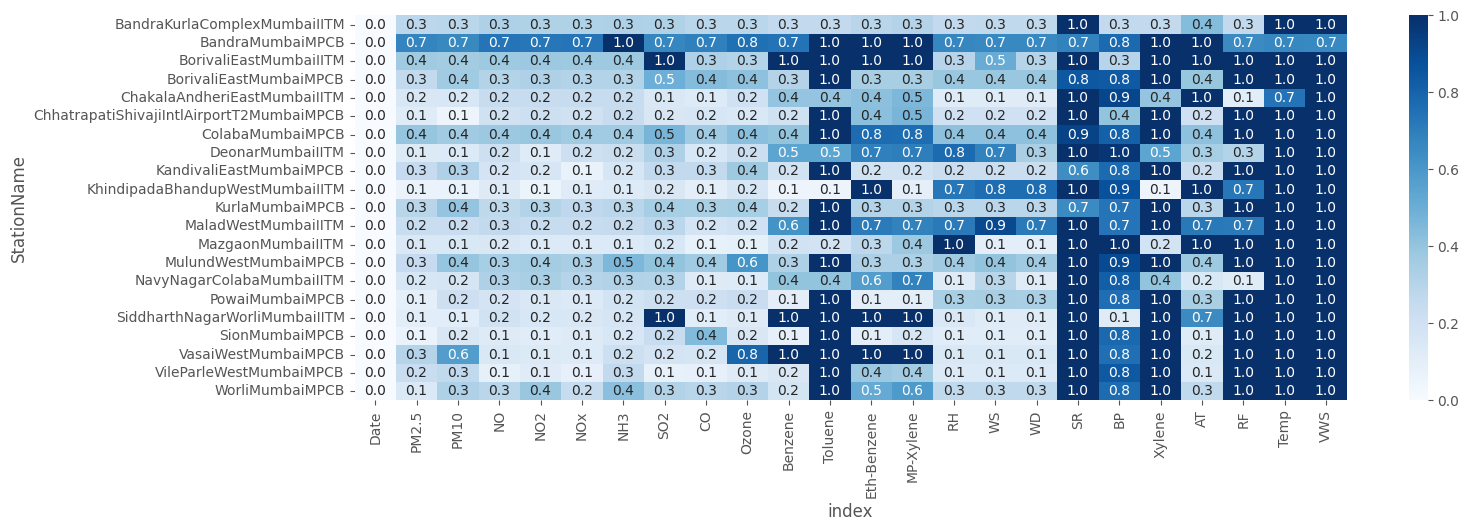

In [14]:
mv_data = mv_data.replace(np.NaN, 1)
mv_data['StationName'] = station_names
mv_data = mv_data.set_index('StationName')

plt.figure(figsize=(16,5))
sns.heatmap(mv_data, annot=True, cmap='Blues', fmt='.1f') # Create the heatmap
plt.show() # Show the plot

#### Each station missing-ness 

<Axes: >

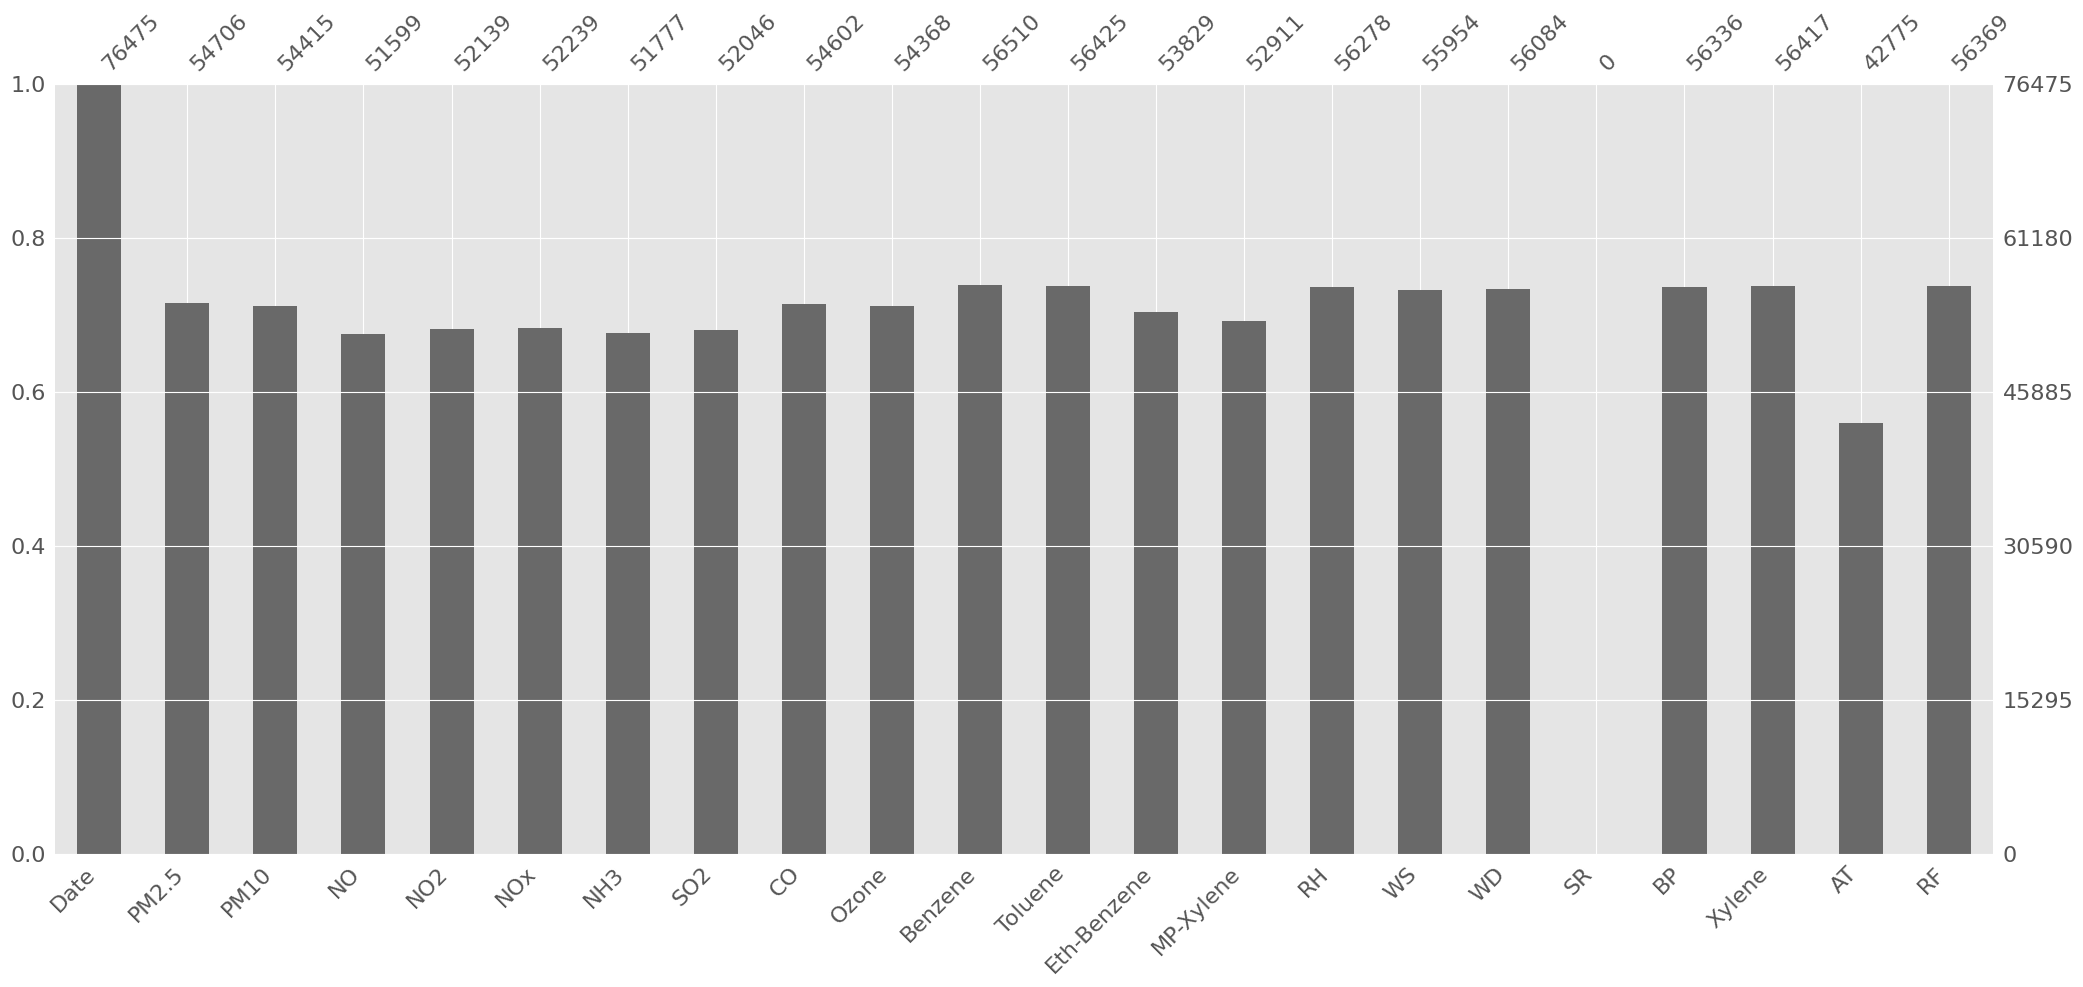

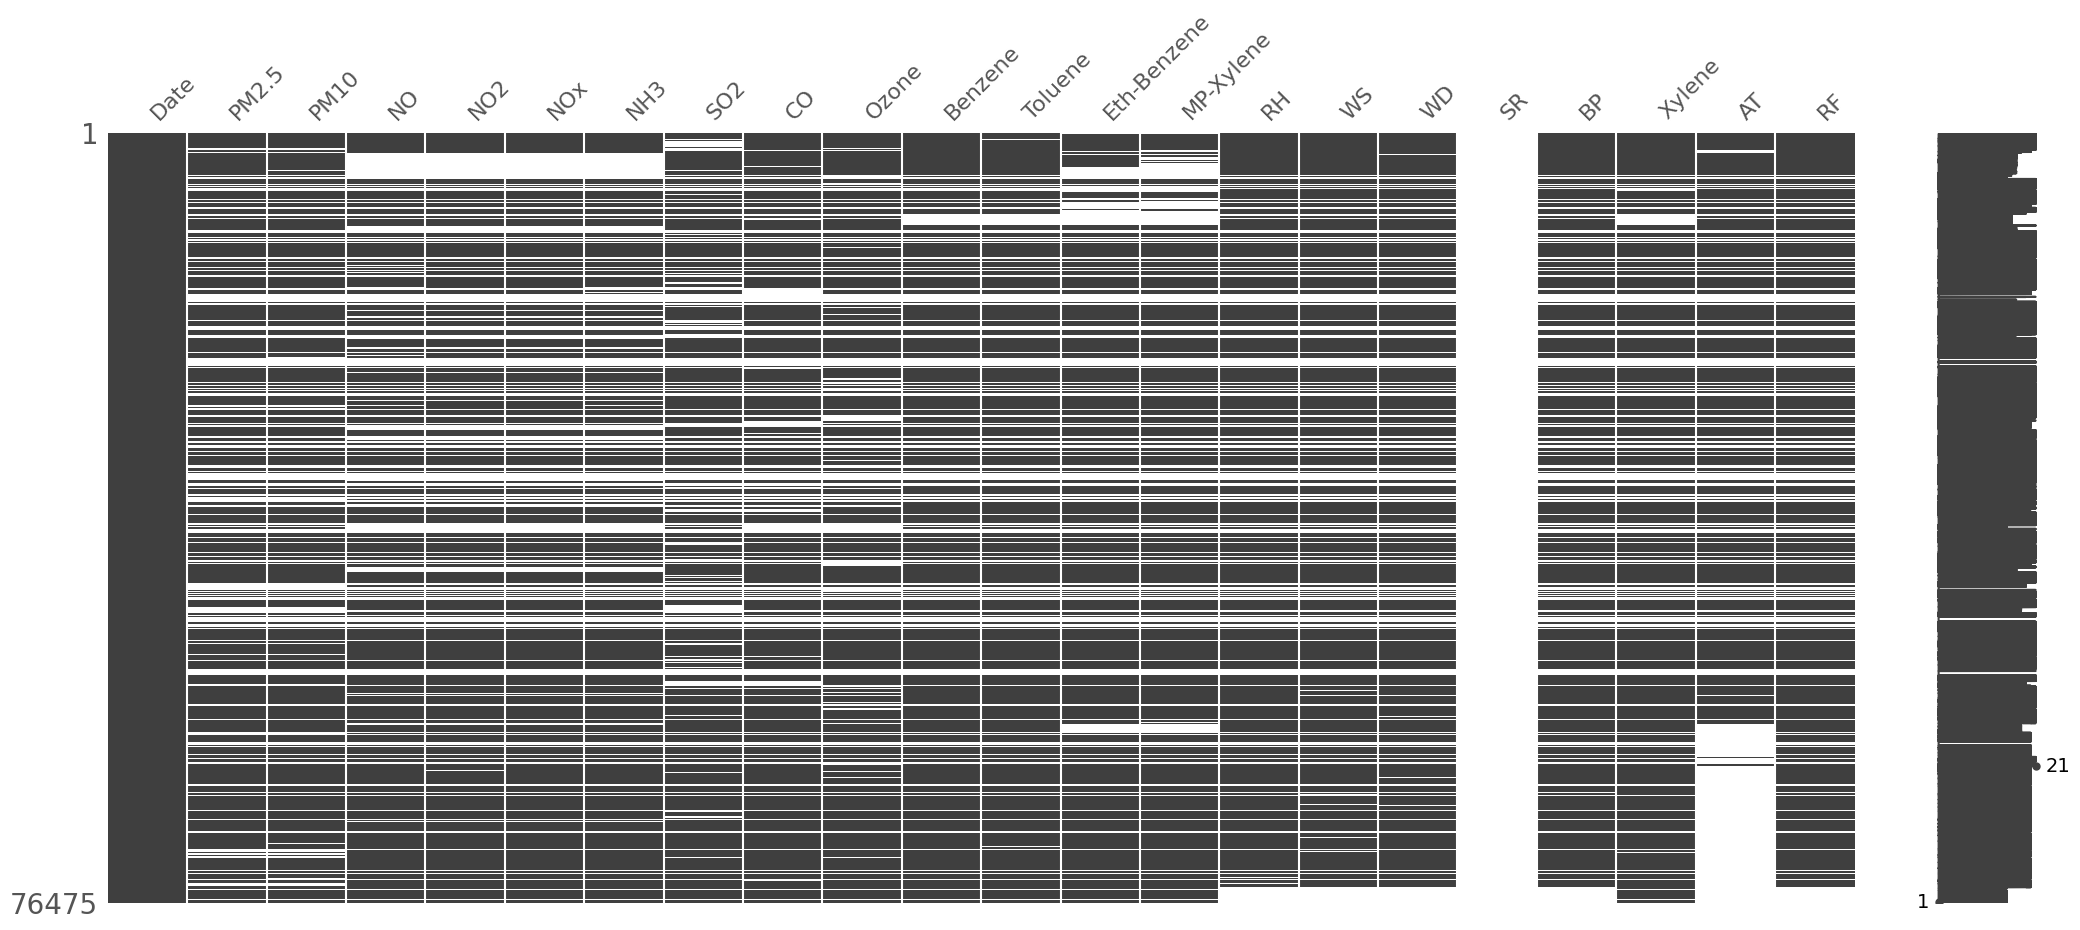

In [15]:
plt.rcParams['figure.figsize']=(20,6)
msno.bar(data_dict['BandraKurlaComplexMumbaiIITM'])
msno.matrix(data_dict['BandraKurlaComplexMumbaiIITM'])

BandraKurlaComplexMumbaiIITM: 
* Pollution parameters - all available for around 70%
* Weather parameters: 
    * SR column missing 
    * RH, WS, WD, BP missing recently
    * AT missing recently for a while

<Axes: >

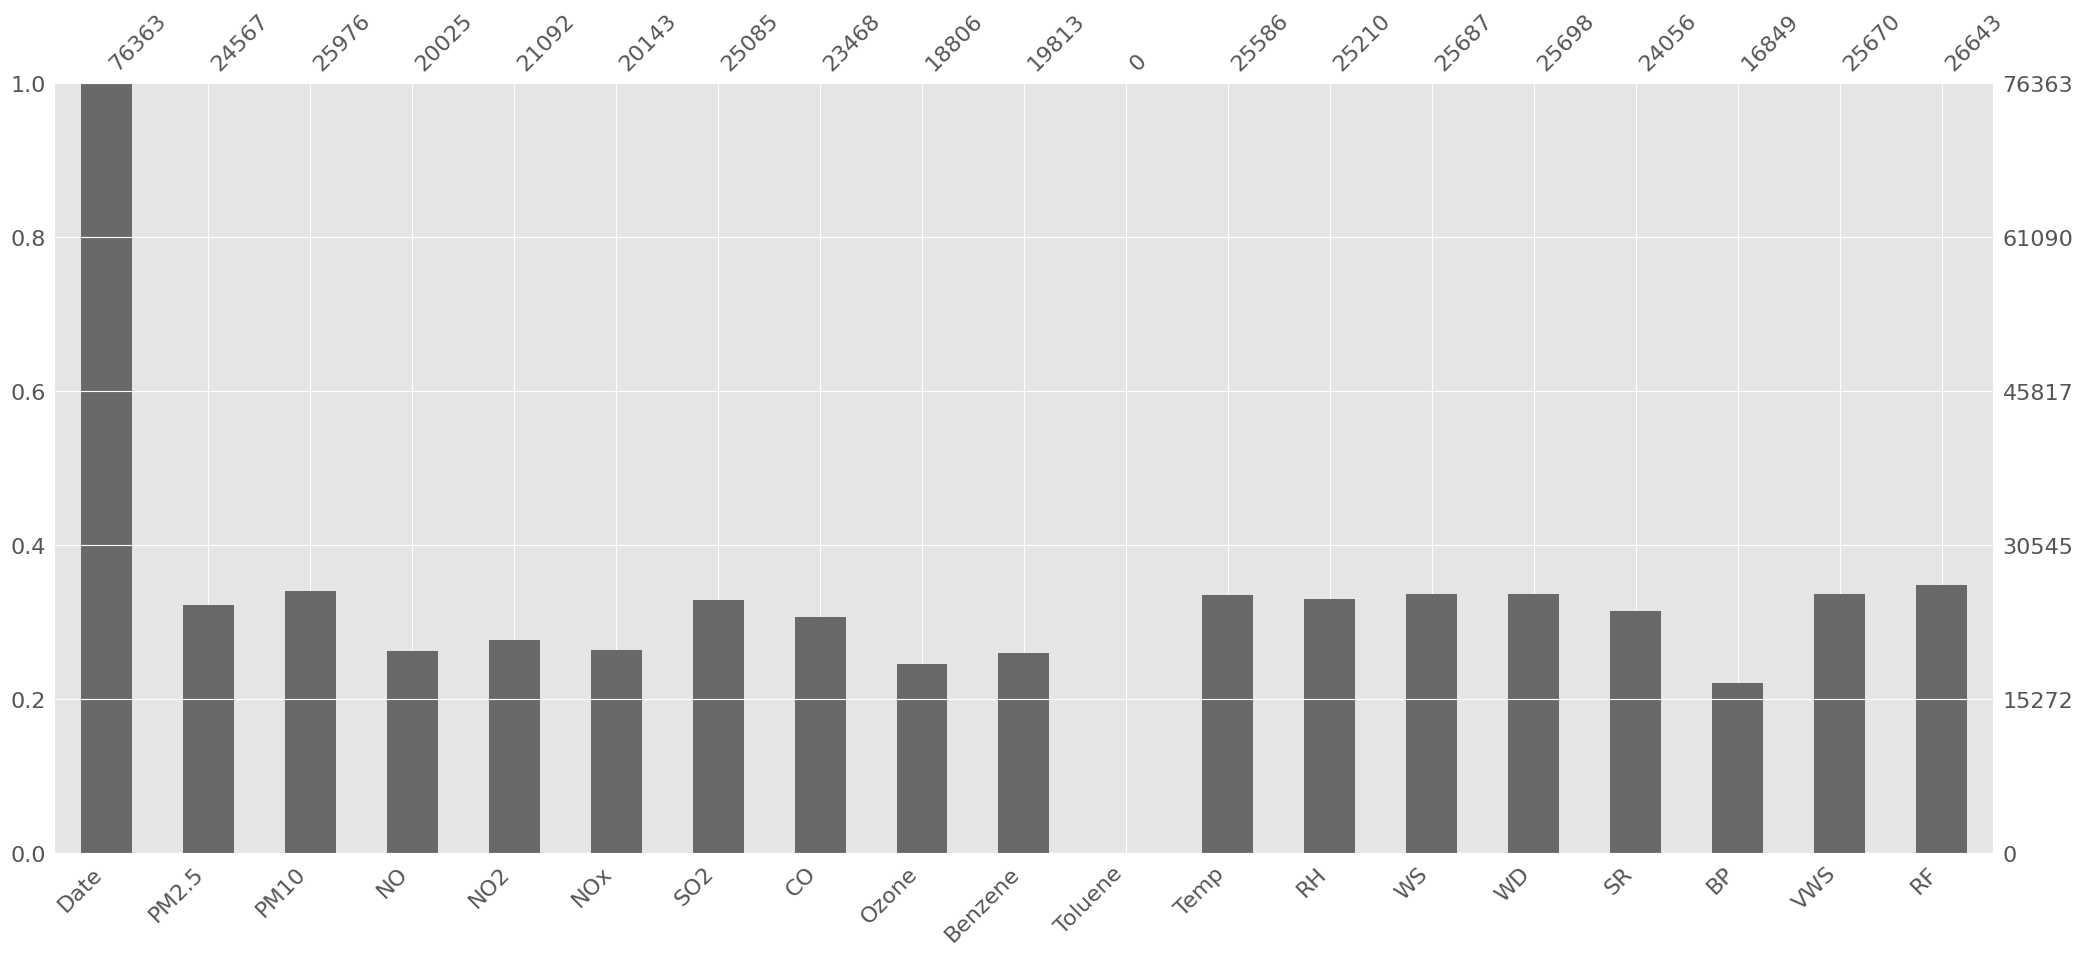

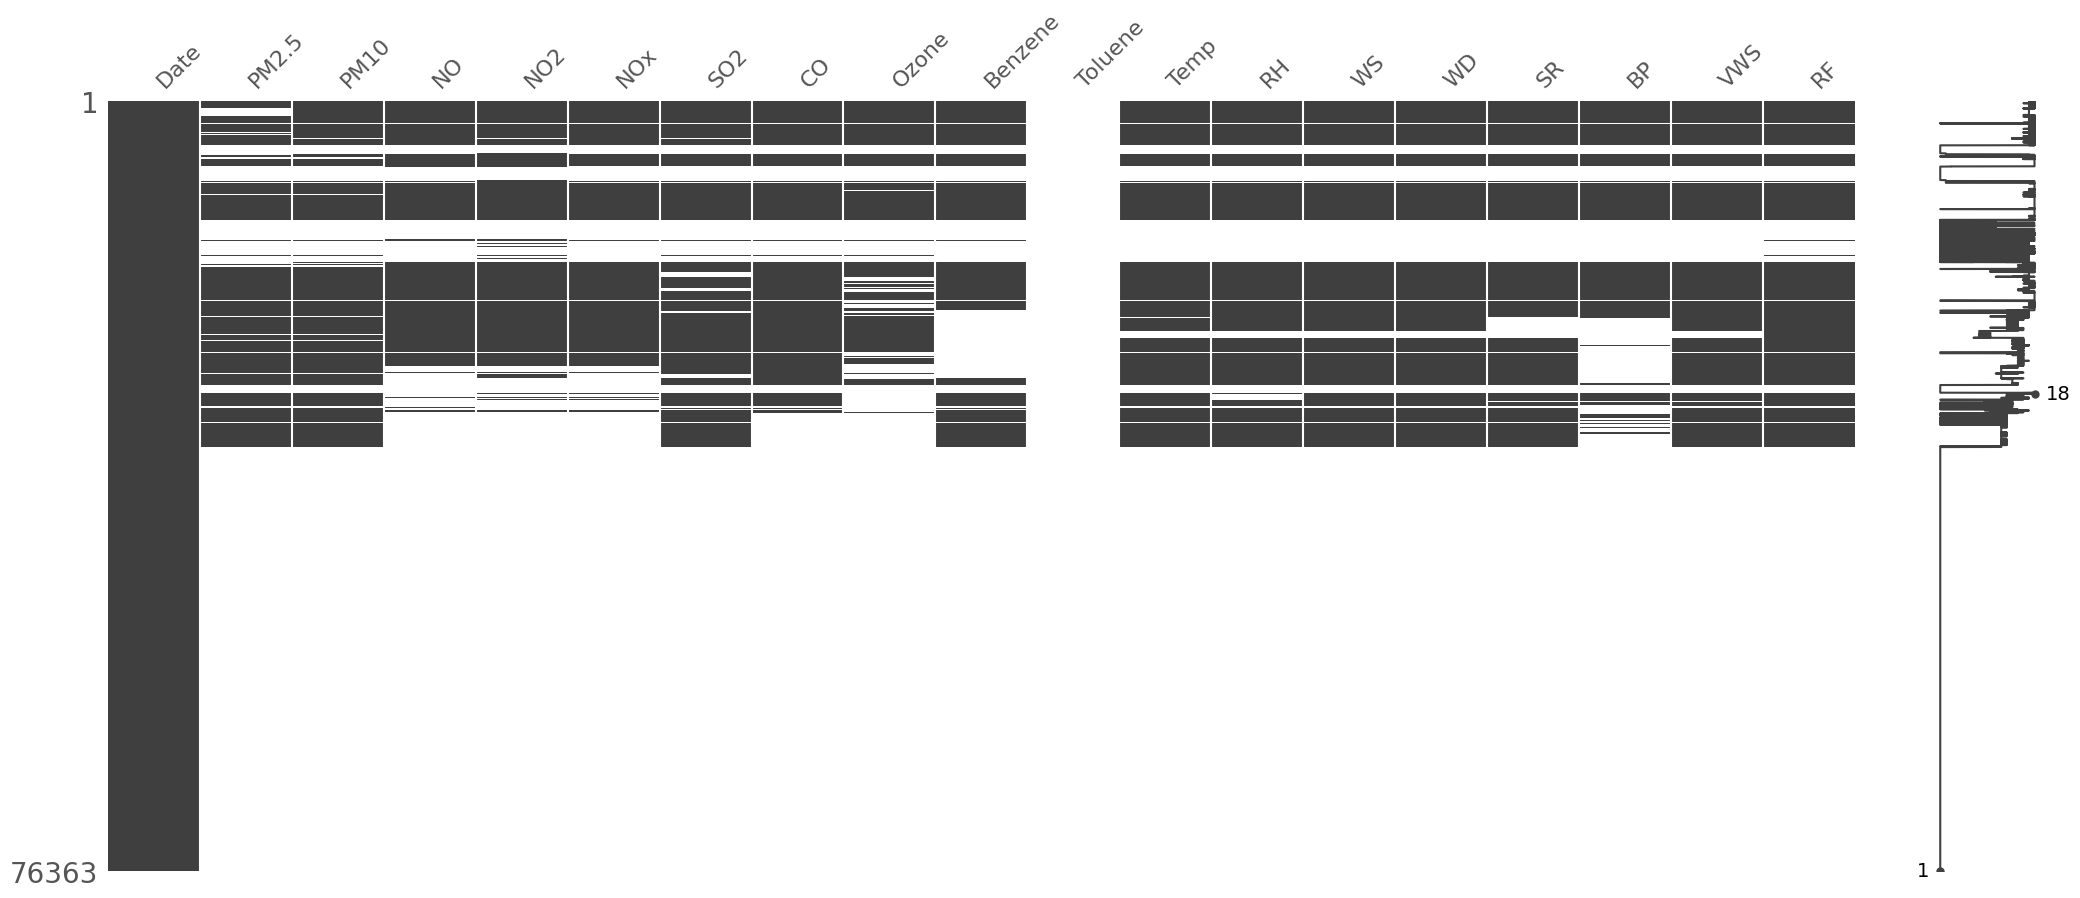

In [16]:
plt.rcParams['figure.figsize']=(20,6)
msno.bar(data_dict['BandraMumbaiMPCB'])
msno.matrix(data_dict['BandraMumbaiMPCB'])

BandraMumbaiMPCB: 
* All sensors down recently

<Axes: >

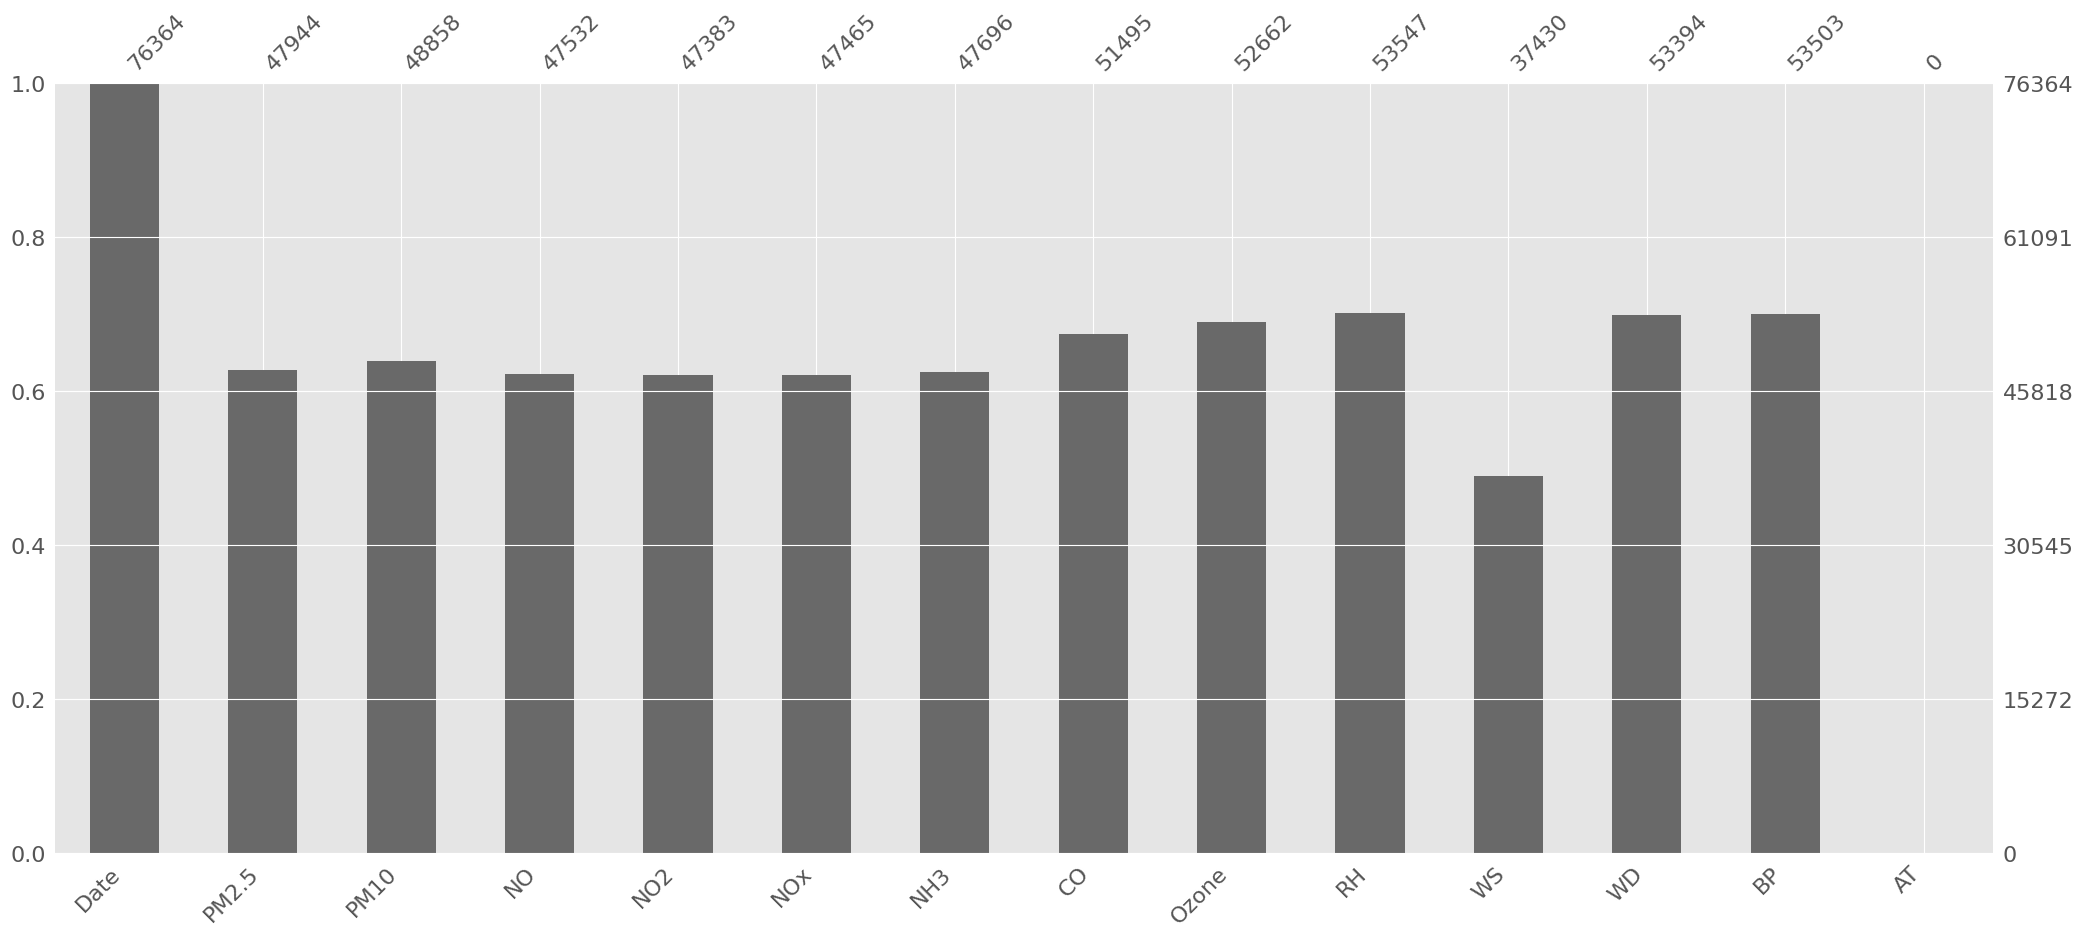

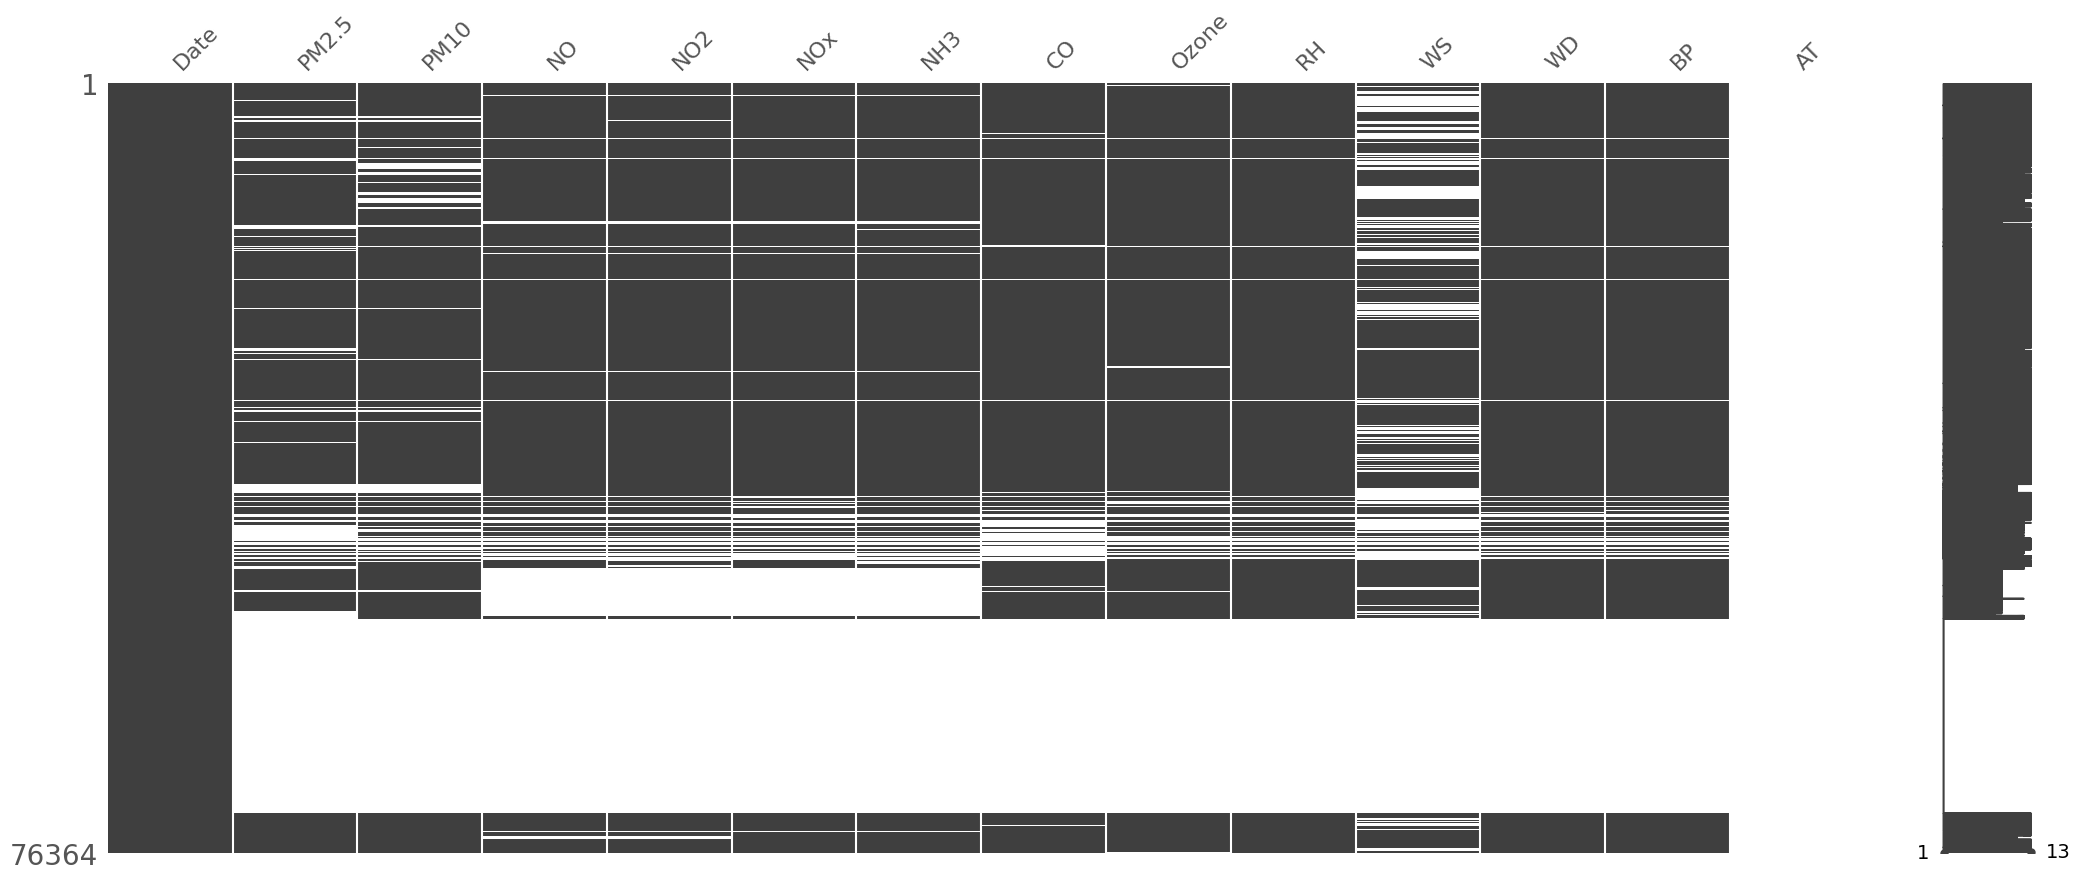

In [17]:
plt.rcParams['figure.figsize']=(20,6)
msno.bar(data_dict['BorivaliEastMumbaiIITM'])
msno.matrix(data_dict['BorivaliEastMumbaiIITM'])

BorivaliEastMumbaiIITM: 
* All sensors down for a good chunk of time, recovered recently

<Axes: >

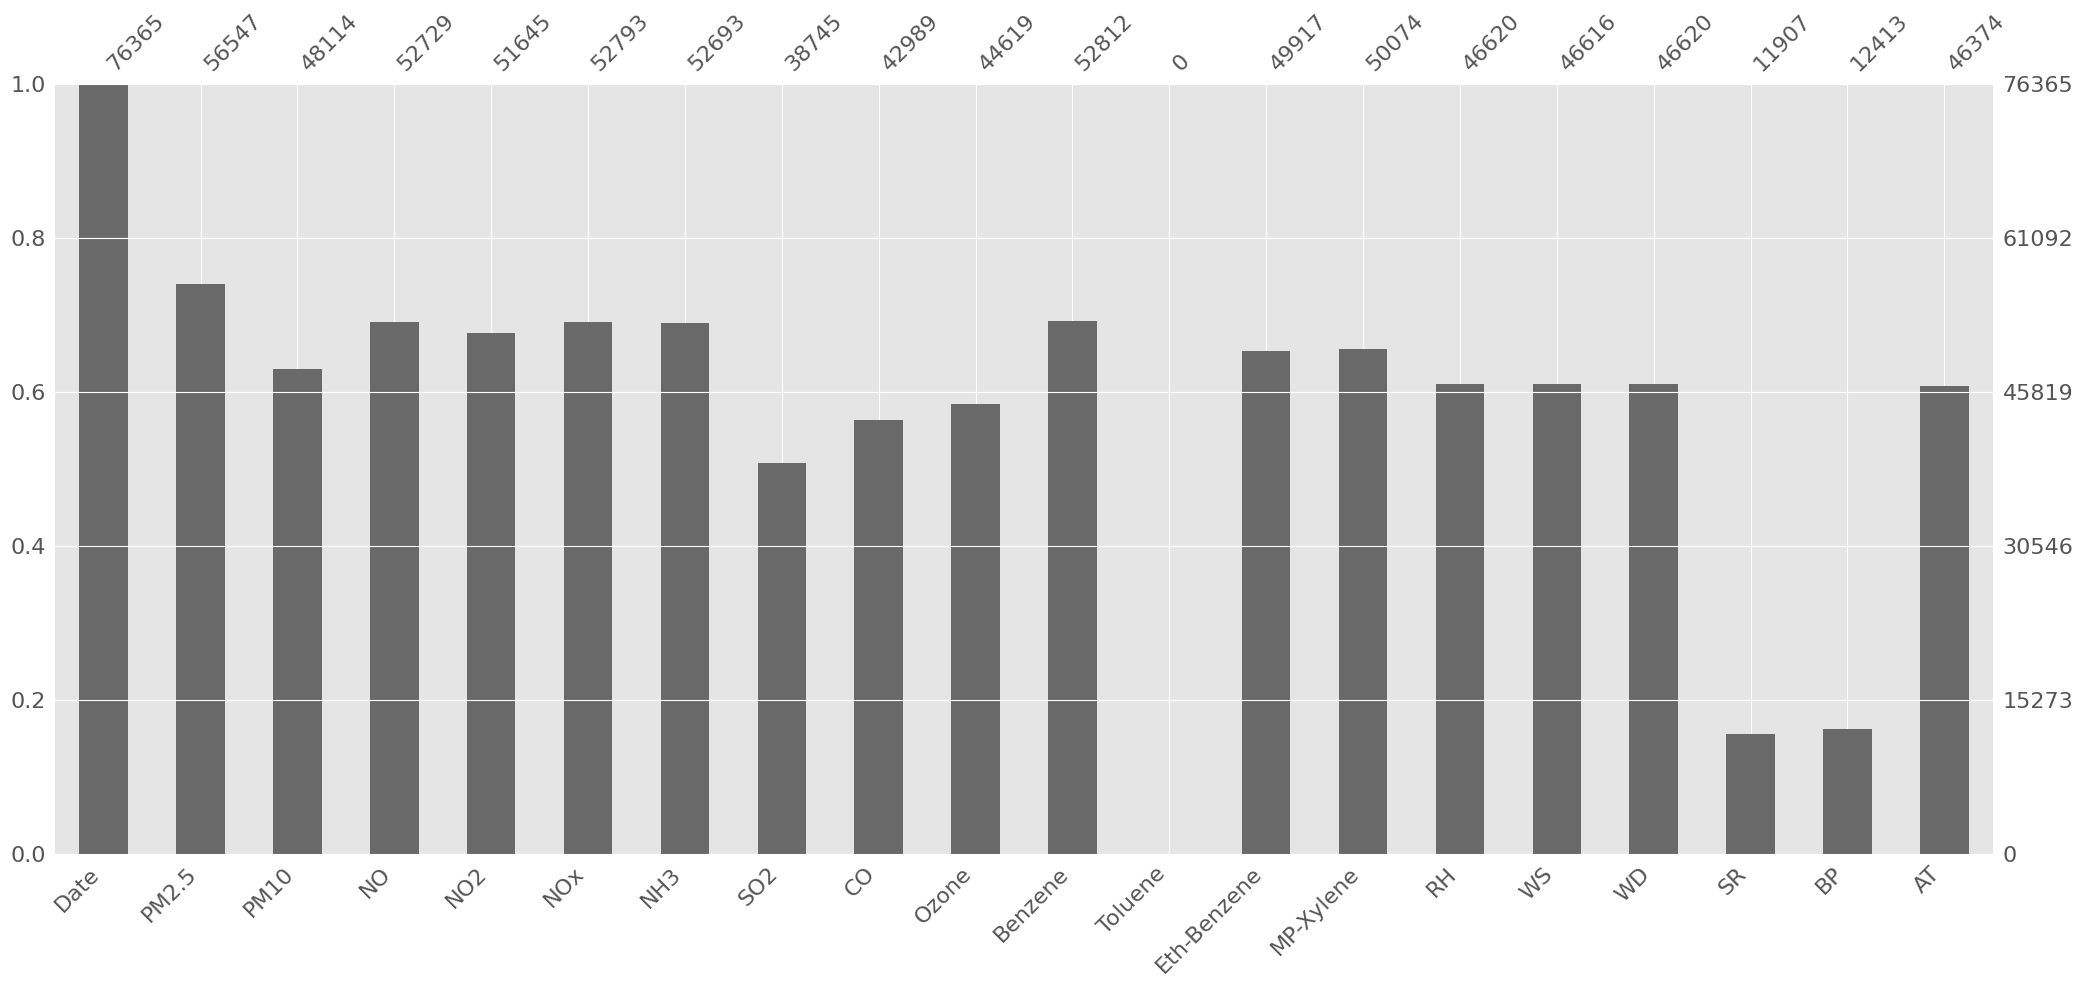

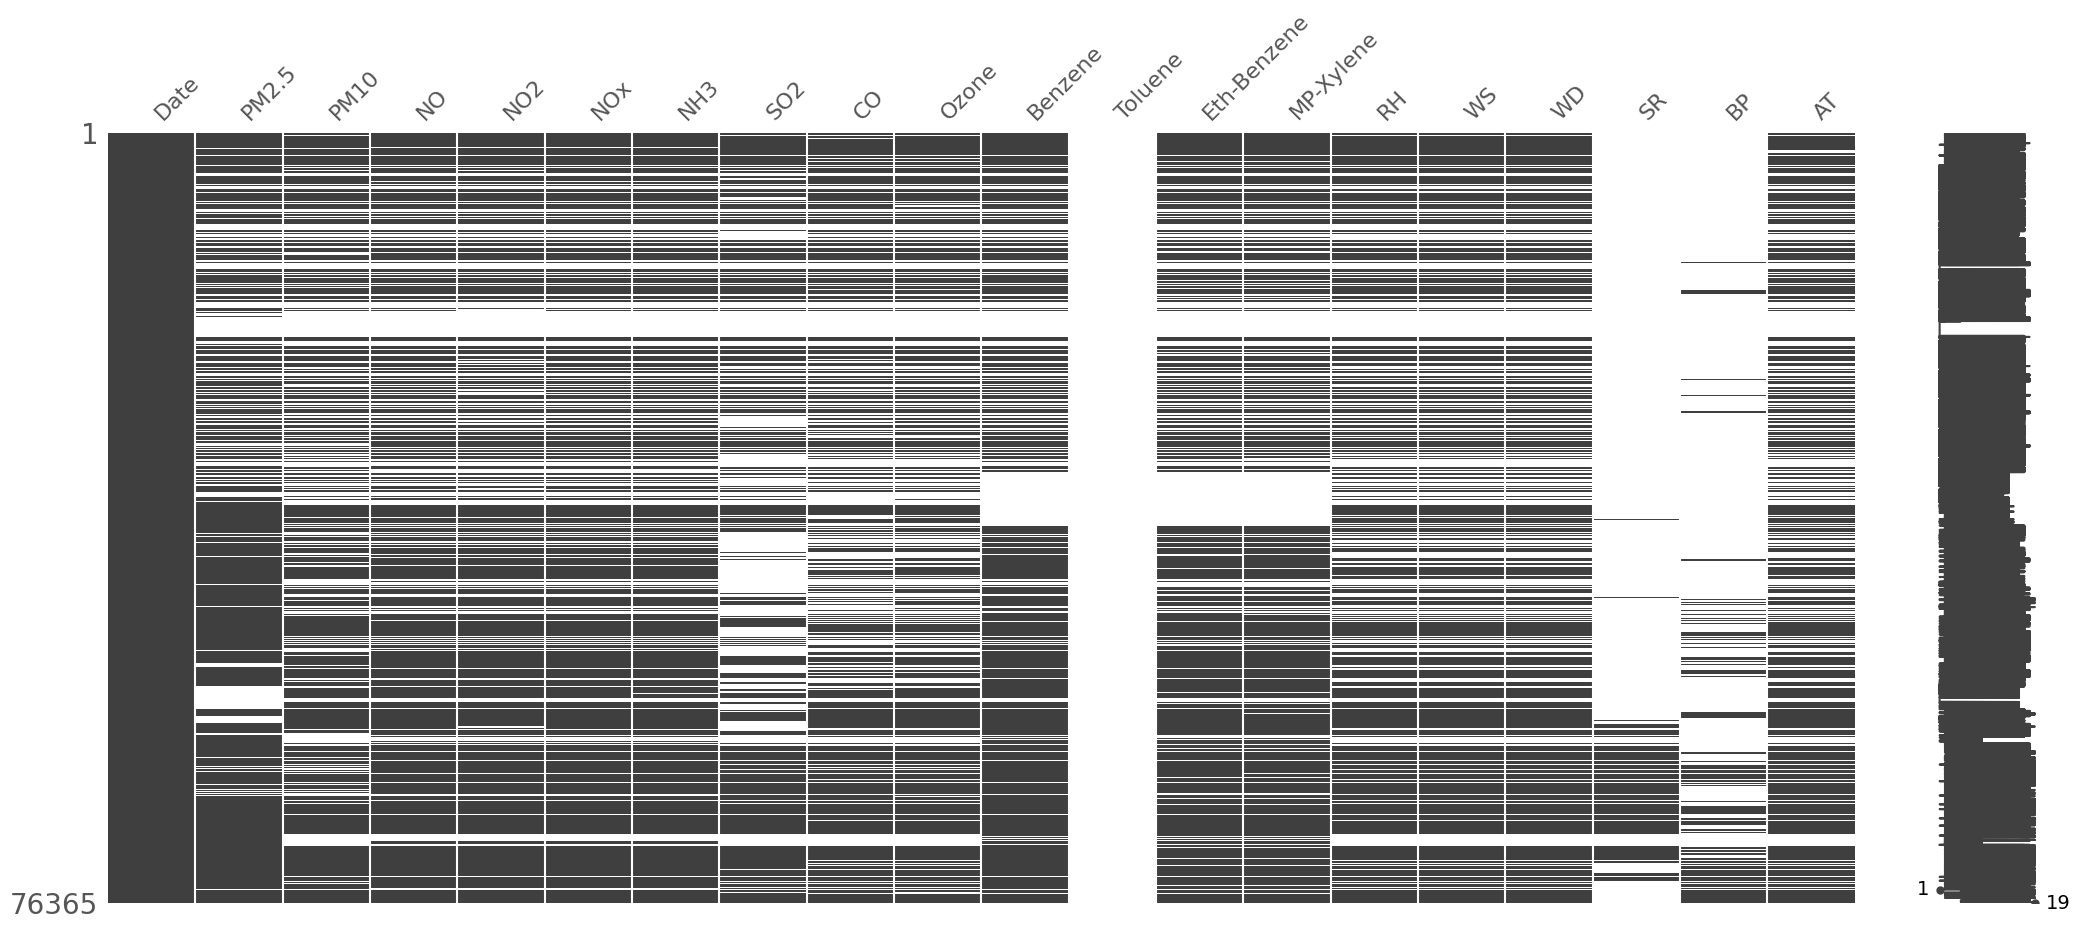

In [18]:
plt.rcParams['figure.figsize']=(20,6)
msno.bar(data_dict['BorivaliEastMumbaiMPCB'])
msno.matrix(data_dict['BorivaliEastMumbaiMPCB'])

BorivaliEastMumbaiMPCB: 
* All sensors for a chunk of period
* Pollutants
    * Toluene completely missing 
    * Benzene, Eth-Benzene, MP-Xylene have blocks of rows missing
* Weather 
    * SR and BP limited data 

/usr/local/lib/python3.9/dist-packages/missingno/missingno.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=figsize)


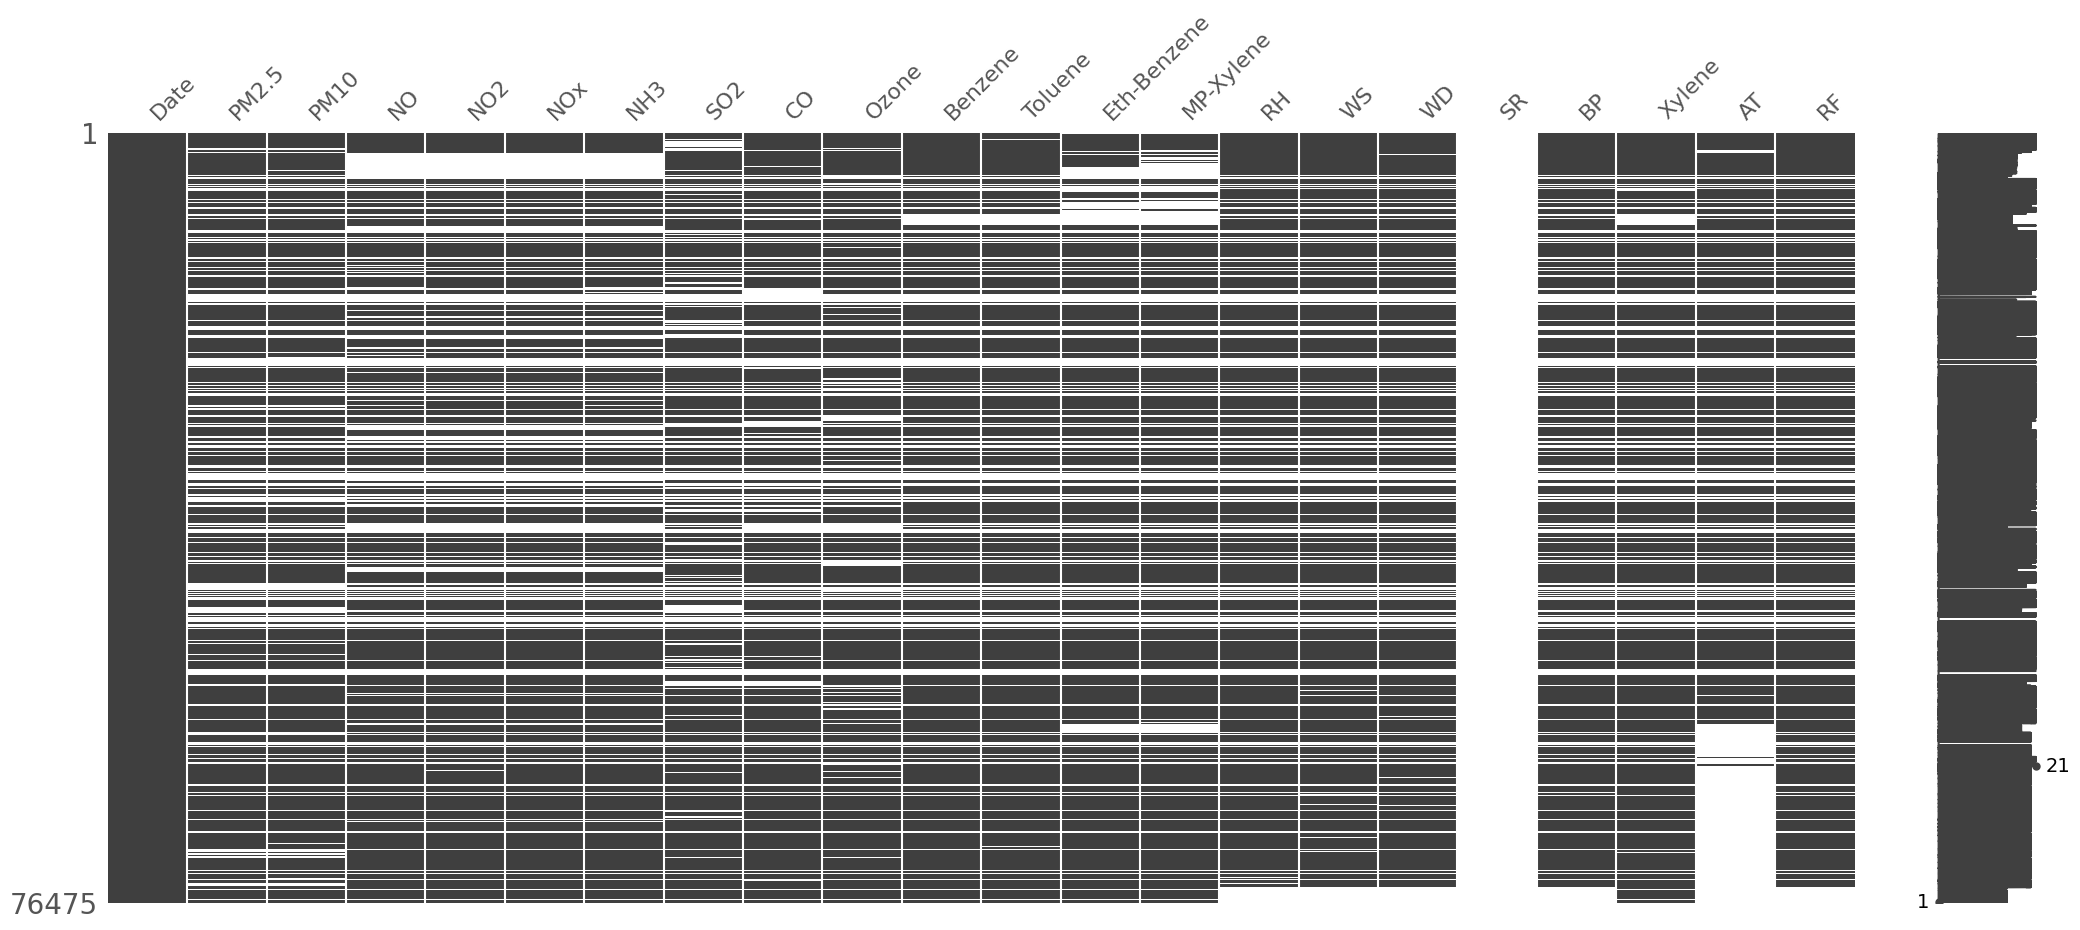

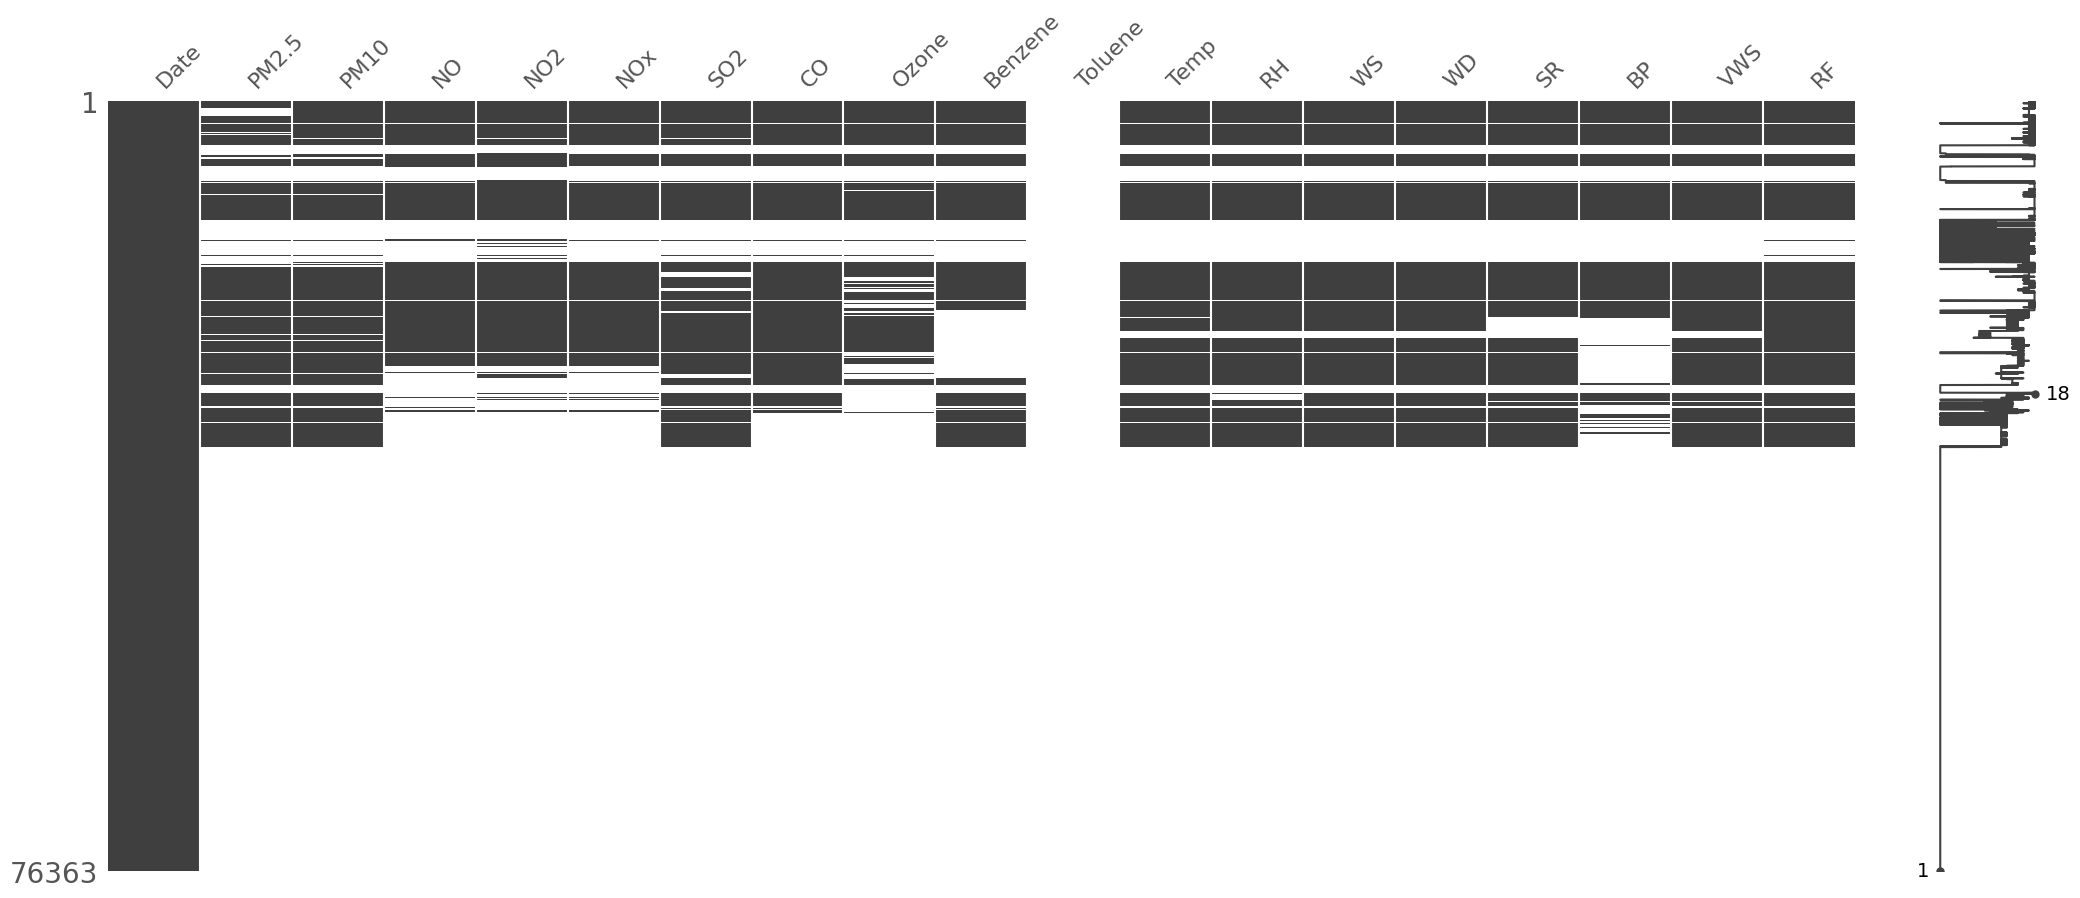

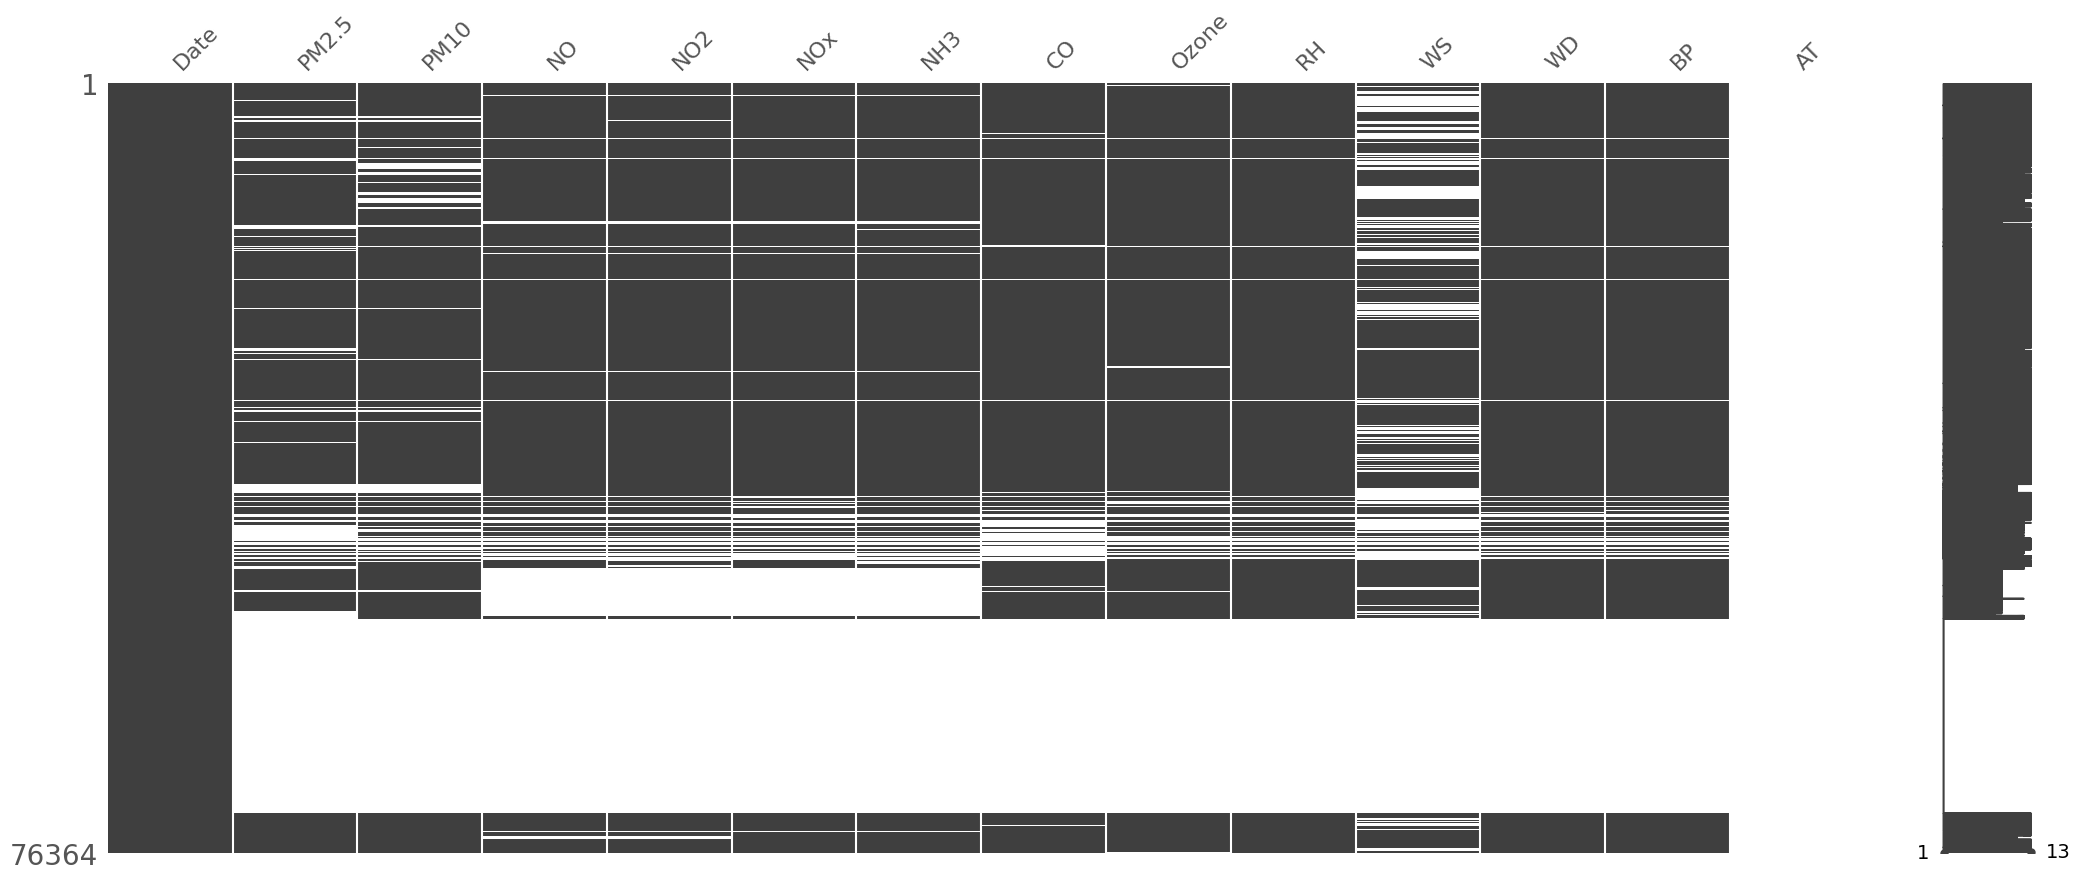

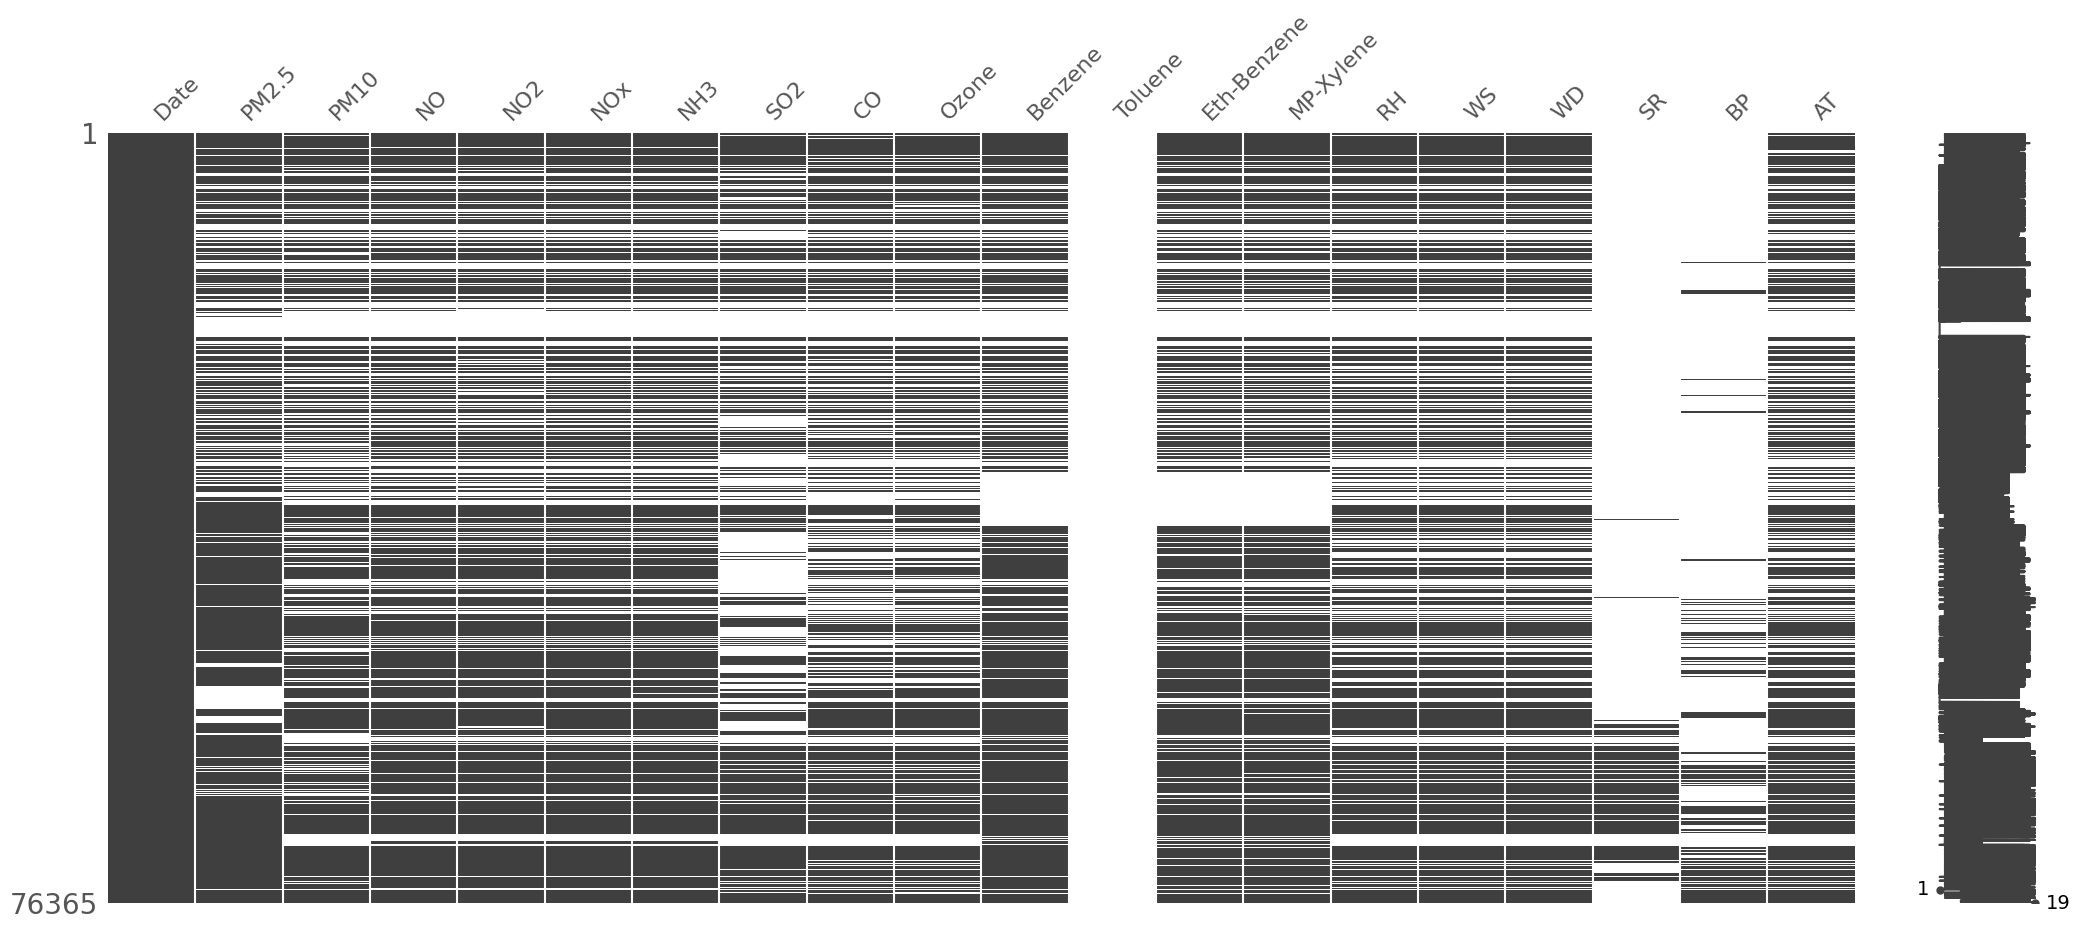

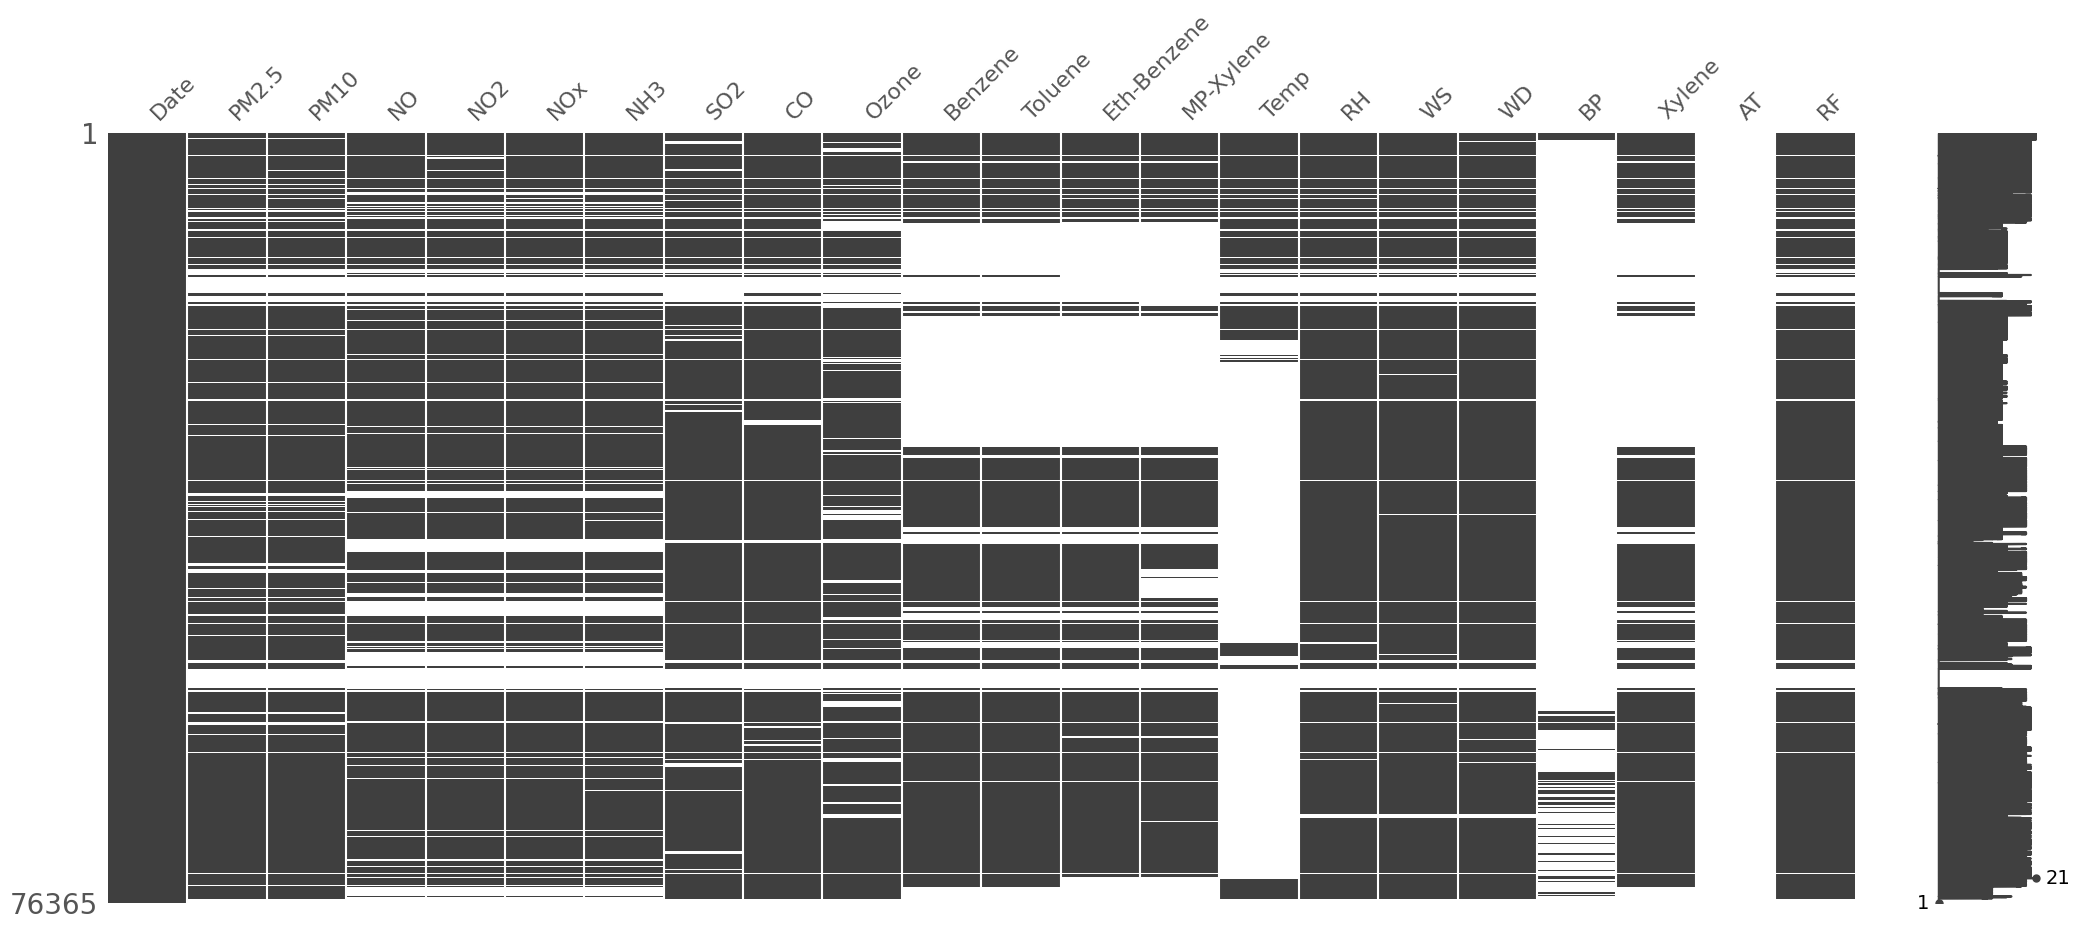

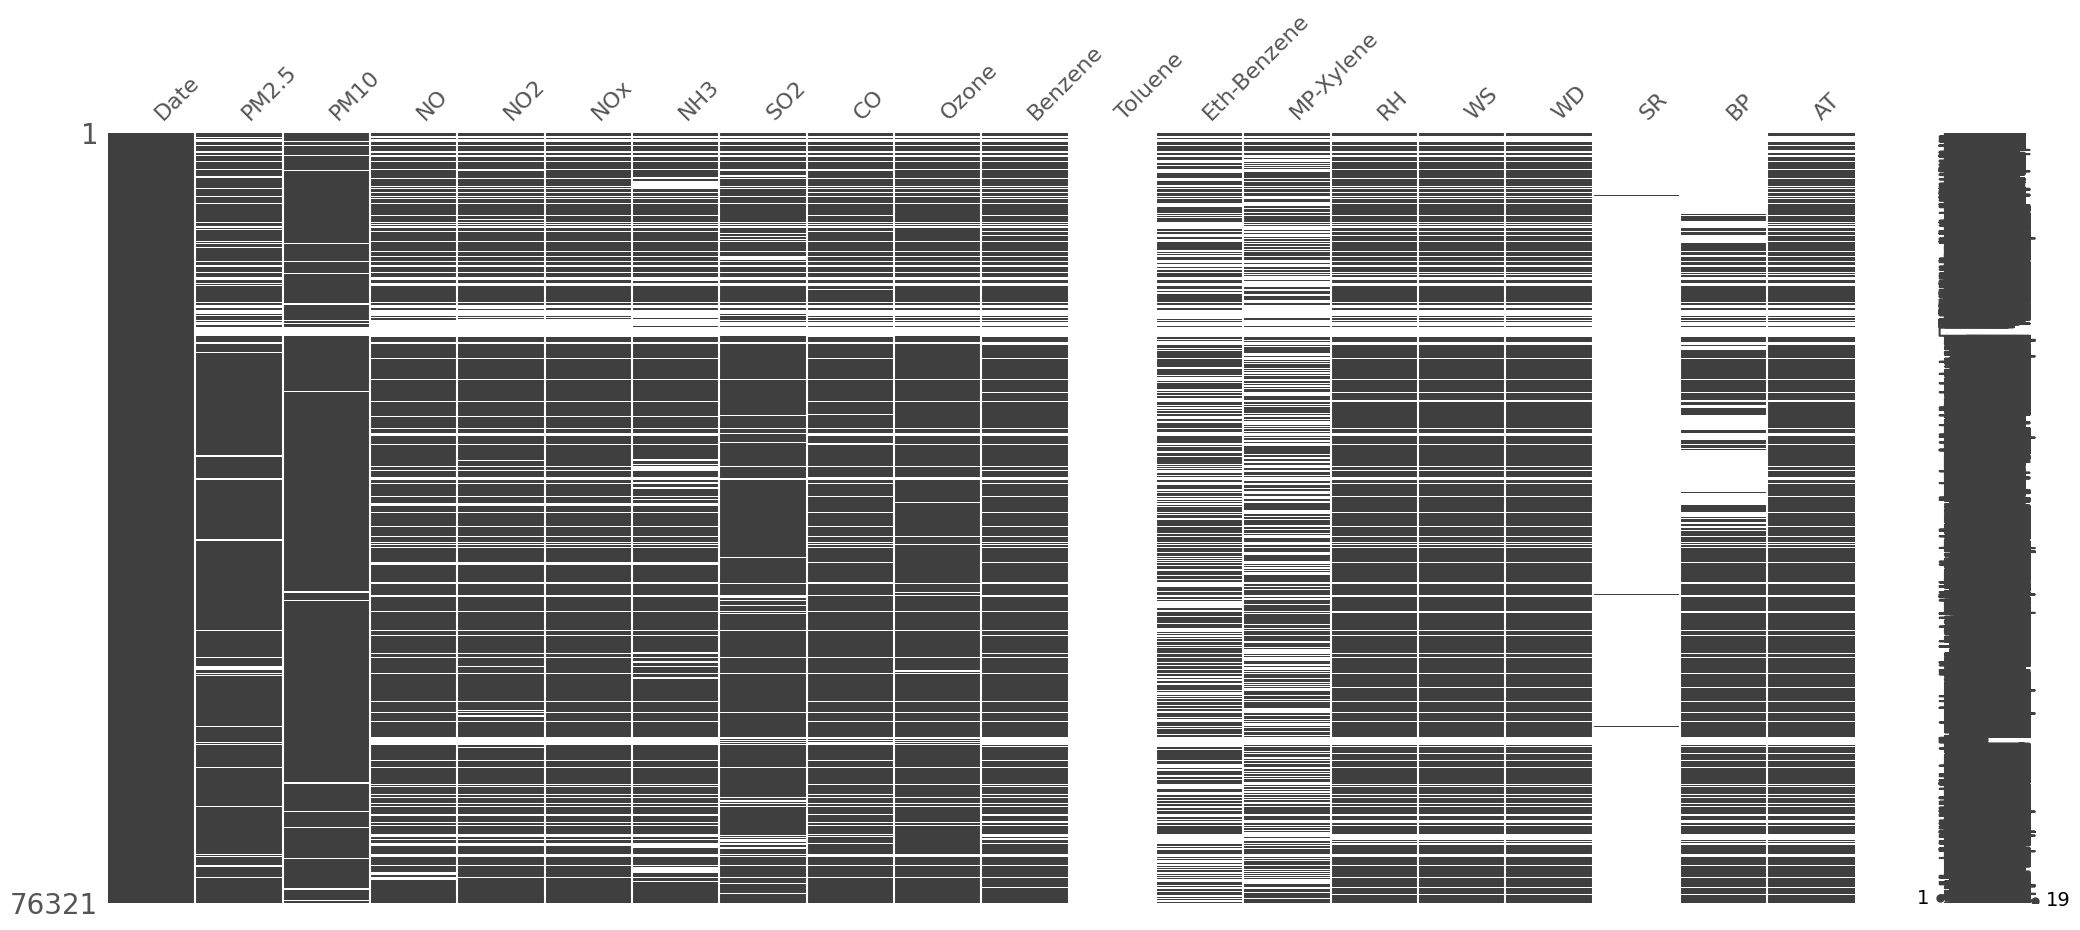

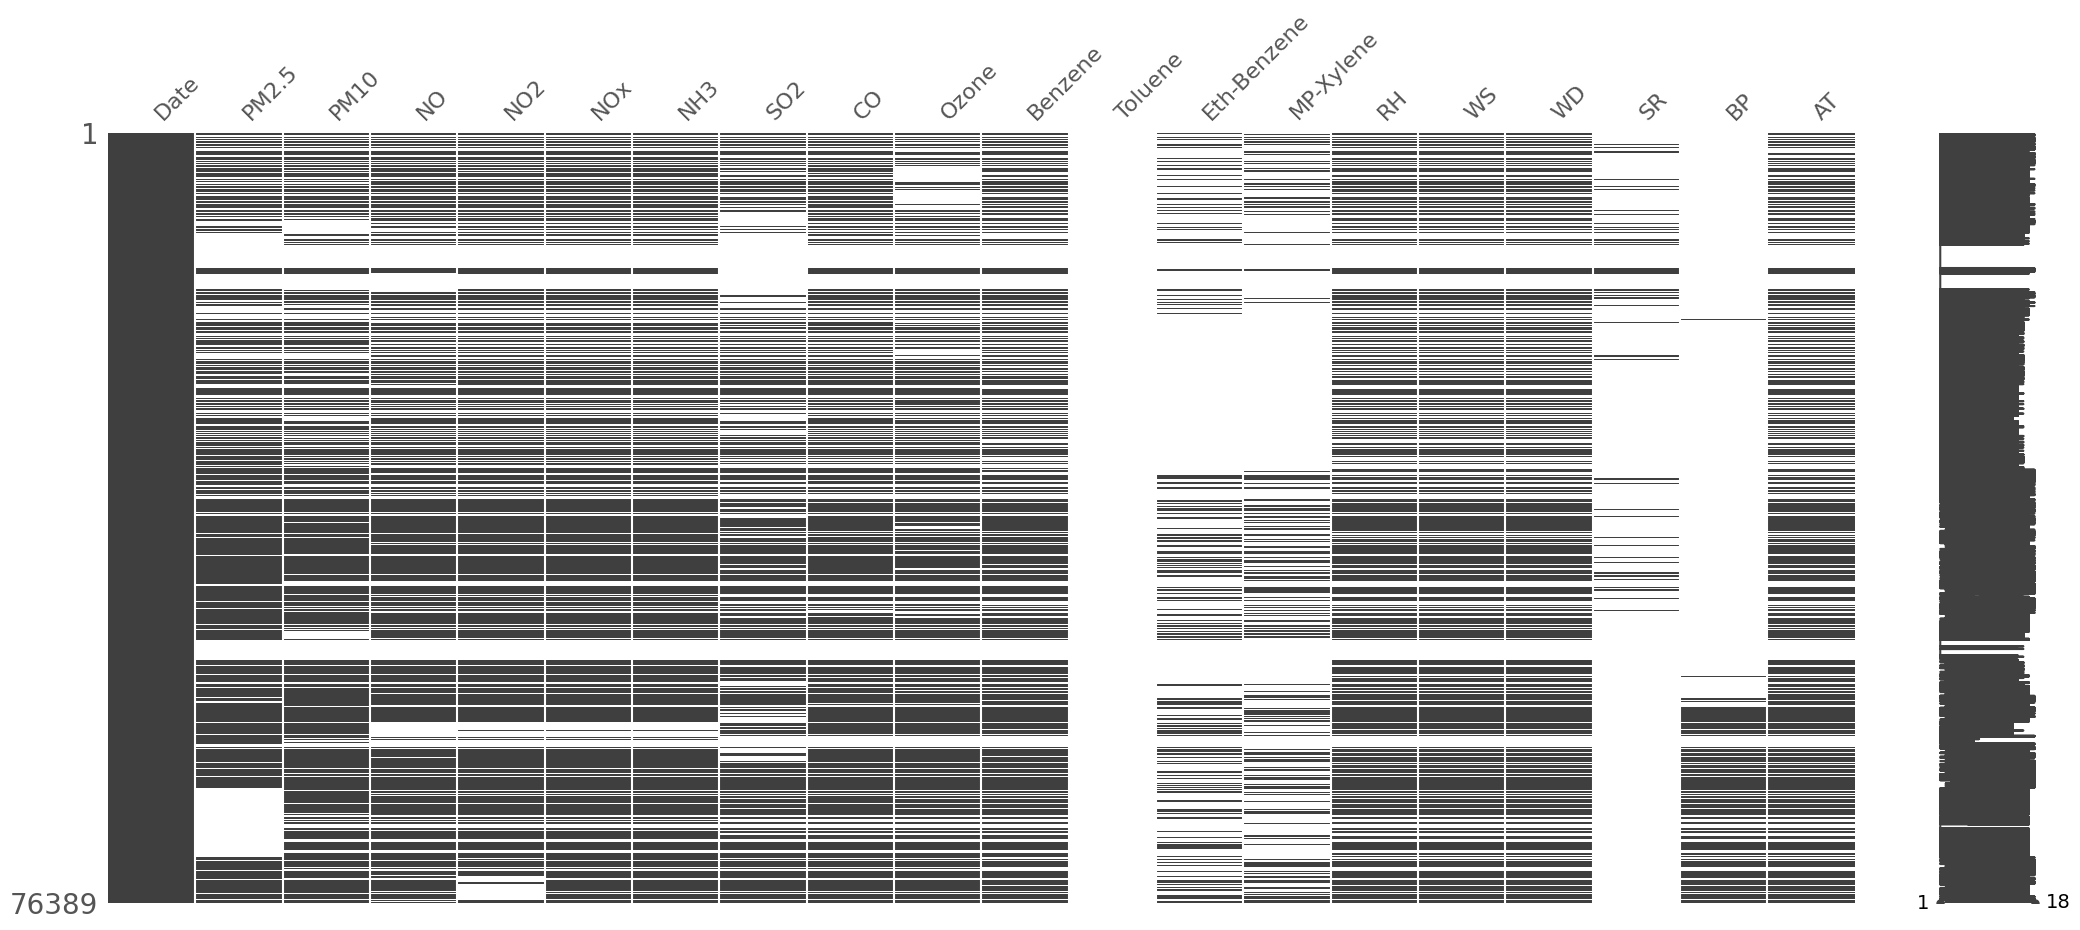

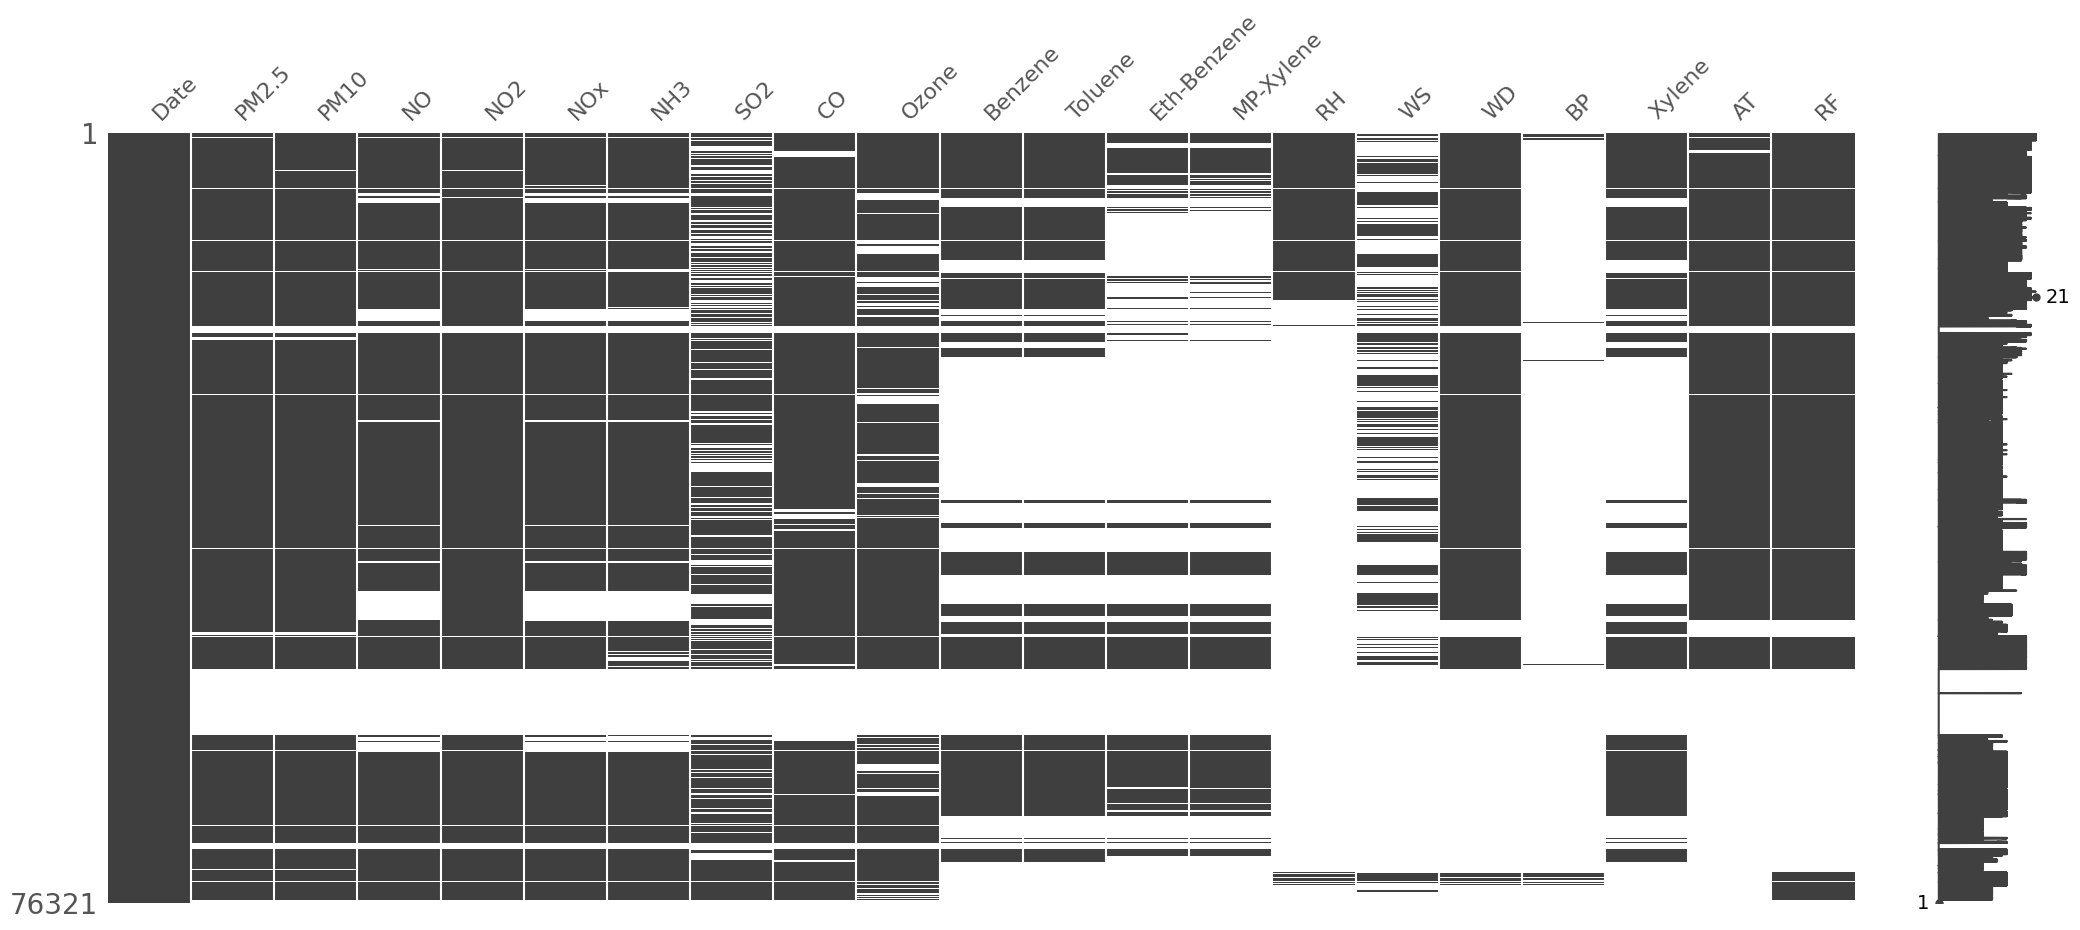

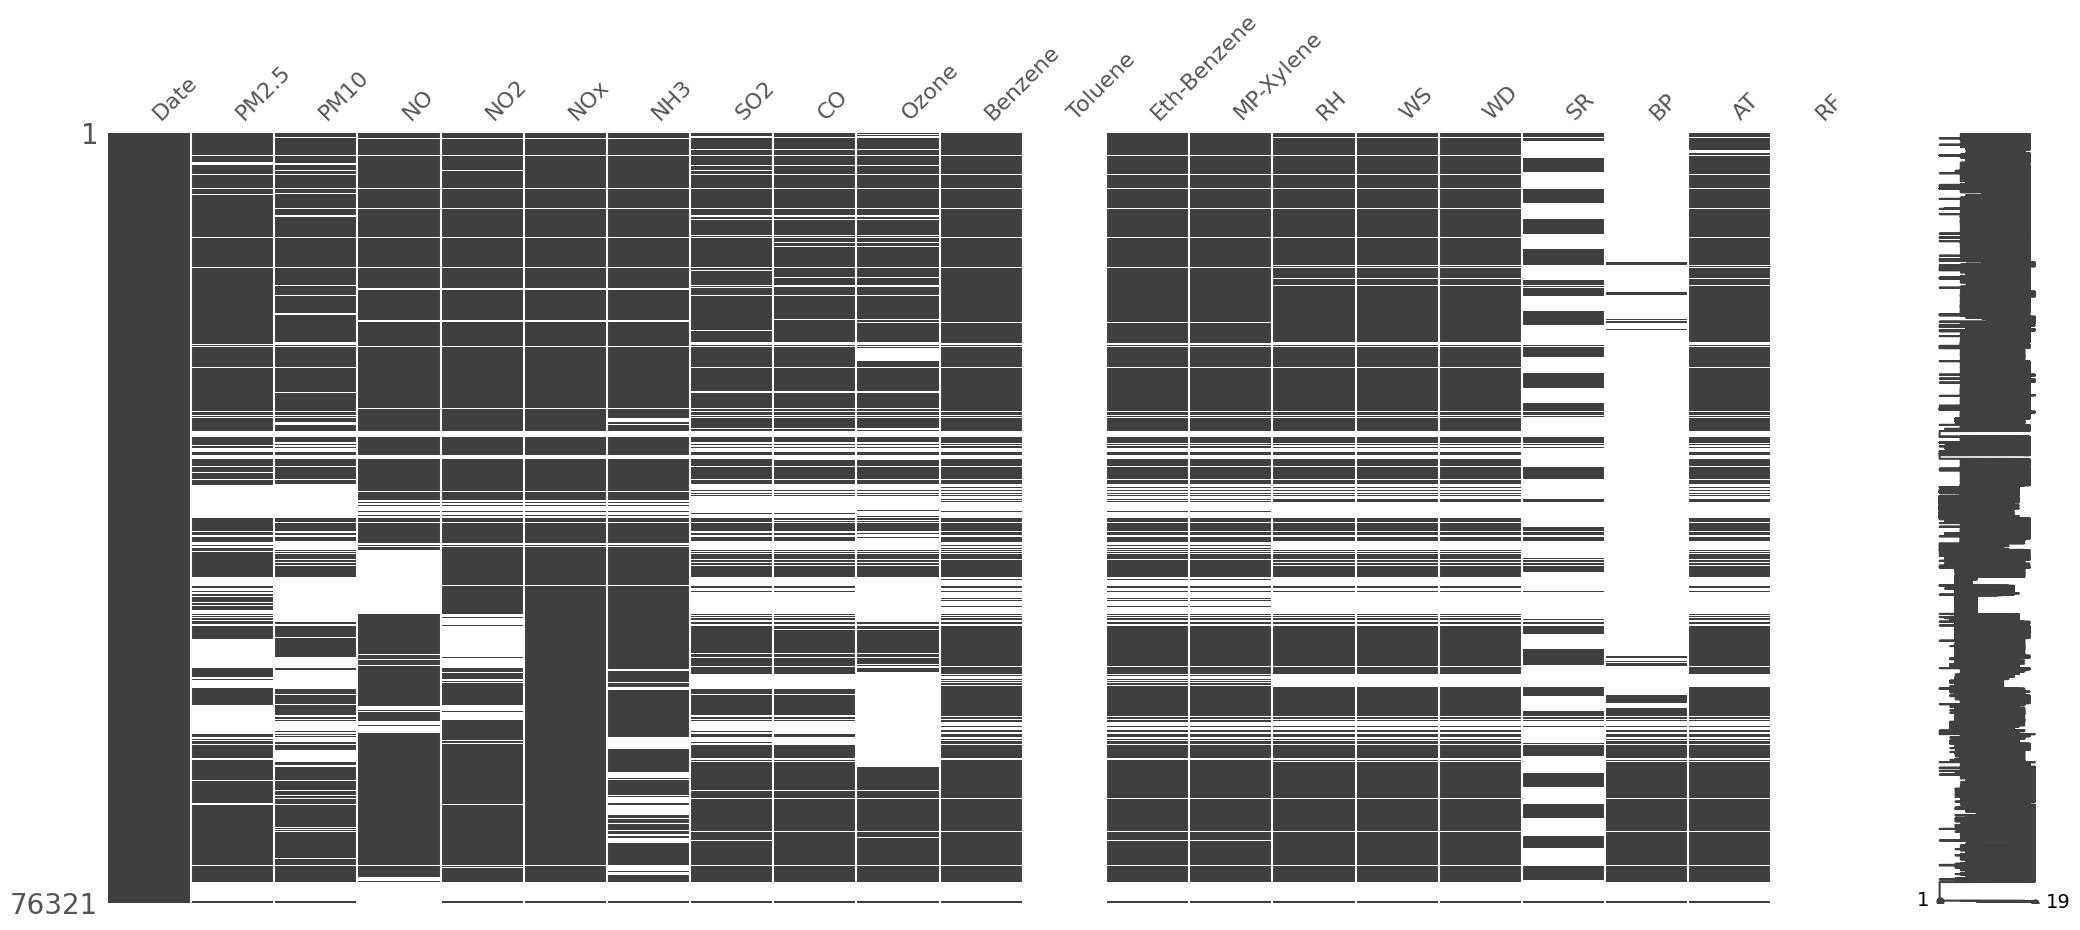

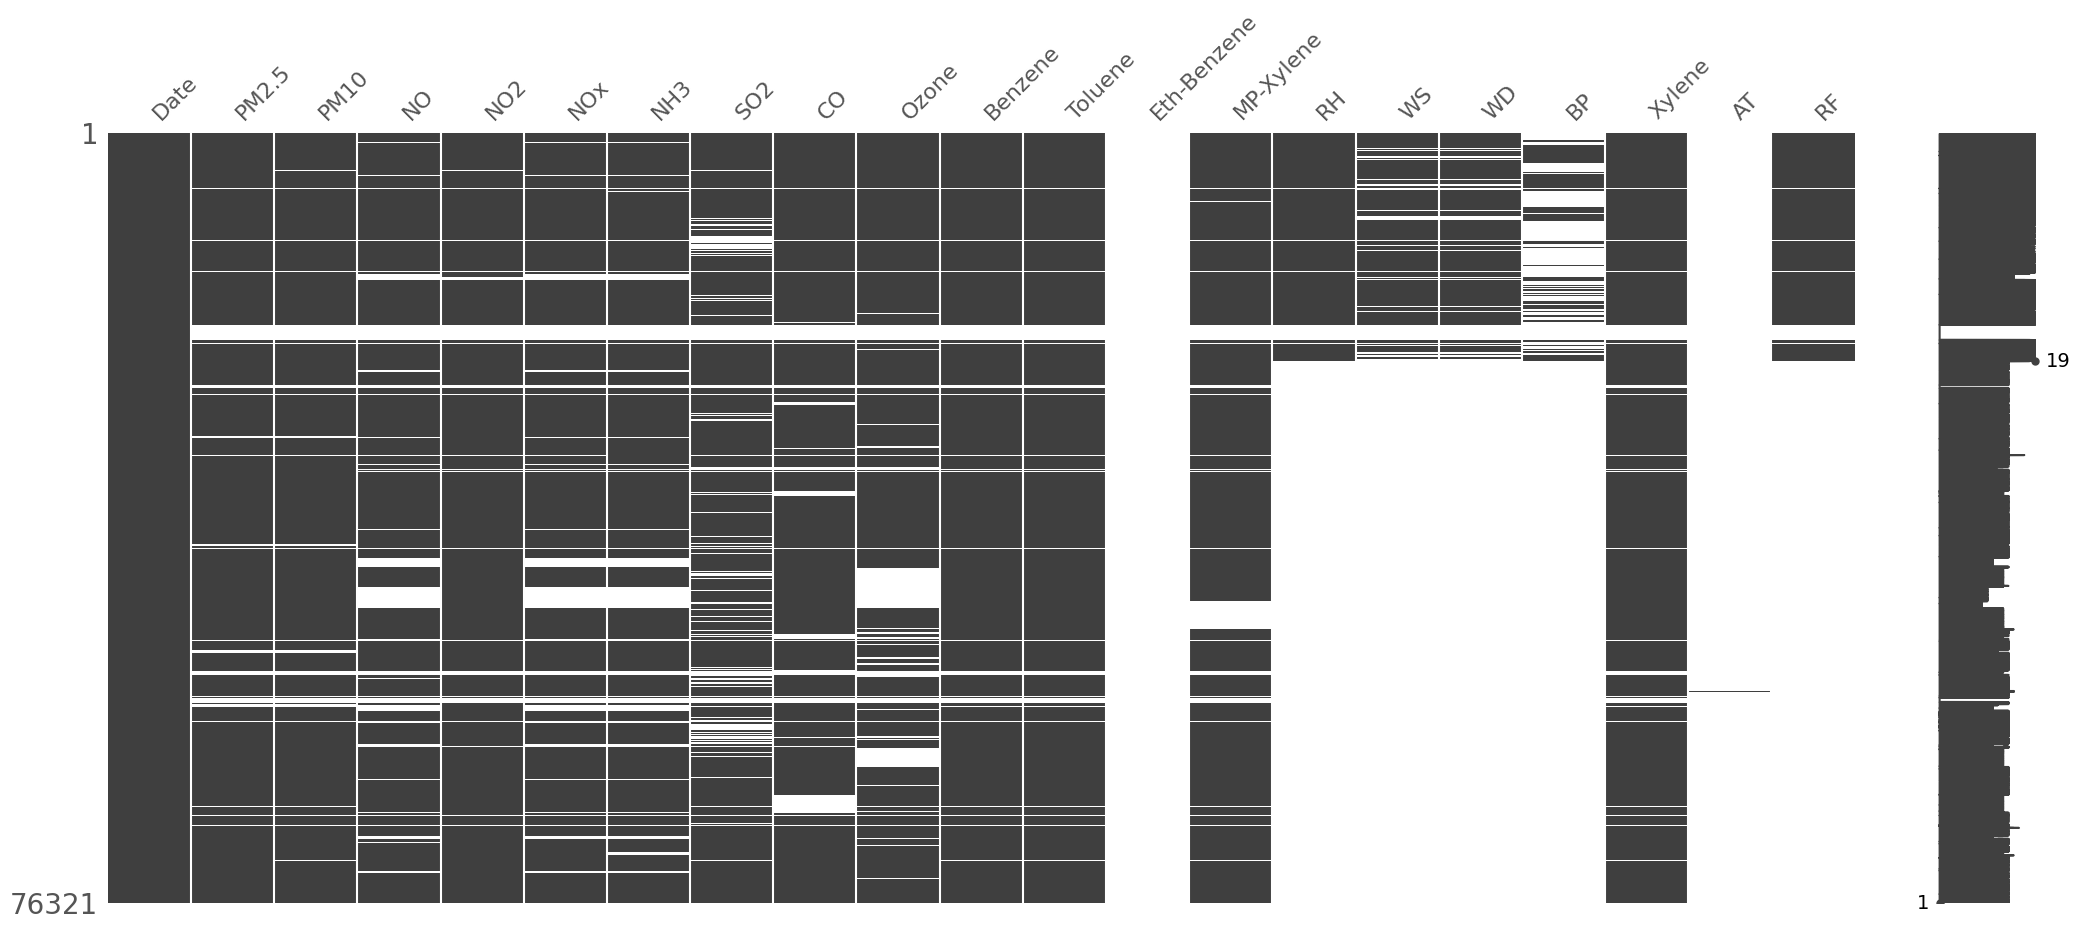

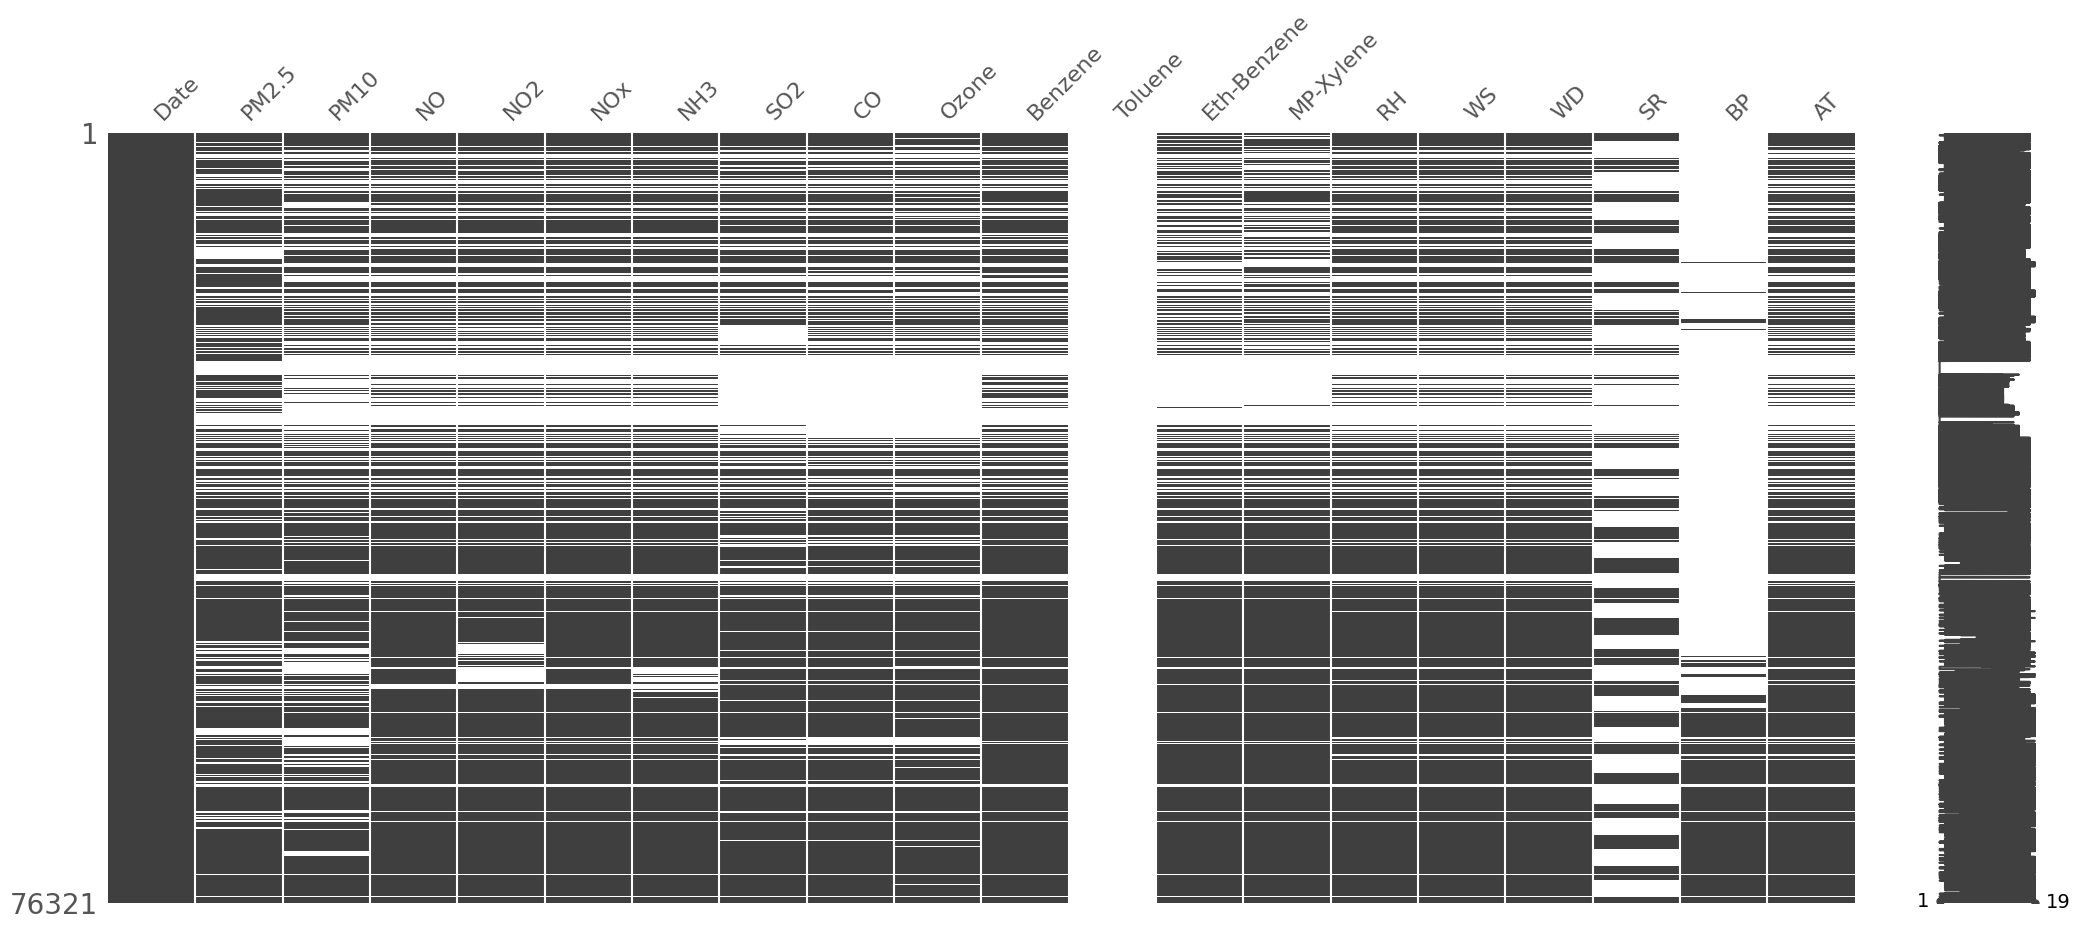

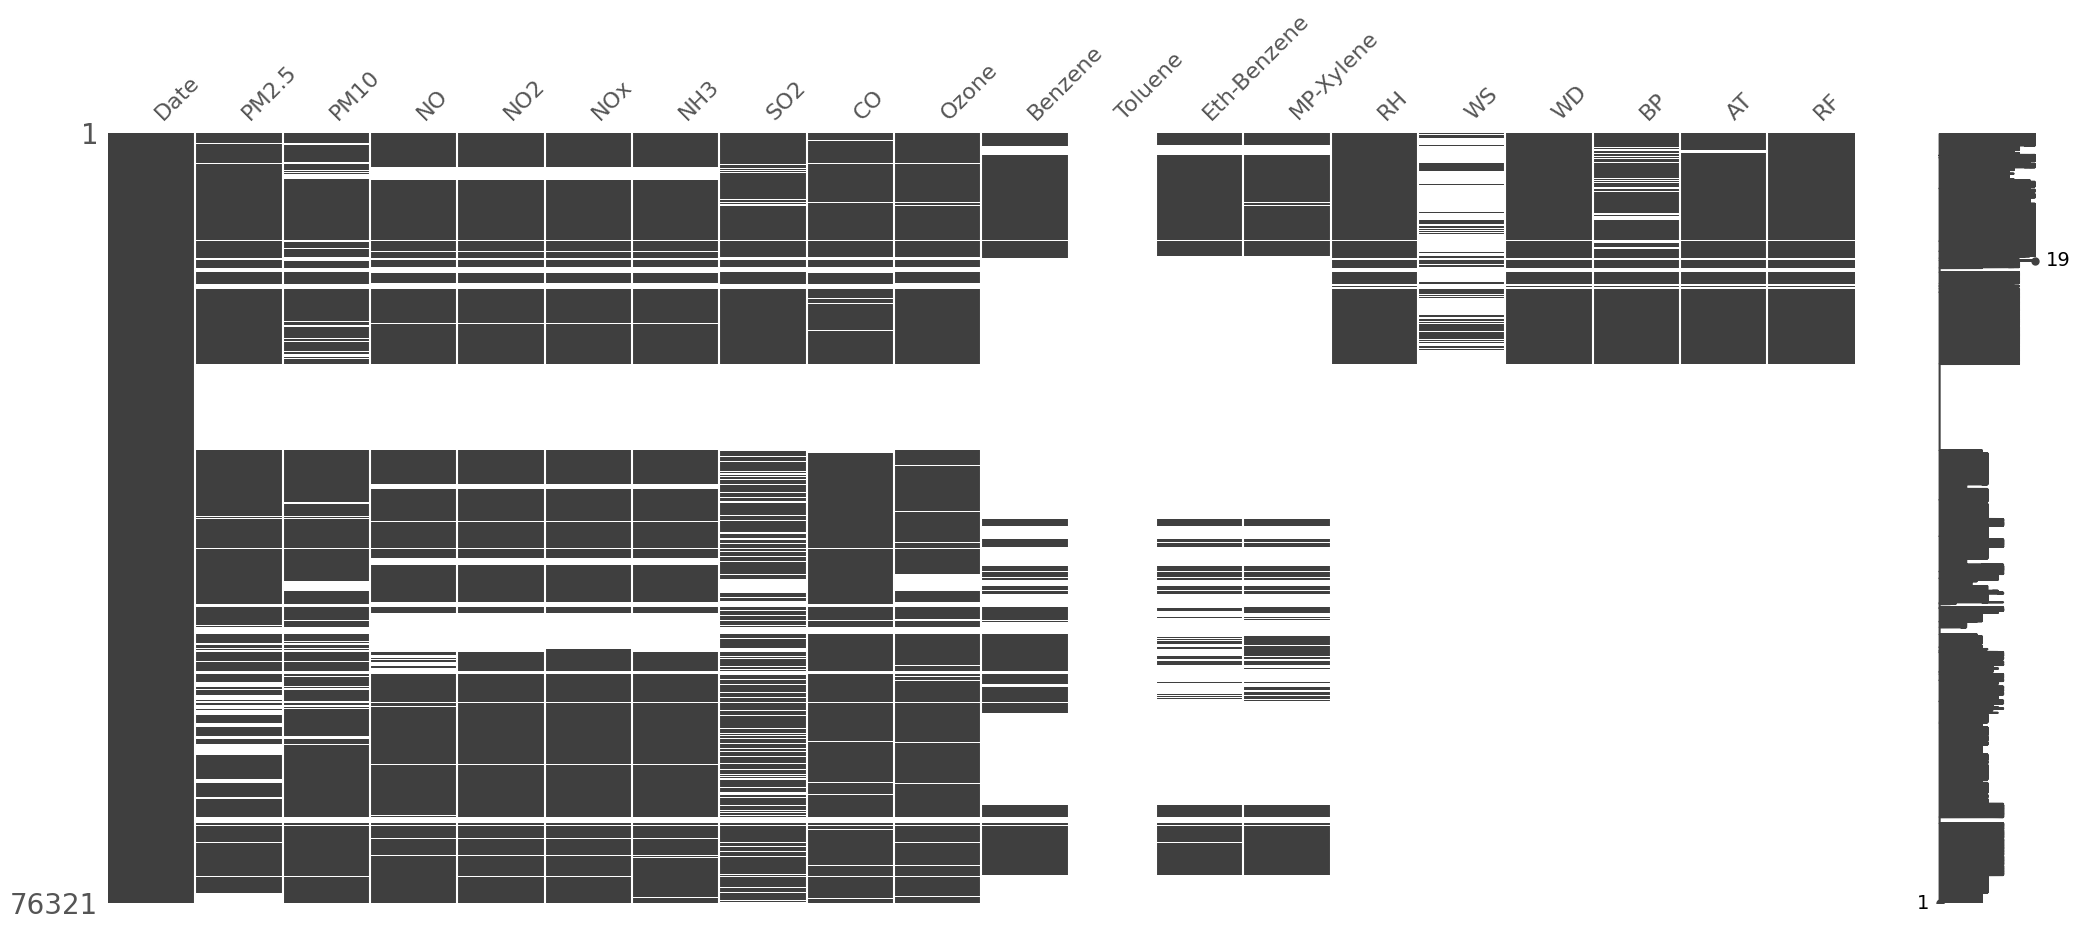

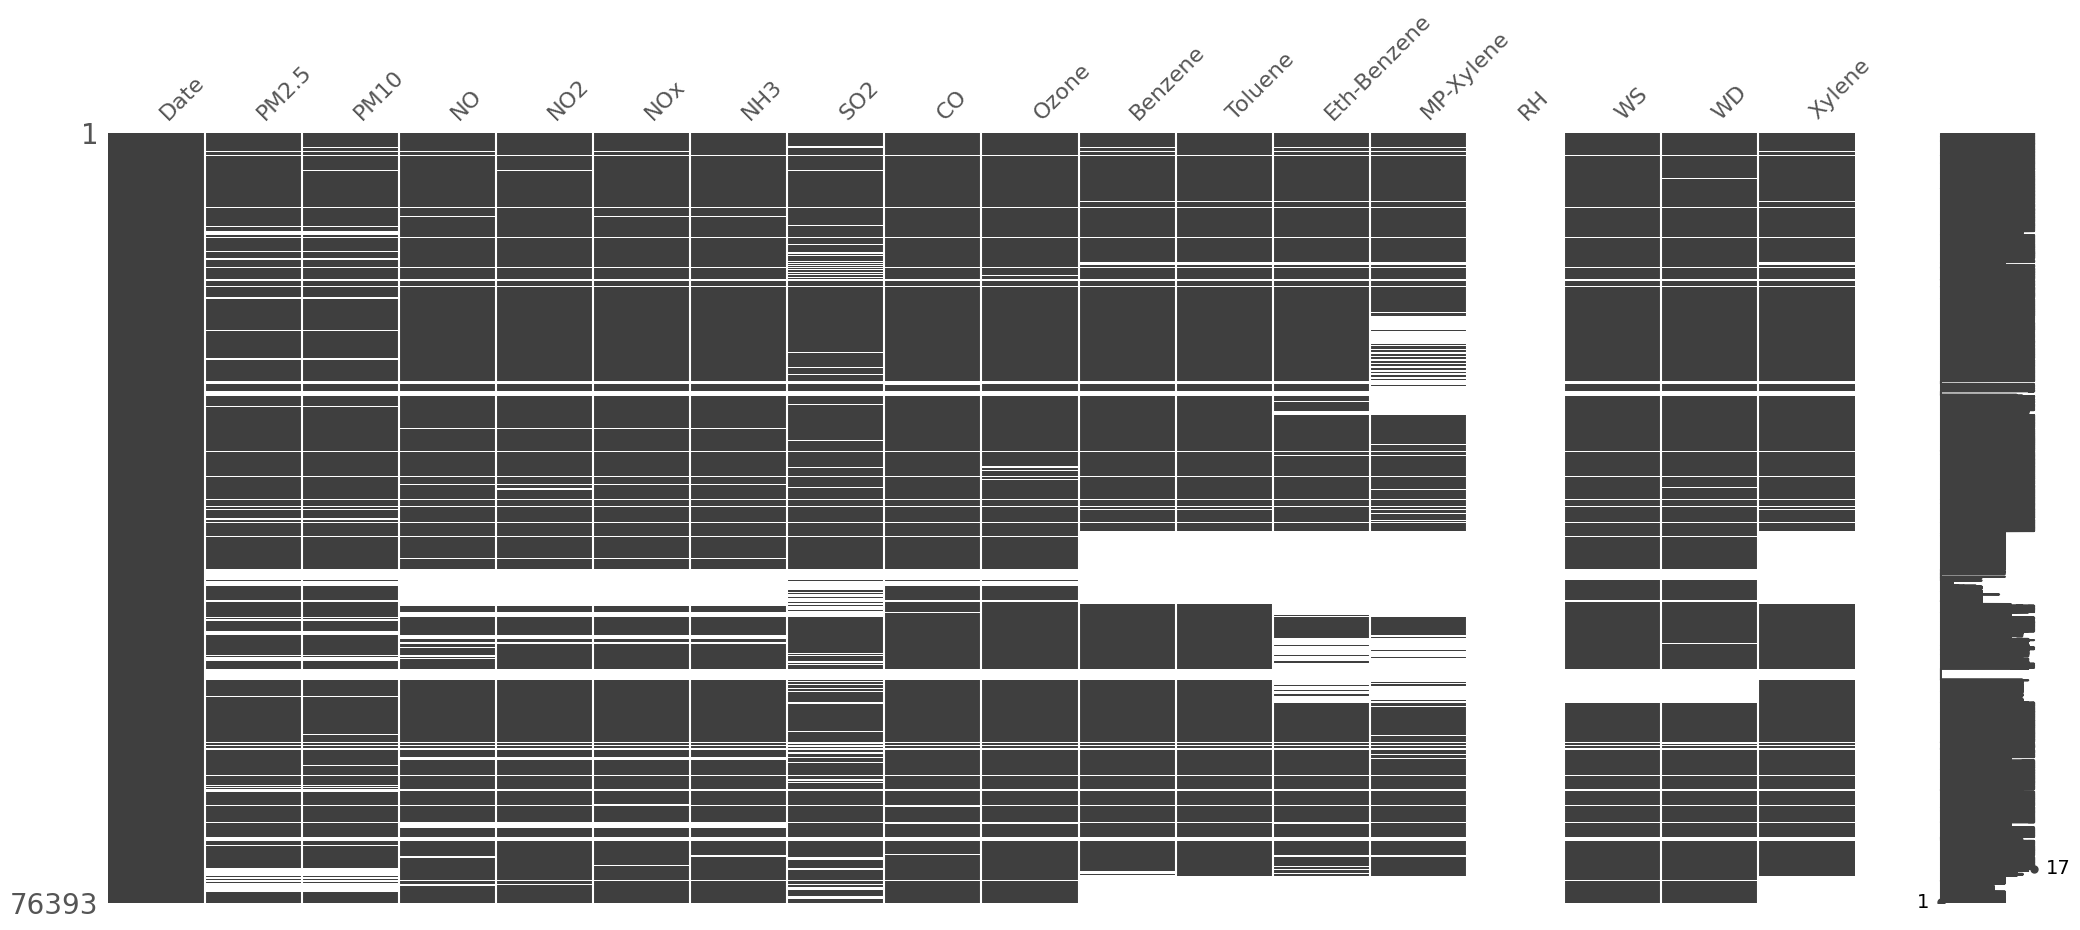

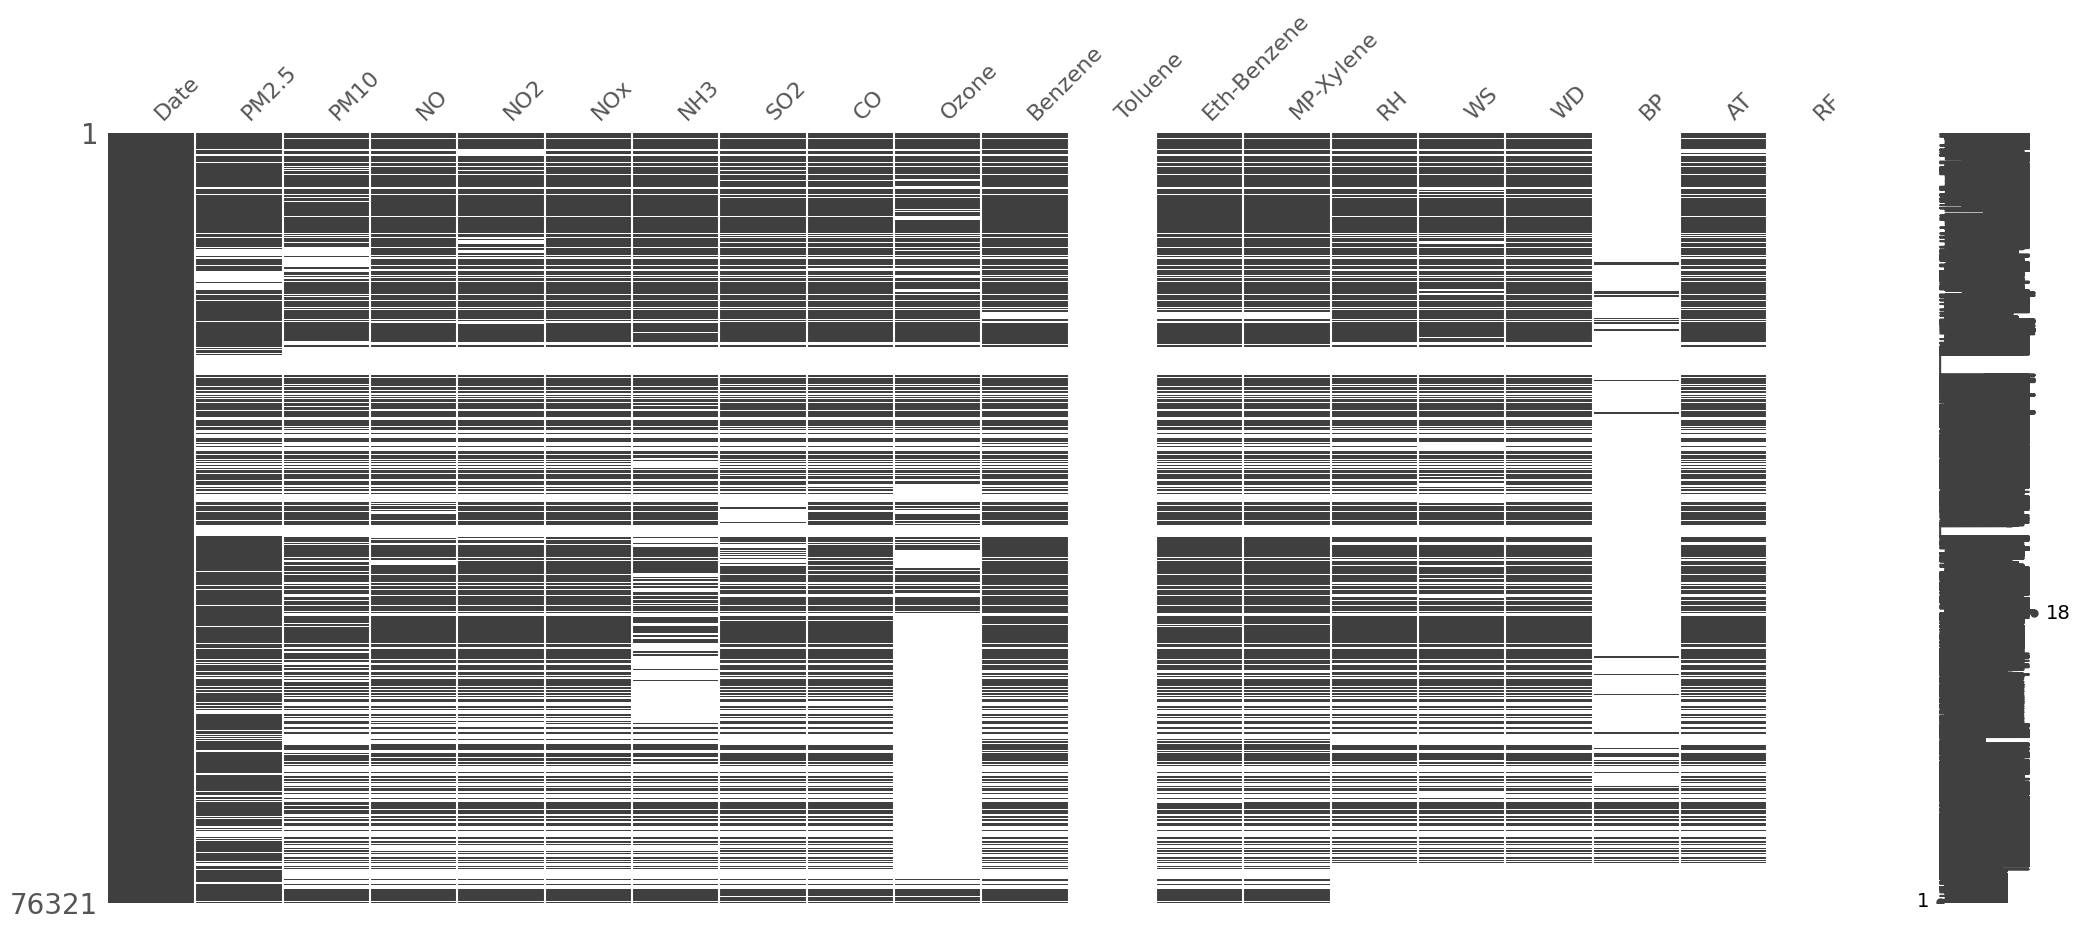

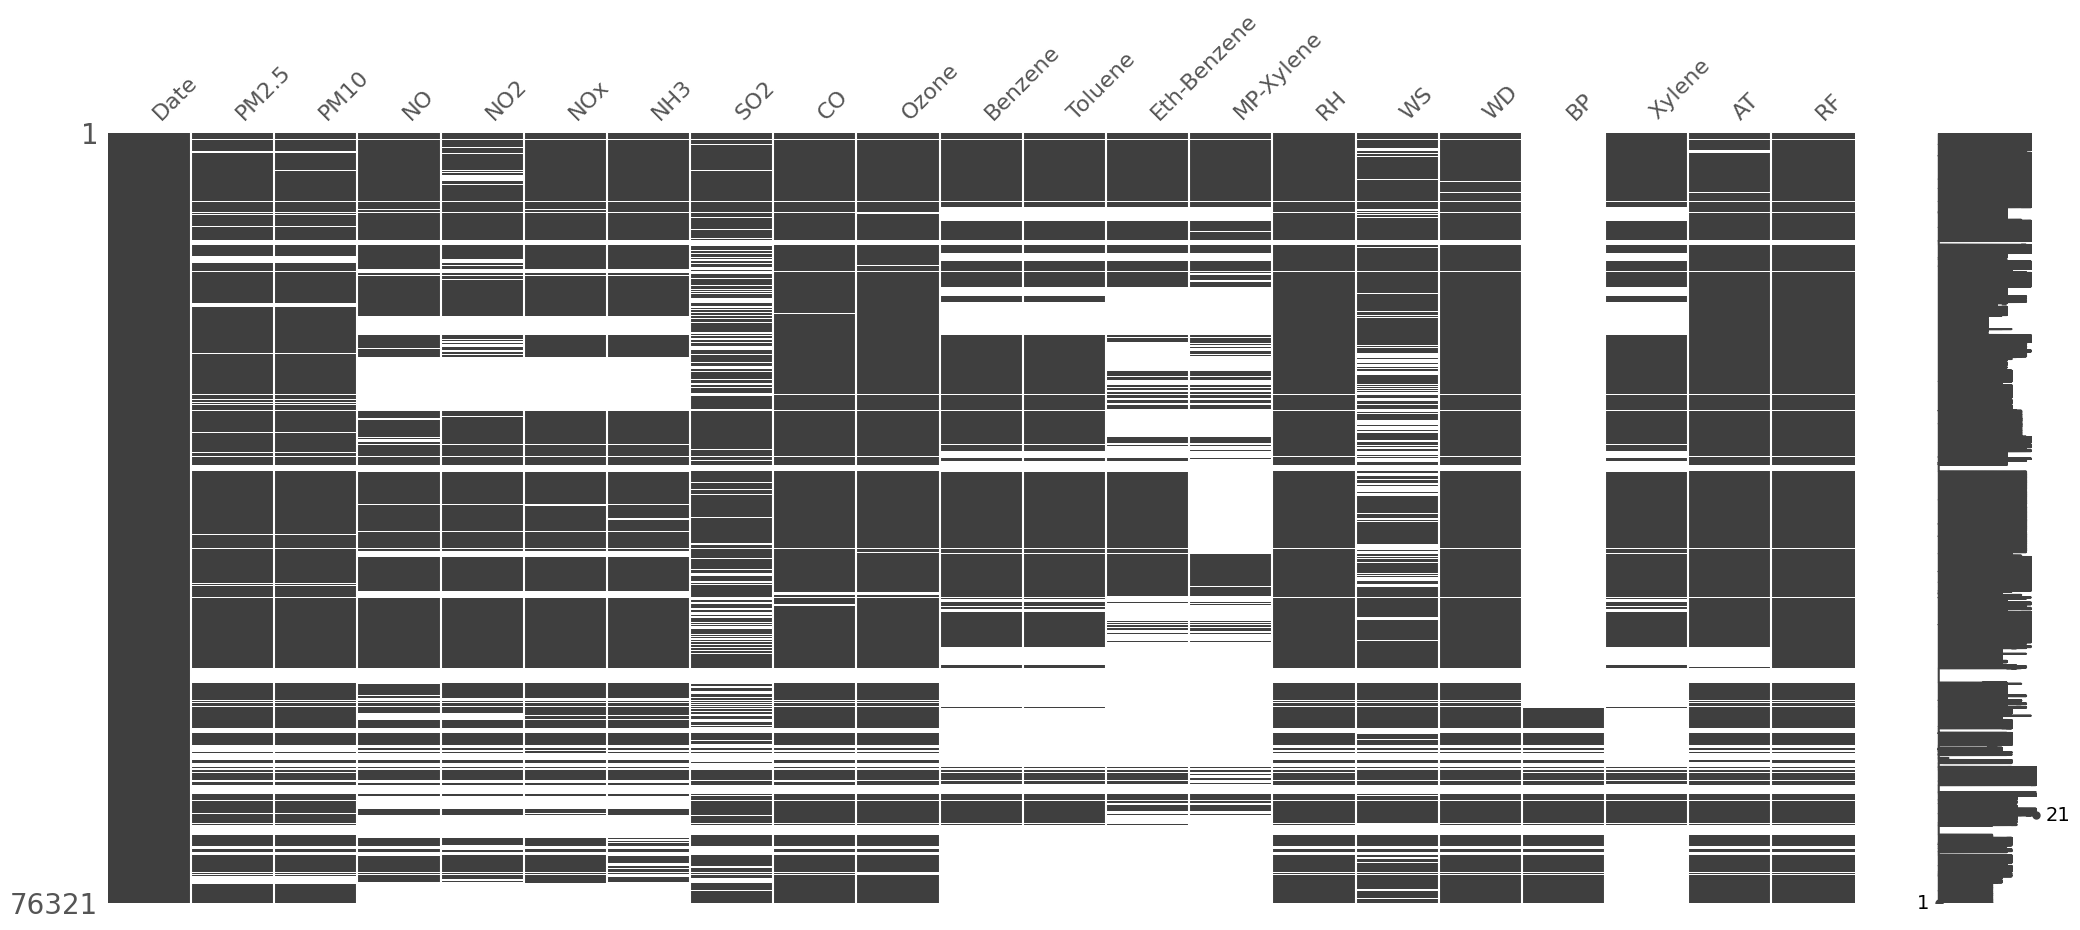

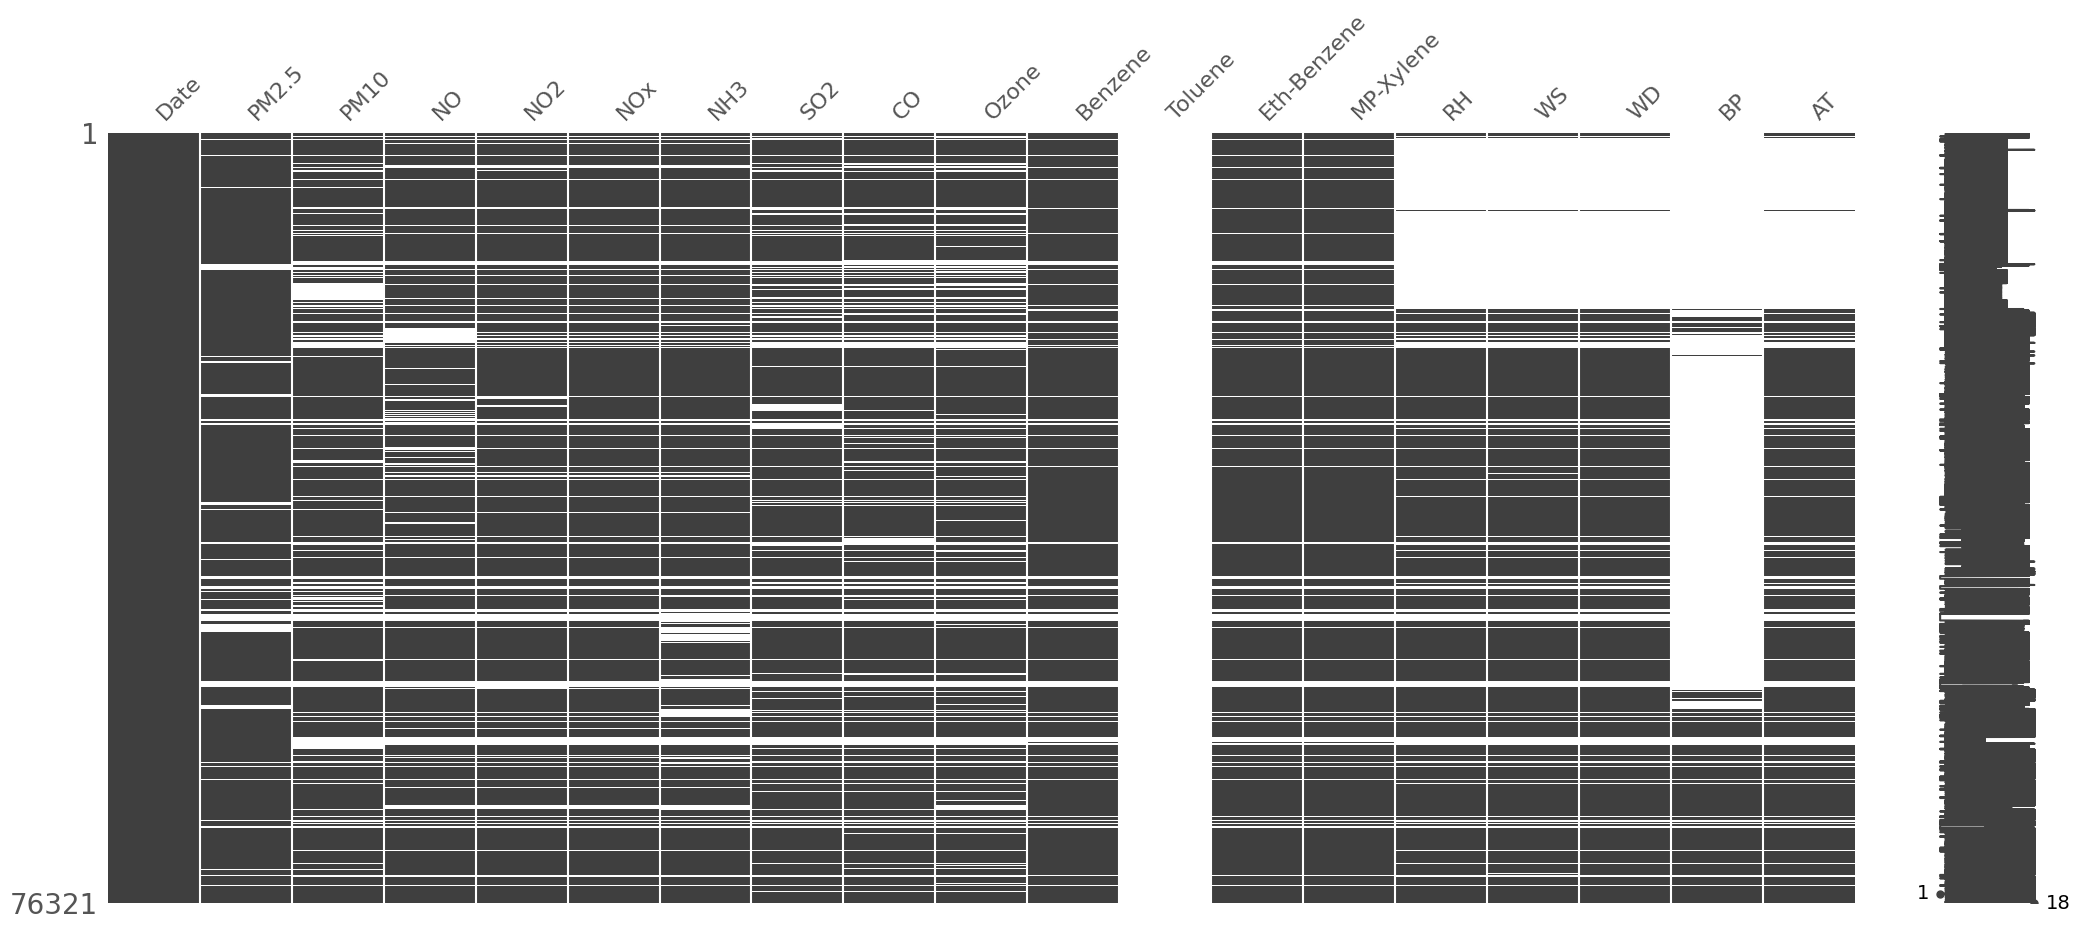

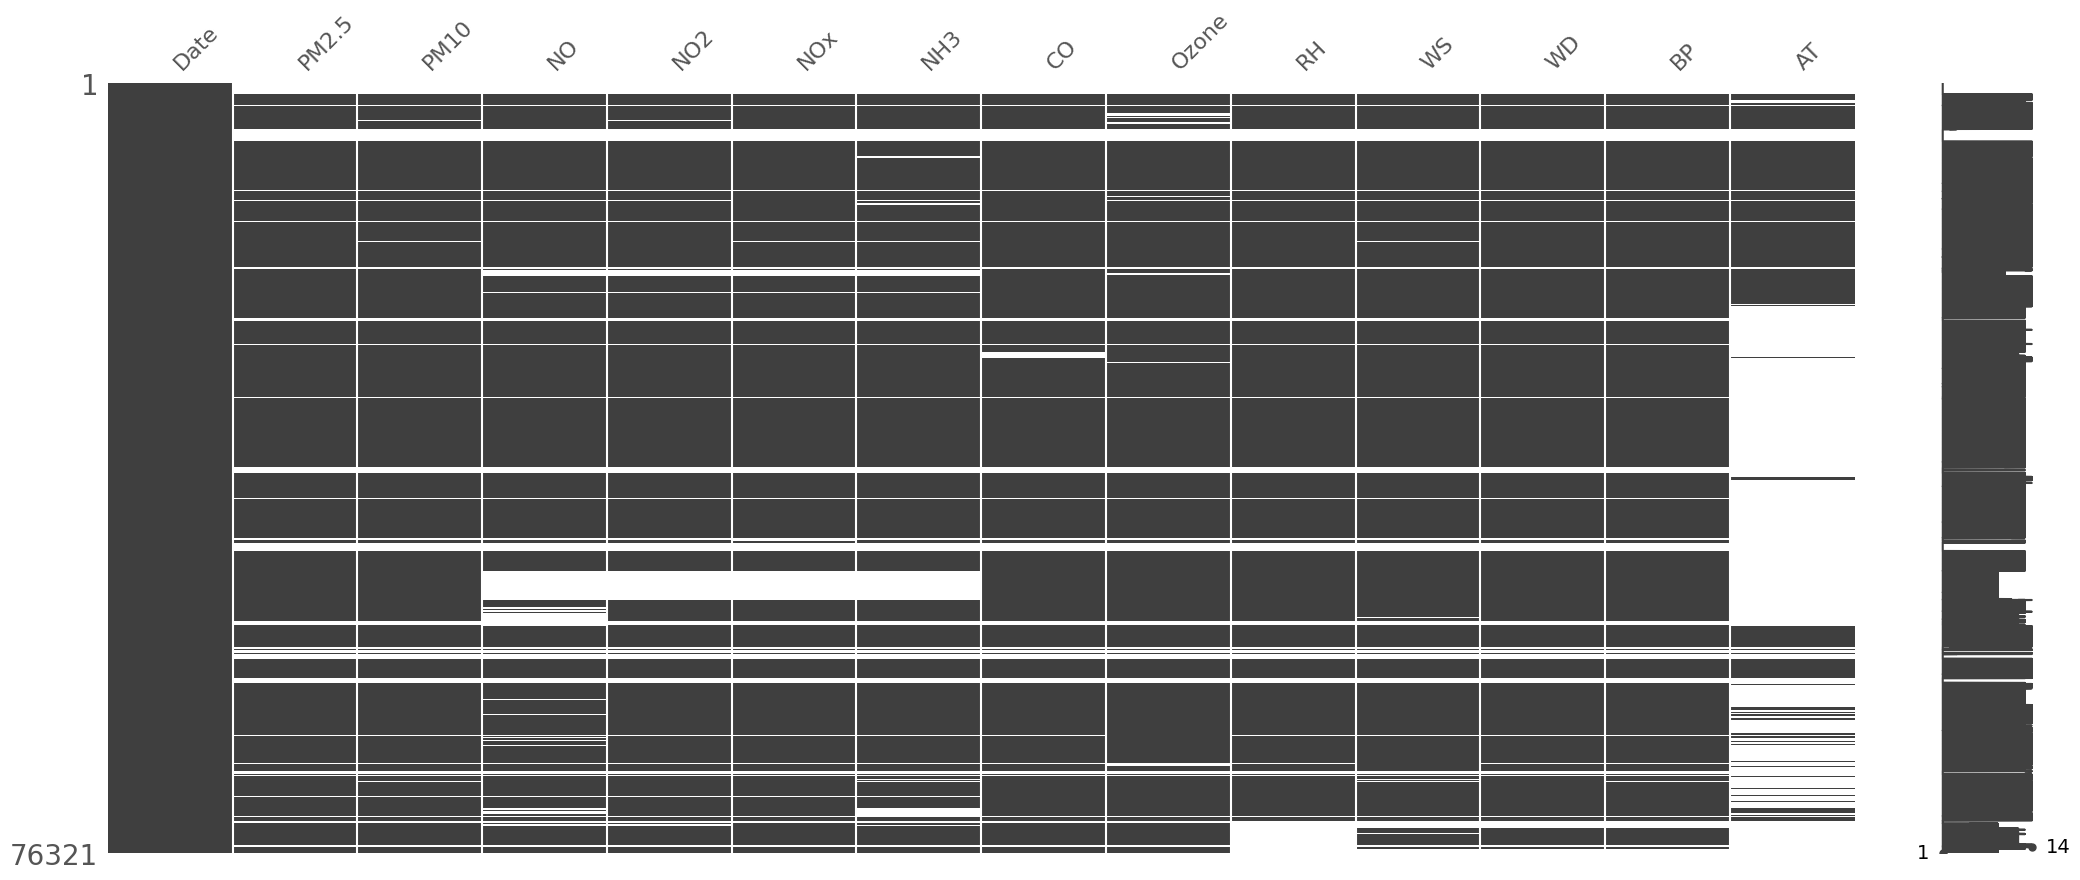

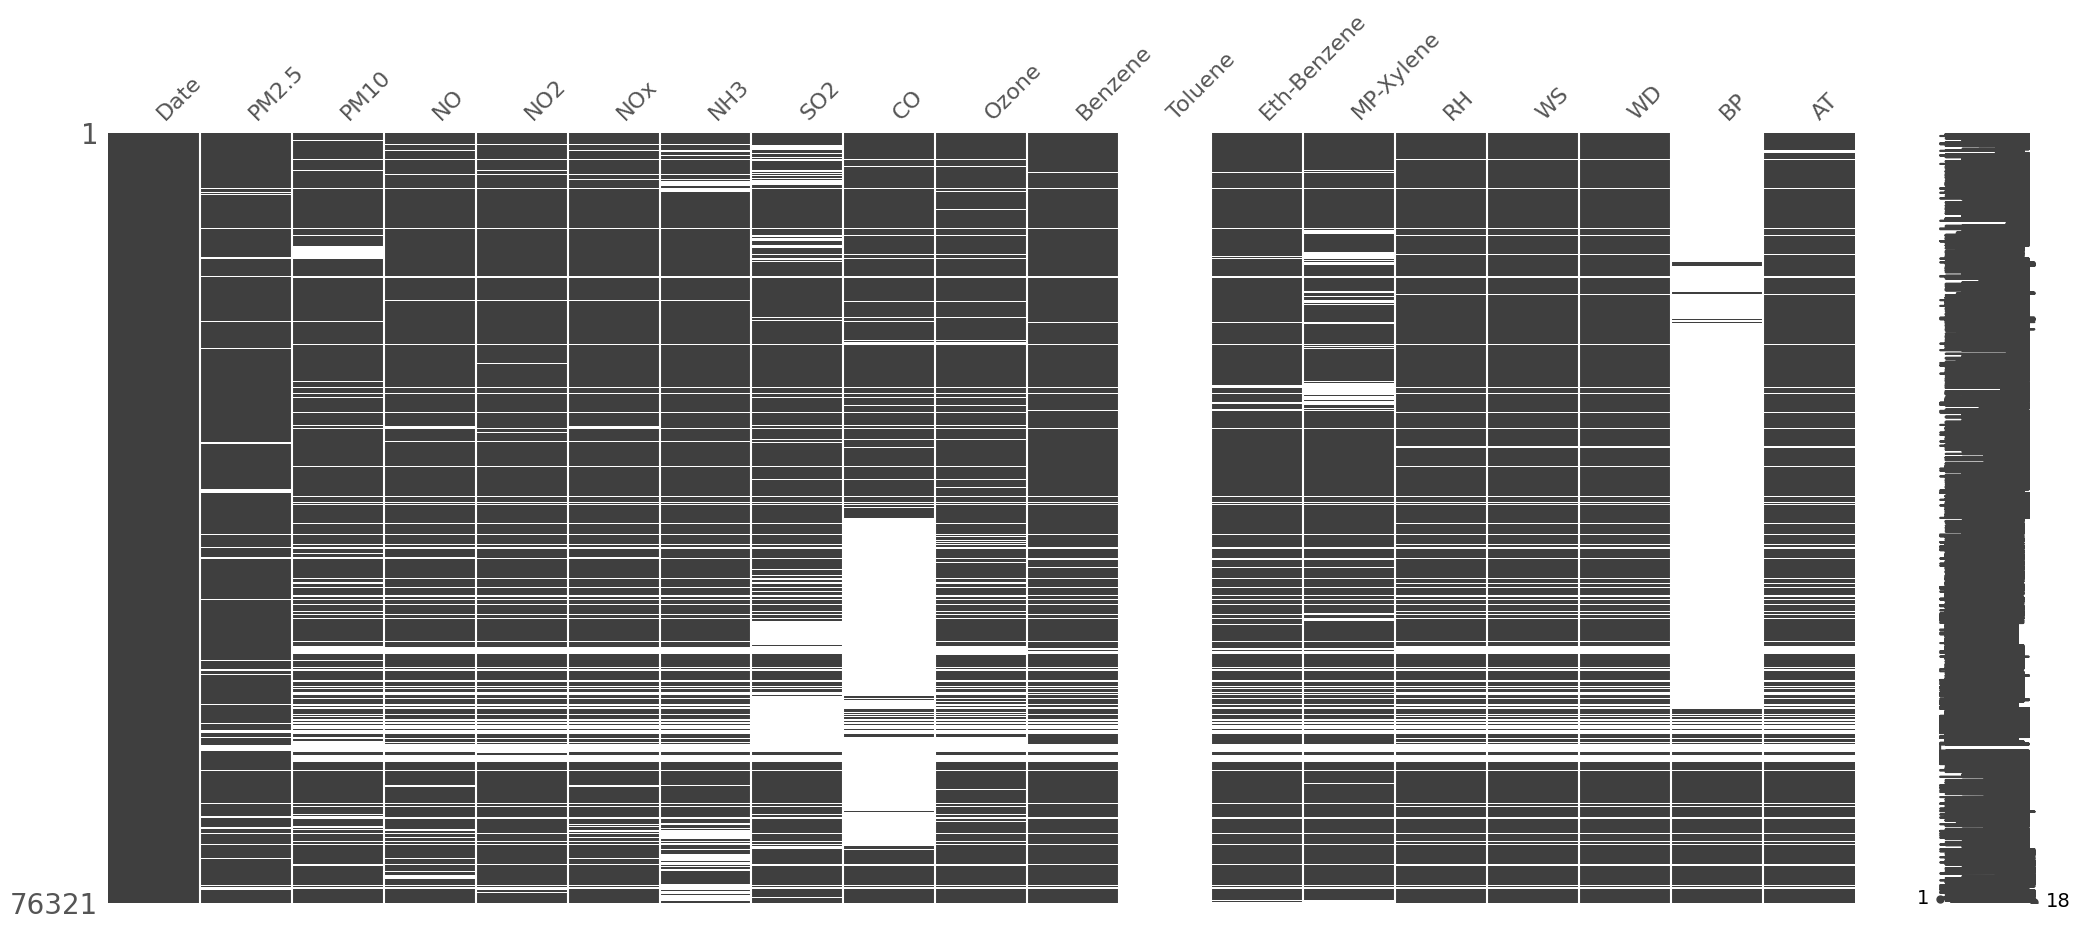

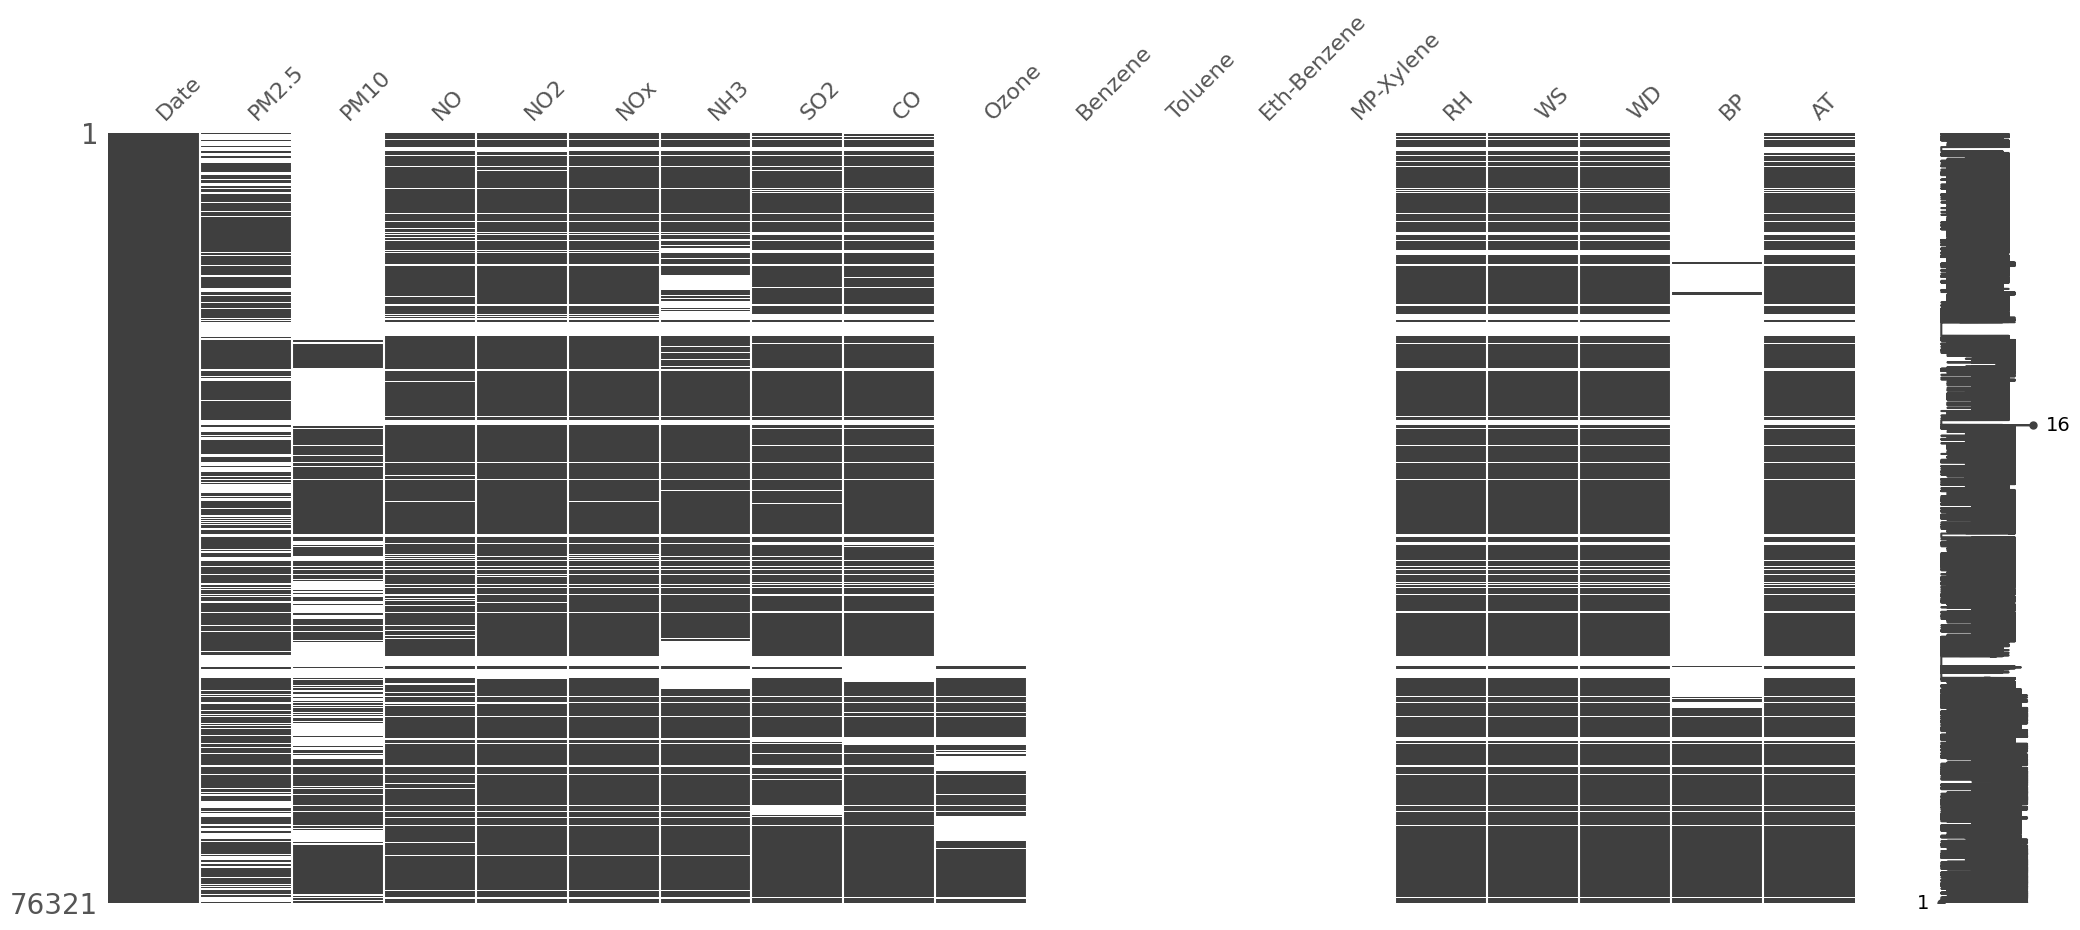

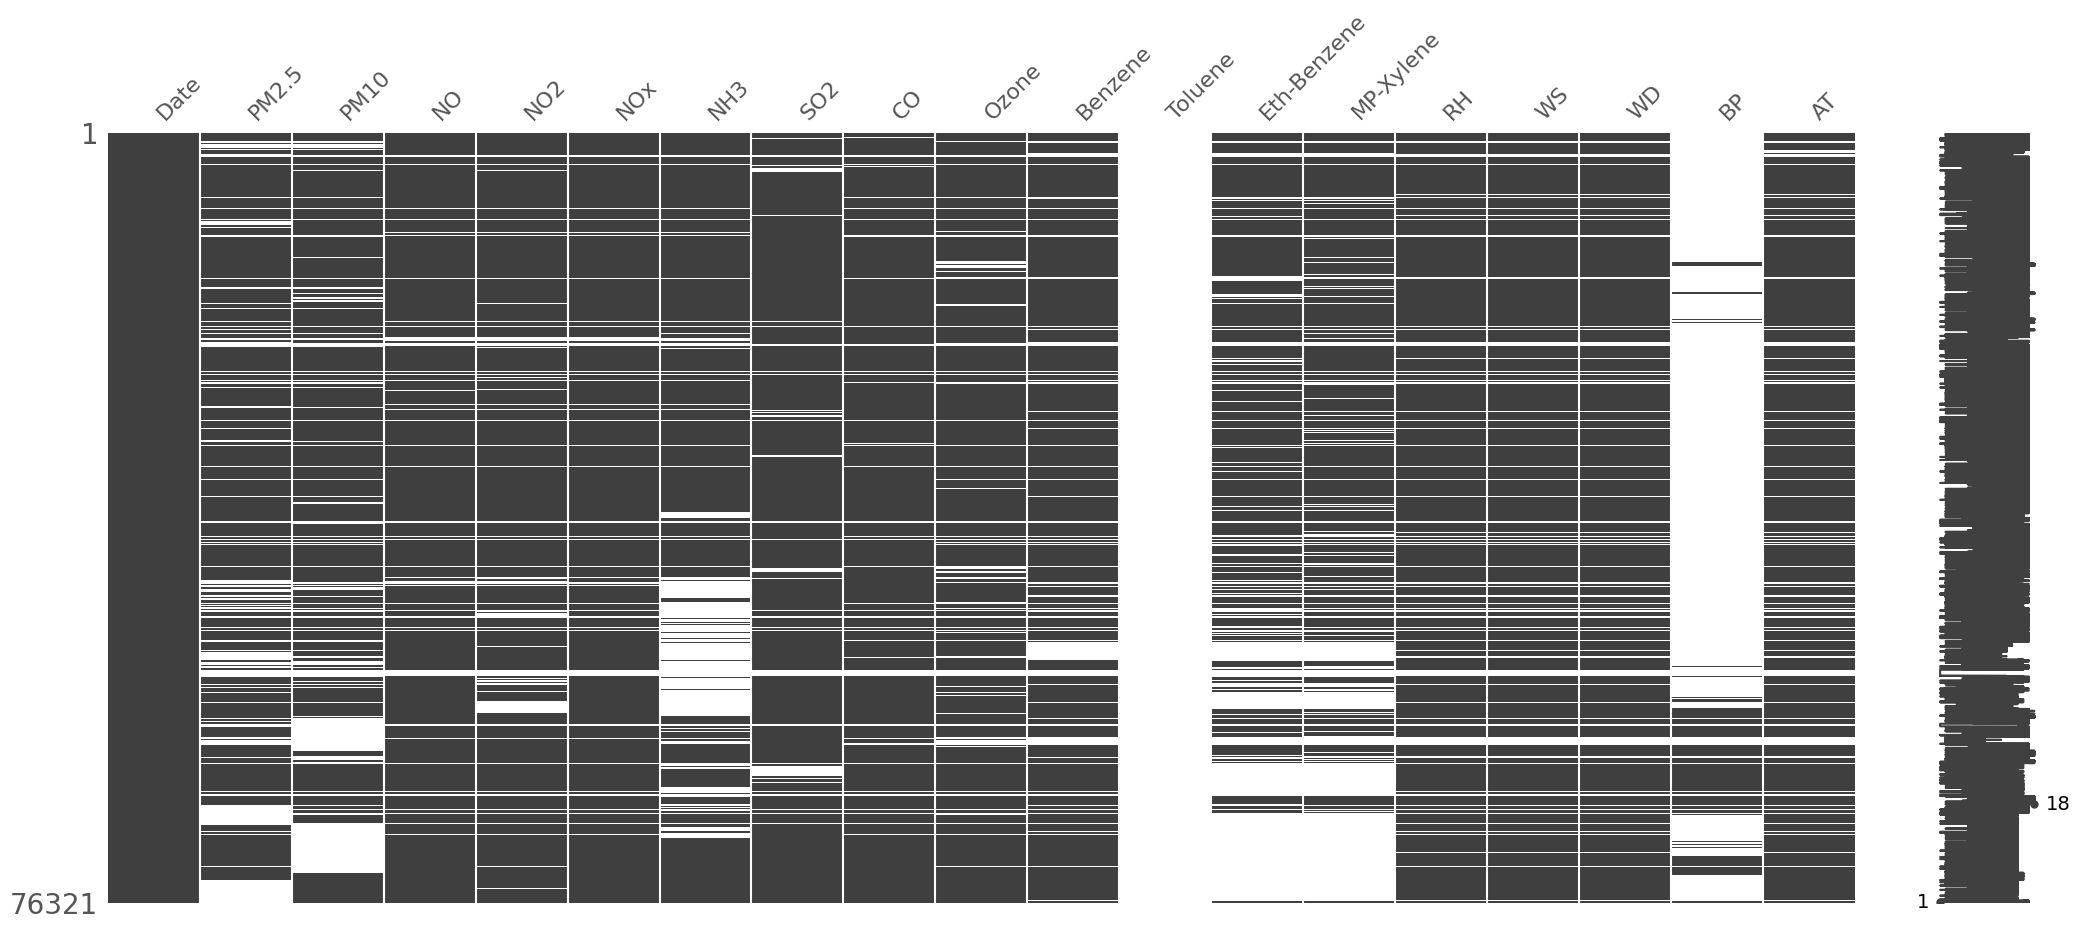

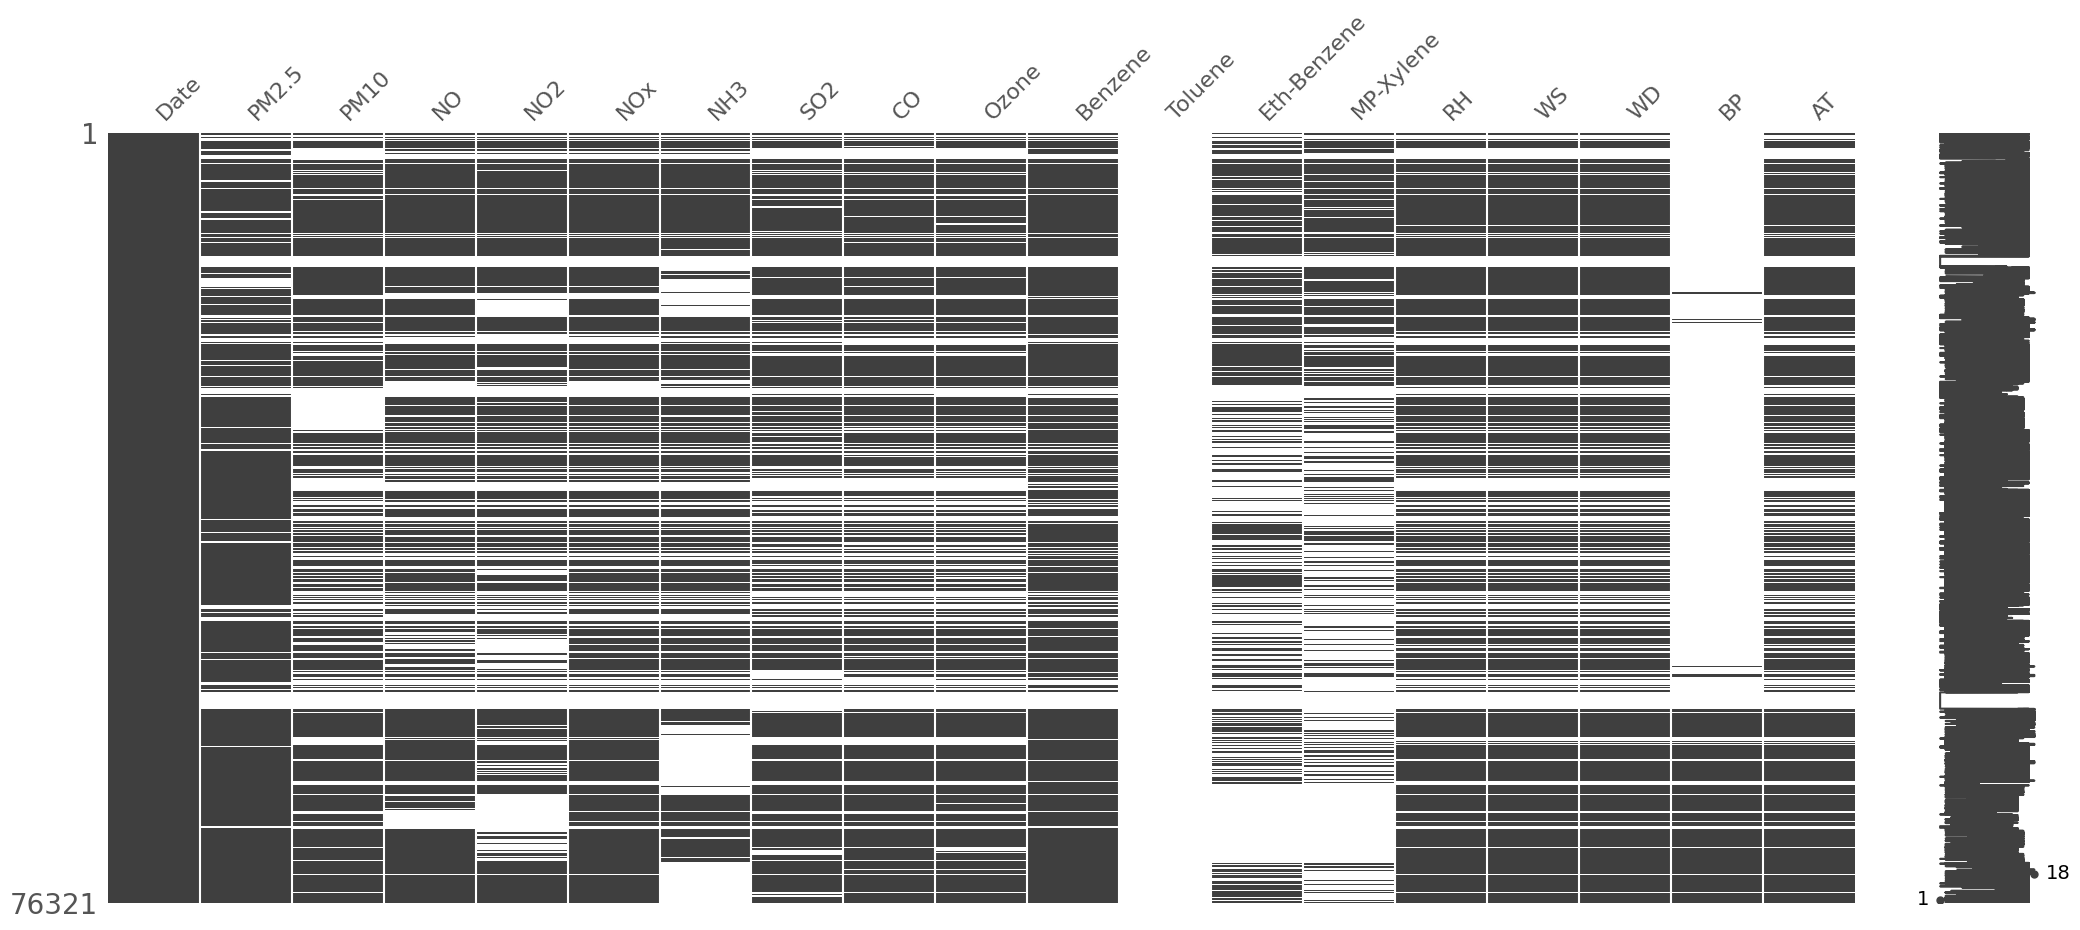

In [19]:
for keys in data_dict.keys(): 
    msno.matrix(data_dict[keys])

### Checking Outliers

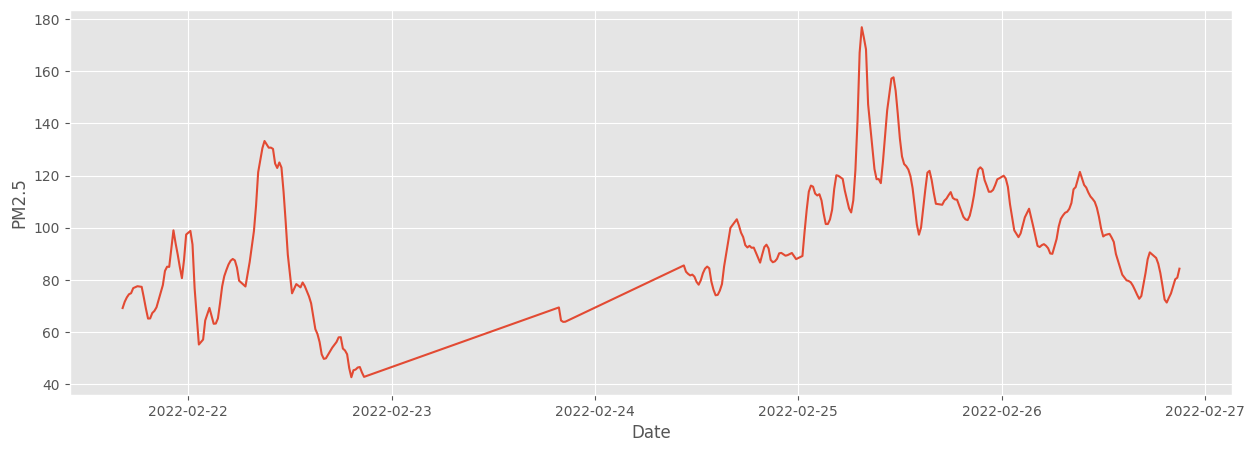

In [20]:
# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(15, 5))
 
# drawing the plot
# Plot the responses for different events and regions

graph = sns.lineplot(x="Date", y="PM2.5", ax=ax, data=data_dict['BandraKurlaComplexMumbaiIITM'][40000:40500])


<Axes: xlabel='Date'>

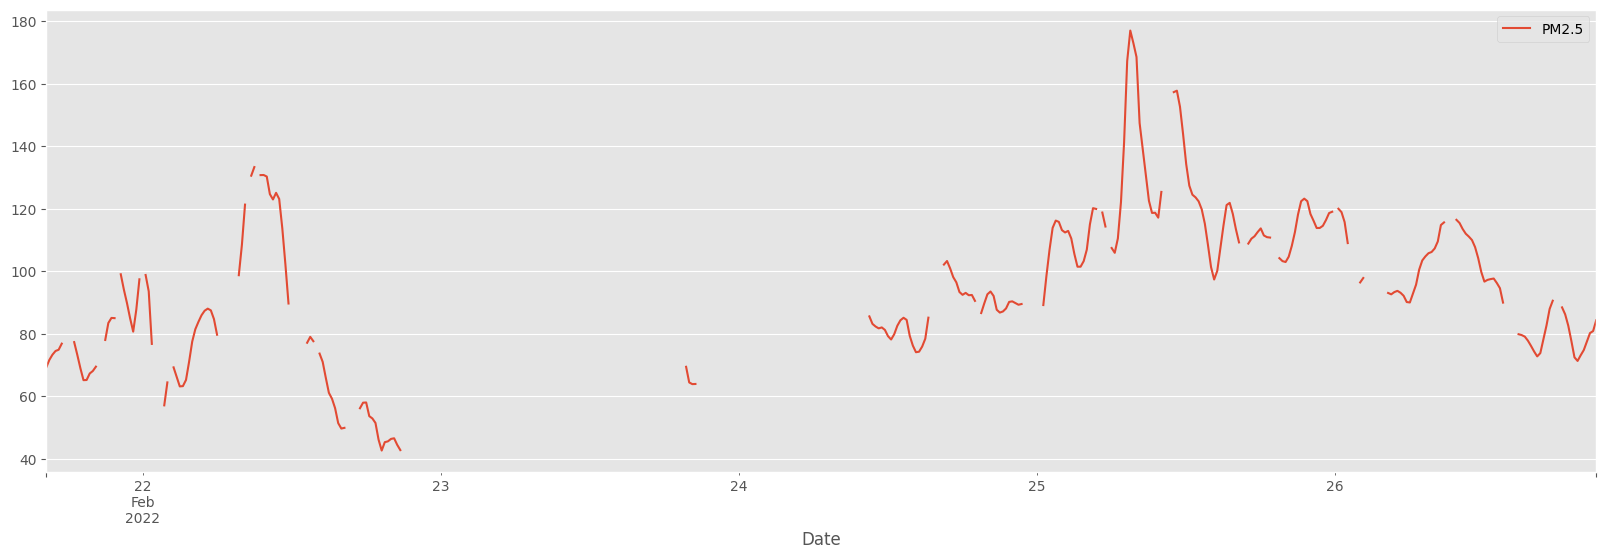

In [21]:
data_dict['BandraKurlaComplexMumbaiIITM'][['Date','PM2.5']][40000:40500].set_index('Date').plot()

<Axes: xlabel='Date'>

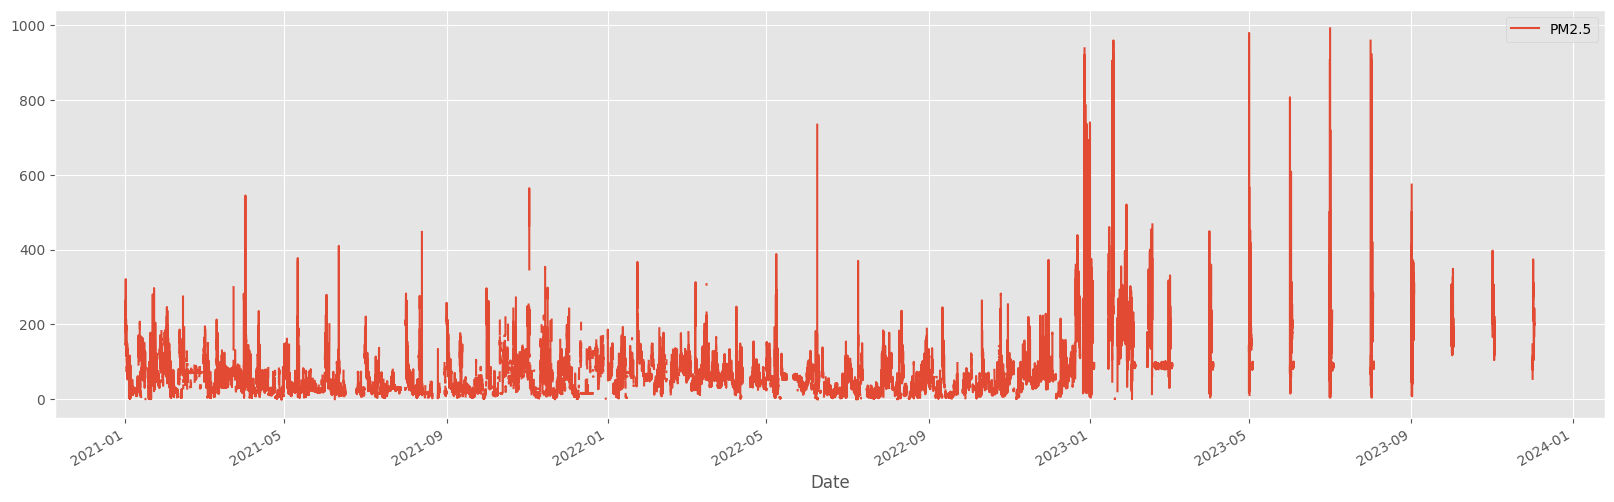

In [22]:
data_dict['BandraKurlaComplexMumbaiIITM'][['Date','PM2.5']].set_index('Date').plot()

## Imputation 

Ref: https://www.kaggle.com/code/juejuewang/handle-missing-values-in-time-series-for-beginners

To decide on the best imputation strategy, mask out some values from the original data, and impute them. Find the mean square error between the ground truth data and the imputed data. The strategy that gives the lowest MSE can be chosen. 

Note, the final decision will be based on model performance. This is an ad-hoc method until we start modelling.

### Create a masked dataset 

In [23]:
df = data_dict['KurlaMumbaiMPCB']
df_pm25 = df[['Date', 'PM2.5']].copy()

Missing data visualised for a sample

<Axes: xlabel='Date'>

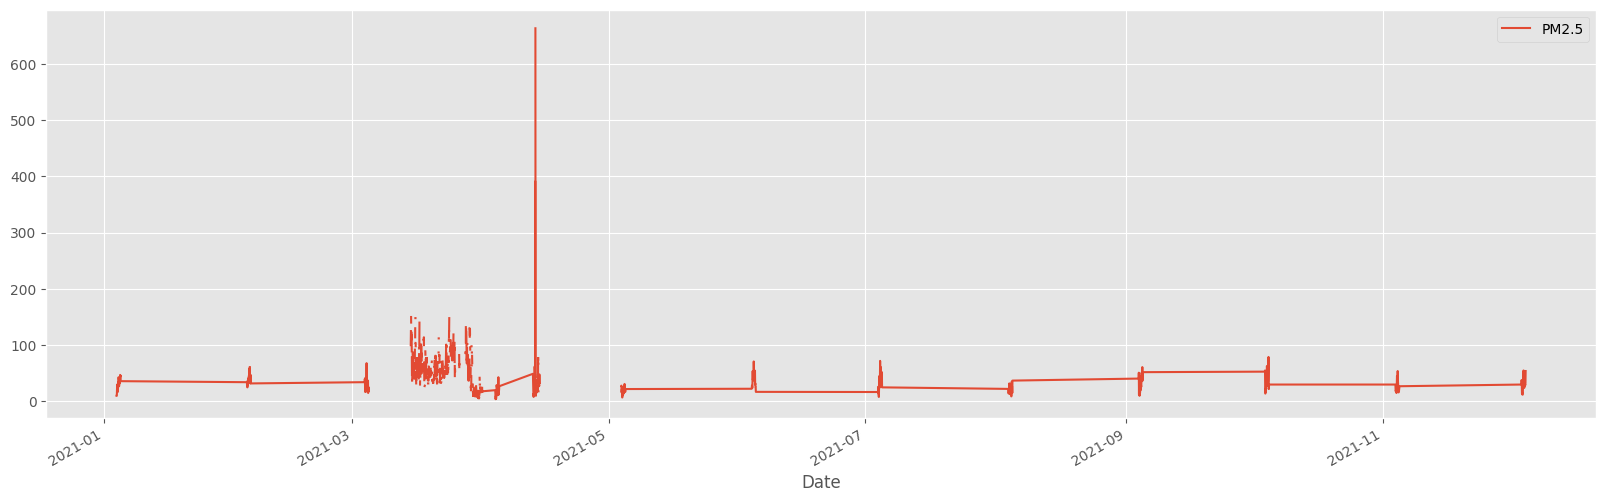

In [24]:
df_pm25[7000:10000].set_index('Date').plot()

Randomly set 10% of data as missing.

In [25]:
# get the list of indices of non-empty rows 
res = np.where(np.isnan(df['PM2.5']) == False)[0]
random.seed(42)
res_mask = random.sample(list(res), int(0.1*len(res)))
df_pm25_masked = df_pm25.copy()
df_pm25_masked.loc[res_mask, 'PM2.5'] = np.NaN

### Median Imputation

In [26]:
imp = SimpleImputer(missing_values=np.nan, strategy='median')
col_pm = df_pm25_masked['PM2.5'].values.reshape(-1, 1)
imputed_col_pm = imp.fit_transform(col_pm)
df_pm25_imputed = df_pm25_masked.copy()
df_pm25_imputed.loc[:,'PM2.5'] = imputed_col_pm

<Axes: xlabel='Date'>

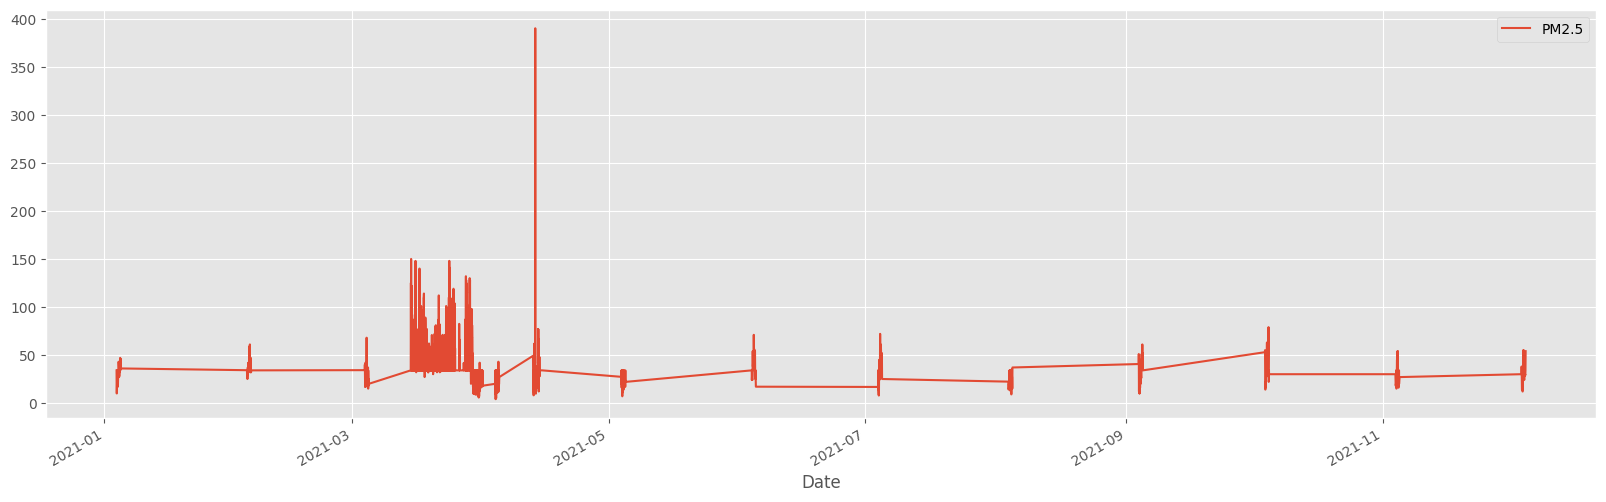

In [27]:
df_pm25_imputed[7000:10000].set_index('Date').plot()

In [28]:
x1 = df_pm25.loc[res_mask, 'PM2.5']
x2 = df_pm25_imputed.loc[res_mask, 'PM2.5']
mse = mean_squared_error(x1, x2)
mse

1787.7371824216577

### Mean Imputation

In [29]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_col_pm = imp.fit_transform(col_pm)
df_pm25_imputed.loc[:,'PM2.5'] = imputed_col_pm

<Axes: xlabel='Date'>

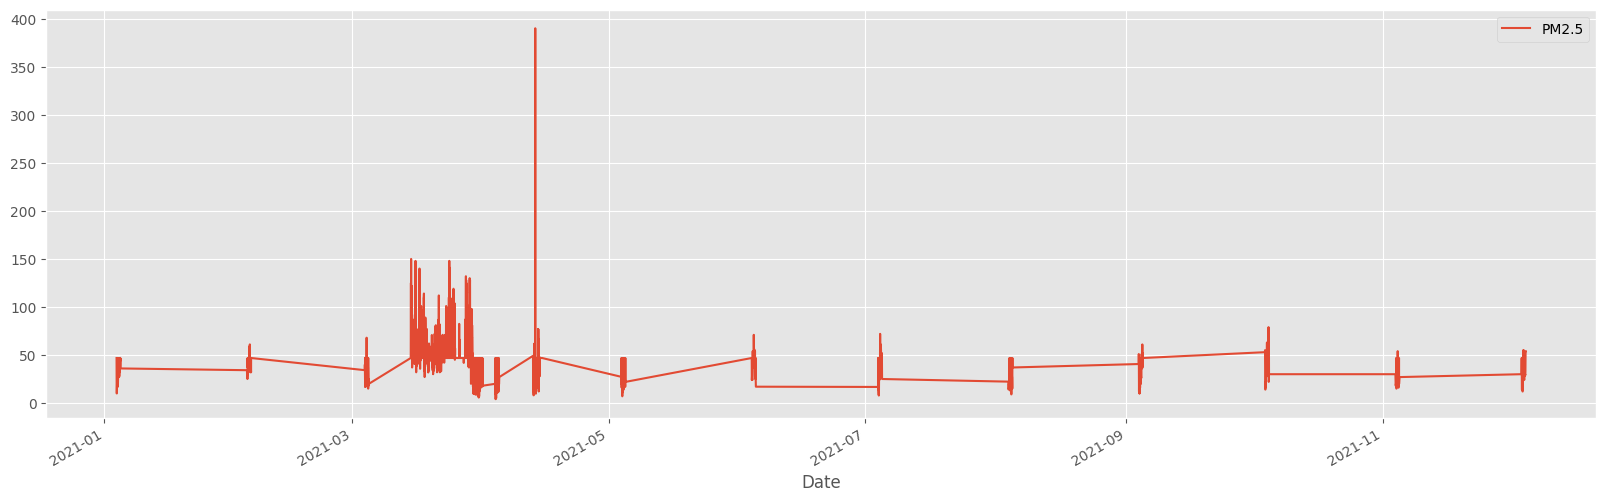

In [30]:
df_pm25_imputed[7000:10000].set_index('Date').plot()

In [31]:
x1 = df_pm25.loc[res_mask, 'PM2.5']
x2 = df_pm25_imputed.loc[res_mask, 'PM2.5']
mse = mean_squared_error(x1, x2)
mse

1603.4974083671582

### LOCF (Last Observation Carry Forward) or Forward Fill Imputation

In [32]:
df_pm25_imputed = df_pm25_masked.ffill()

<Axes: xlabel='Date'>

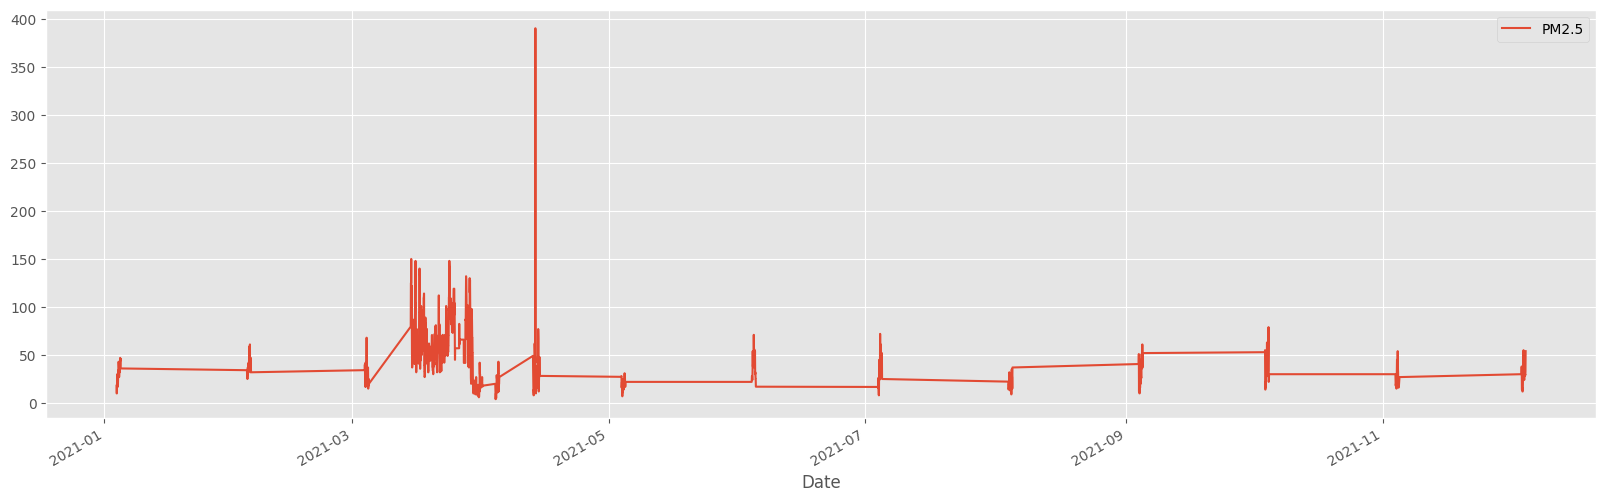

In [33]:
df_pm25_imputed[7000:10000].set_index('Date').plot()

In [34]:
x1 = df_pm25.loc[res_mask, 'PM2.5']
x2 = df_pm25_imputed.loc[res_mask, 'PM2.5']
mse = mean_squared_error(x1, x2)
mse

271.3146165585017

### NOBF (Next Observation Bring Forward) or Backward Fill Imputation

In [35]:
df_pm25_imputed = df_pm25_masked.bfill()

<Axes: xlabel='Date'>

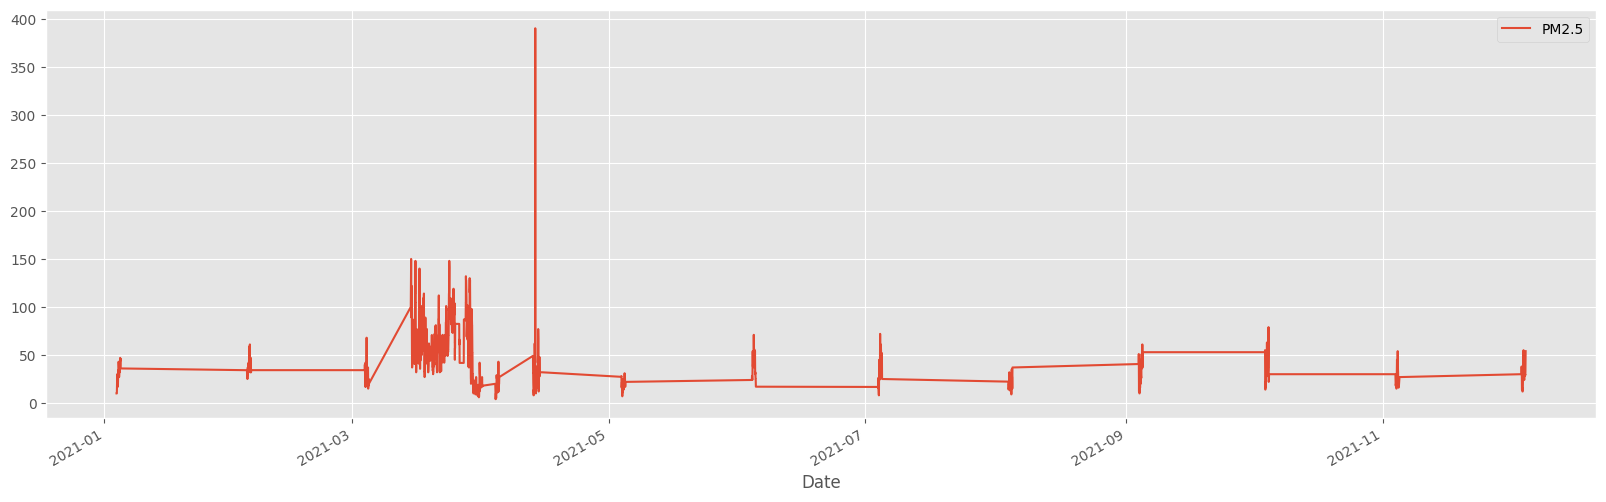

In [36]:
df_pm25_imputed[7000:10000].set_index('Date').plot()

In [37]:
x1 = df_pm25.loc[res_mask, 'PM2.5']
x2 = df_pm25_imputed.loc[res_mask, 'PM2.5']
mse = mean_squared_error(x1, x2)
mse

280.6047127572779

### Linear interpolation

In [38]:
ts = pd.Series(df_pm25_masked['PM2.5'])
ts_interpolated = ts.interpolate(method='linear', limit_direction='forward')
df_pm25_imputed.loc[:,'PM2.5'] = ts_interpolated

<Axes: xlabel='Date'>

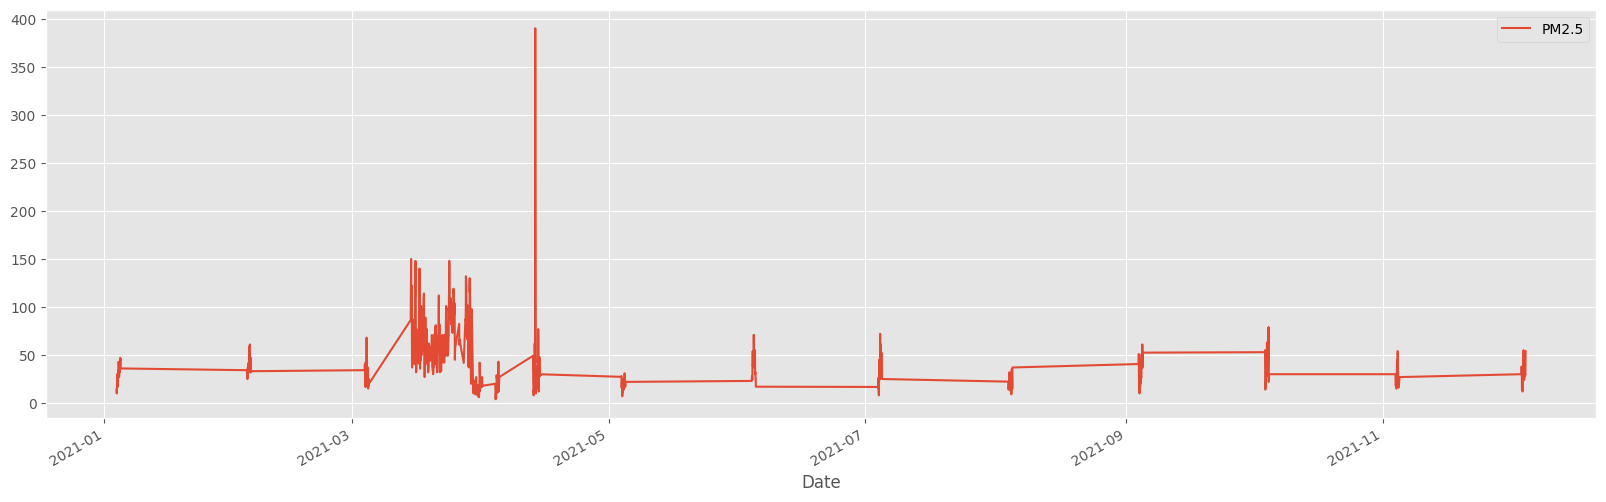

In [39]:
df_pm25_imputed[7000:10000].set_index('Date').plot()

In [40]:
x1 = df_pm25.loc[res_mask, 'PM2.5']
x2 = df_pm25_imputed.loc[res_mask, 'PM2.5']
mse = mean_squared_error(x1, x2)
mse

144.91196256333657

Impute MSE for all stations

In [41]:
def impute_eval(df):
    df_mse = pd.DataFrame(index=df.columns[1:], columns=['Median', 'Mean', 'Forward Fill', 'Backward Fill', 'Linear Interpolation'])

    for i in range(len(df.columns)-1): 
        col = df.columns[i+1]
        # create masked data
        df_col = df[['Date', col]].copy()
       
        # get the list of indices of non-empty rows 
        res = np.where(np.isnan(df[col]) == False)[0]
        if len(res) == 0: 
            continue

        random.seed(42)
        res_mask = random.sample(list(res), int(0.1*len(res)))
        if len(res_mask) == 0: 
            continue
        
        df_col_masked = df_col.copy()
        df_col_masked.loc[res_mask, col] = np.NaN

        df_col_imputed = df_col_masked.copy()

        #median imputation
        imp = SimpleImputer(missing_values=np.nan, strategy='median')
        col_val = df_col_masked[col].values.reshape(-1, 1)
        imputed_col_val = imp.fit_transform(col_val)
        df_col_imputed.loc[:,col] = imputed_col_val

        x1 = df_col.loc[res_mask, col]
        x2 = df_col_imputed.loc[res_mask, col]
        mse_median = mean_squared_error(x1, x2)

        #mean imputation 
        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        col_val = df_col_masked[col].values.reshape(-1, 1)
        imputed_col_val = imp.fit_transform(col_val)
        df_col_imputed.loc[:,col] = imputed_col_val

        x1 = df_col.loc[res_mask, col]
        x2 = df_col_imputed.loc[res_mask, col]
        mse_mean = mean_squared_error(x1, x2)

        #forward fill
        df_col_imputed = df_col_masked.ffill()
        df_col_imputed = df_col_imputed.replace(np.NaN, 0)
        x1 = df_col.loc[res_mask, col]
        x2 = df_col_imputed.loc[res_mask, col]
        mse_fwdfill = mean_squared_error(x1, x2)

        #backward fill 
        df_col_imputed = df_col_masked.bfill()
        df_col_imputed = df_col_imputed.replace(np.NaN, 0)
        x1 = df_col.loc[res_mask, col]
        x2 = df_col_imputed.loc[res_mask, col]
        mse_bwdfill = mean_squared_error(x1, x2)

        #linear interpolation
        ts = pd.Series(df_col_masked[col])
        ts_interpolated = ts.interpolate(method='linear', limit_direction='forward')
        df_col_imputed.loc[:,col] = ts_interpolated

        x1 = df_col.loc[res_mask, col]
        x2 = df_col_imputed.loc[res_mask, col]
        mse_interp = mean_squared_error(x1, x2)

        #print(f'[{col}]: {len(res)}, {len(res_mask)}, mean:{mse_mean: .2f}, median:{mse_median: .2f}, ffill:{mse_fwdfill: .2f}, bfill:{mse_bwdfill: .2f}, interp:{mse_interp: .2f}')
        df_mse.loc[col,:] = [mse_median, mse_mean, mse_fwdfill, mse_bwdfill, mse_interp]
    return df_mse
    

In [42]:
df_all_mse = []
for key in data_dict.keys(): 
    df_mse = impute_eval(data_dict[key])
    df_all_mse.append(df_mse)

In [43]:
mse_dict = dict(zip(station_names, df_all_mse))

In [44]:
mse_dict['KurlaMumbaiMPCB']

Median          Mean  Forward Fill Backward Fill  \
PM2.5         1787.737182   1603.497408    271.314617    280.604713   
PM10         18237.037151  17755.613225   3456.589675   3071.322013   
NO             2082.93122   1905.273024    337.352144     308.85789   
NO2           1458.666331   1344.958504    191.684111    164.007526   
NOx           2737.843566   2620.697797    488.948131    475.000968   
NH3            155.242319    146.726227      8.454519      9.577523   
SO2            951.030259    776.425196       7.09267      6.941527   
CO               0.280045      0.258248      0.014742      0.017483   
Ozone         1119.988809   1085.964193     60.716111     77.507279   
Benzene          9.087019      8.244706     14.154864      8.813043   
Toluene               NaN           NaN           NaN           NaN   
Eth-Benzene     49.235139     44.070717     22.565432     45.130484   
MP-Xylene       55.223185     48.523466      24.08752     40.601491   
RH             342.720038    337.508235      4.676594      5.440401   
WS               0.638765      0.632256      0.221876      0.156444   
WD            6981.372777   5984.272997   1073.112686    1111.51401   
SR           47833.773483   46213.92873  11250.464851  13467.369565   
BP               19.58739     18.970091      0.040922    511.410731   
AT              29.064463     28.110122      0.250444      0.252731   

            Linear Interpolation  
PM2.5                 144.911963  
PM10                  1689.64797  
NO                    138.259977  
NO2                   108.715511  
NOx                   228.177735  
NH3                     3.880808  
SO2                     3.659332  
CO                      0.006566  
Ozone                  35.108684  
Benzene                 6.568211  
Toluene                      NaN  
Eth-Benzene            21.741413  
MP-Xylene              19.036567  
RH                      1.126862  
WS                      0.087198  
WD                    607.247619  
SR                   5833.933343  
BP                      0.004168  
AT                      0.054171

TO DO: 
* Outliers: 
    * Why are maximum values above 500 for PM2.5? 
    * Show box plots for each pollutant across stations 

#### Let study one station at the moment: NavyNagarColabaMumbaiIITM


In [66]:
mse_dict['NavyNagarColabaMumbaiIITM']

Median         Mean Forward Fill Backward Fill  \
PM2.5          3639.44359  3471.490408   309.613107    200.443421   
PM10          8710.351884  8389.904228   650.401122    518.113254   
NO              93.206795    91.877004    47.849507     57.521875   
NO2           1565.274959  1413.503665   123.240058    136.494326   
NOx            212.388127      202.882    34.359865     22.142697   
NH3            850.618092   779.906944   107.393877     89.958428   
SO2            534.354113      474.558    32.306691     33.766049   
CO                0.40846     0.399634     0.012781      0.012215   
Ozone         2323.370415  2000.318638   137.044981    136.413434   
Benzene        121.365199   101.483233    12.123103      5.056739   
Toluene        368.026696   320.877801     6.142268      5.547941   
Eth-Benzene    117.651746   117.640854     1.202493      1.878844   
MP-Xylene       55.214769    48.906753      6.44031      6.031427   
RH             272.556815   263.946007     6.733989      6.331913   
WS               0.583743     0.540387     0.087583      0.079947   
WD           11624.671343  9623.216688  6425.742506   6613.388592   
BP               2.909914     2.875203     0.164896      0.044053   
Xylene           19.02468    14.566363     1.552469      1.548719   
AT               8.641365     8.641393     0.585231      0.507715   
RF                0.00244     0.002464     0.004737      0.026187   

            Linear Interpolation  
PM2.5                  75.979682  
PM10                  210.427548  
NO                     46.283342  
NO2                     58.28769  
NOx                    13.301801  
NH3                    51.128797  
SO2                     19.11103  
CO                      0.005878  
Ozone                  77.286109  
Benzene                 2.963628  
Toluene                 2.931834  
Eth-Benzene             0.680857  
MP-Xylene               3.320495  
RH                      1.925237  
WS                      0.049077  
WD                    4488.04932  
BP                      0.065159  
Xylene                  0.871789  
AT                      0.384725  
RF                      0.006399

#### so from above we observe that linear interpolation gives the minimum 'mse', so let use linear interpolation to impute missing values

#### Box plots

In [46]:
list_col =['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'SO2', 'CO',
       'Ozone', 'Benzene', 'Eth-Benzene',  'RH', 'WS',
       'WD','MP-Xylene' , 'BP','Xylene' ]

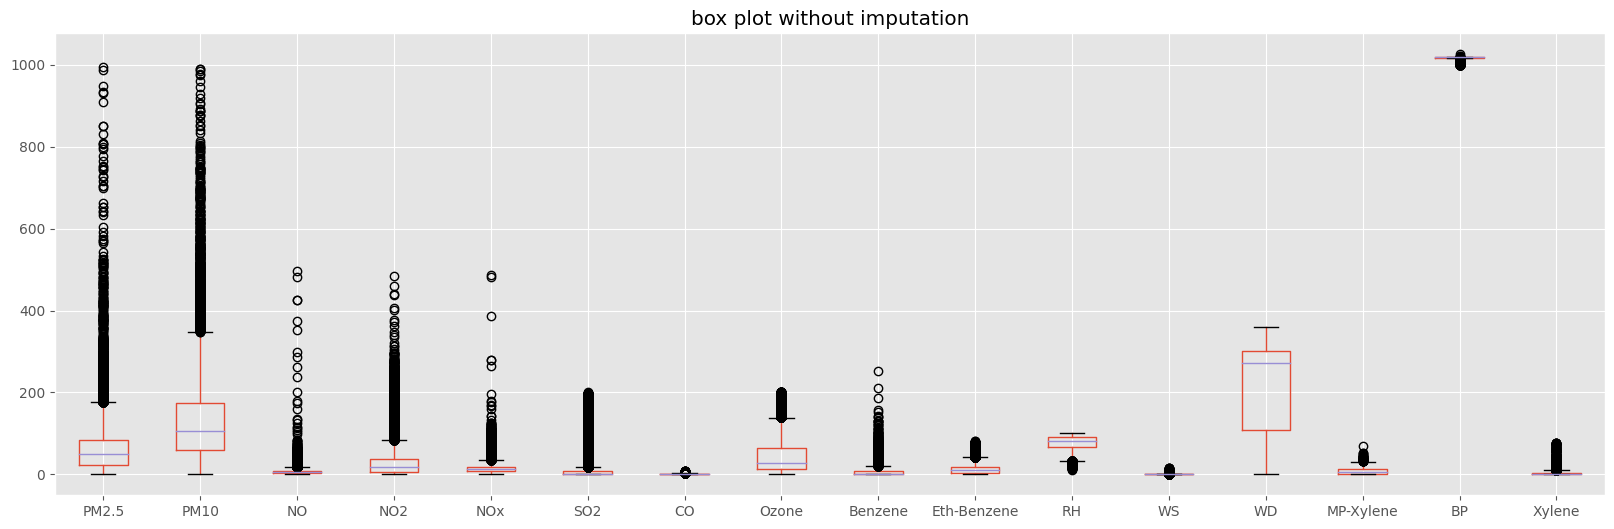

In [47]:
data_orignal =data_dict['NavyNagarColabaMumbaiIITM']
data_orignal.boxplot(list_col)
plt.title('box plot without imputation')
plt.show()

In [48]:
data= data_dict['NavyNagarColabaMumbaiIITM']

In [49]:
for column in data.columns:
  if(column == 'Date'):
     continue;
  data[column] = data[column].interpolate(method ='linear', limit_direction='forward')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76321 entries, 0 to 76320
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         76321 non-null  datetime64[ns]
 1   PM2.5        76321 non-null  float64       
 2   PM10         76321 non-null  float64       
 3   NO           76321 non-null  float64       
 4   NO2          76321 non-null  float64       
 5   NOx          76321 non-null  float64       
 6   NH3          76321 non-null  float64       
 7   SO2          76321 non-null  float64       
 8   CO           76321 non-null  float64       
 9   Ozone        76321 non-null  float64       
 10  Benzene      76321 non-null  float64       
 11  Toluene      76321 non-null  float64       
 12  Eth-Benzene  76321 non-null  float64       
 13  MP-Xylene    76321 non-null  float64       
 14  RH           76321 non-null  float64       
 15  WS           76301 non-null  float64       
 16  WD  

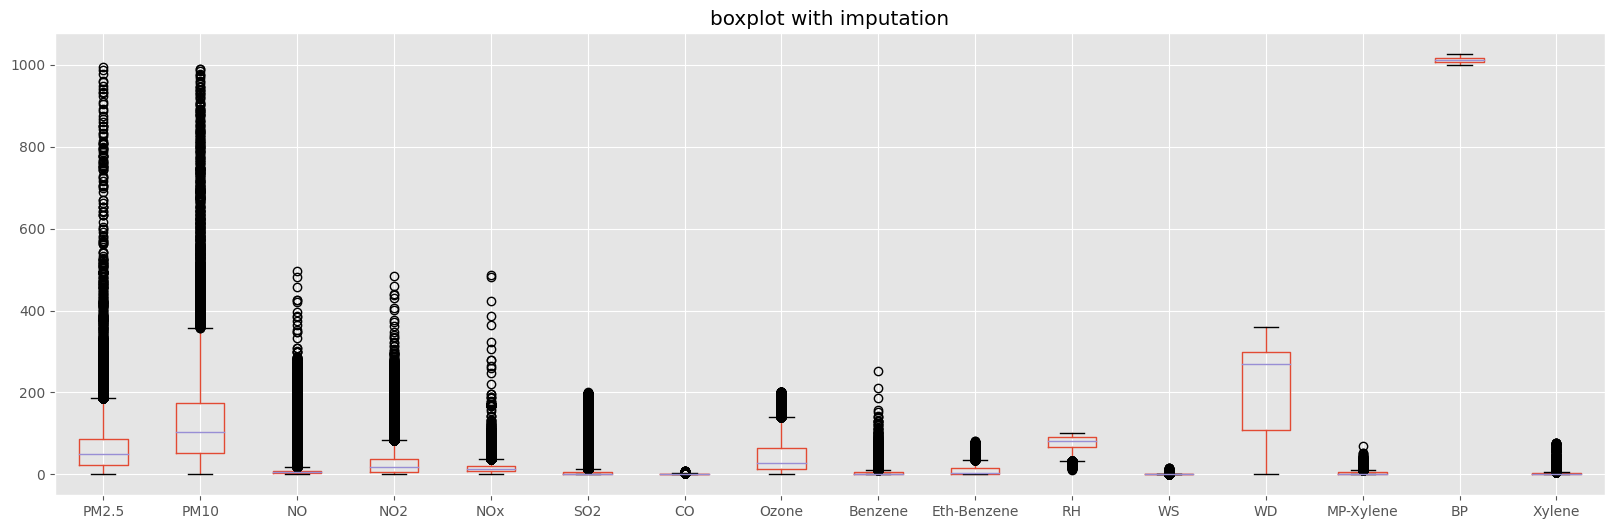

In [50]:
data.boxplot(list_col)
plt.title('boxplot with imputation')
plt.show()

#### Distribution plots

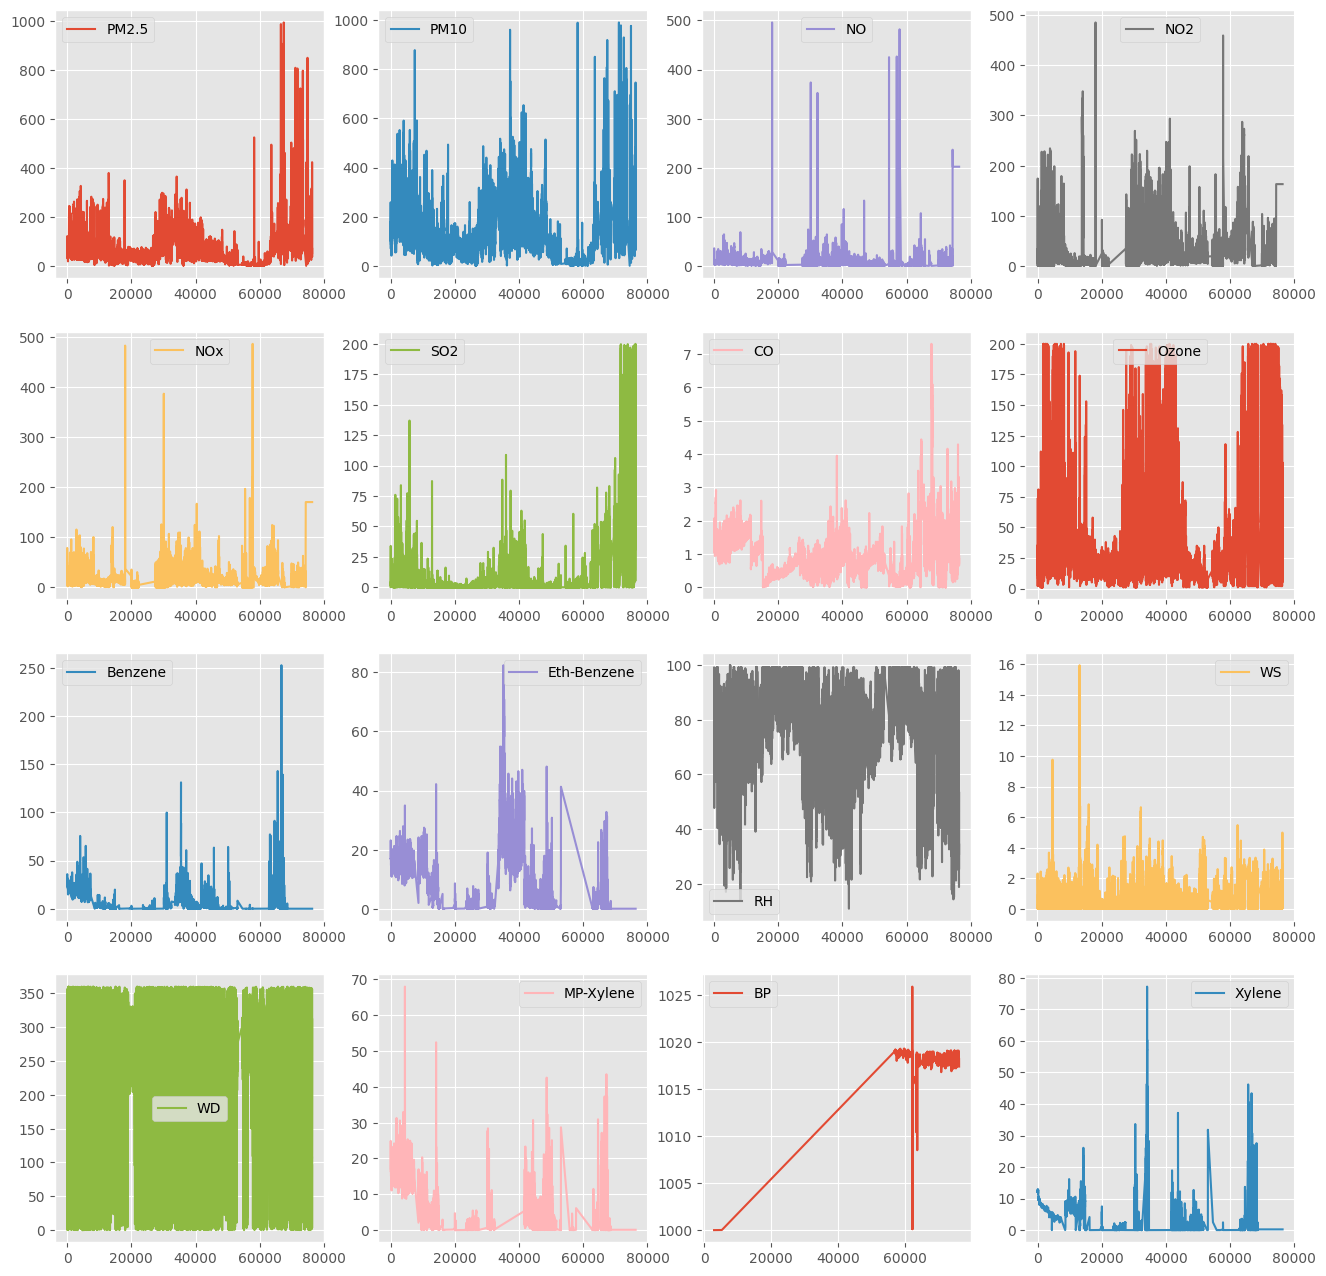

In [51]:
# Plotting the Distribution plots
fig, axes = plt.subplots(nrows=4, ncols=4 ,figsize=(16,16))
data[list_col].plot(subplots=True, ax=axes)
plt.show()


#### Seasonality of some period is also seen in above plots
### Heatmap

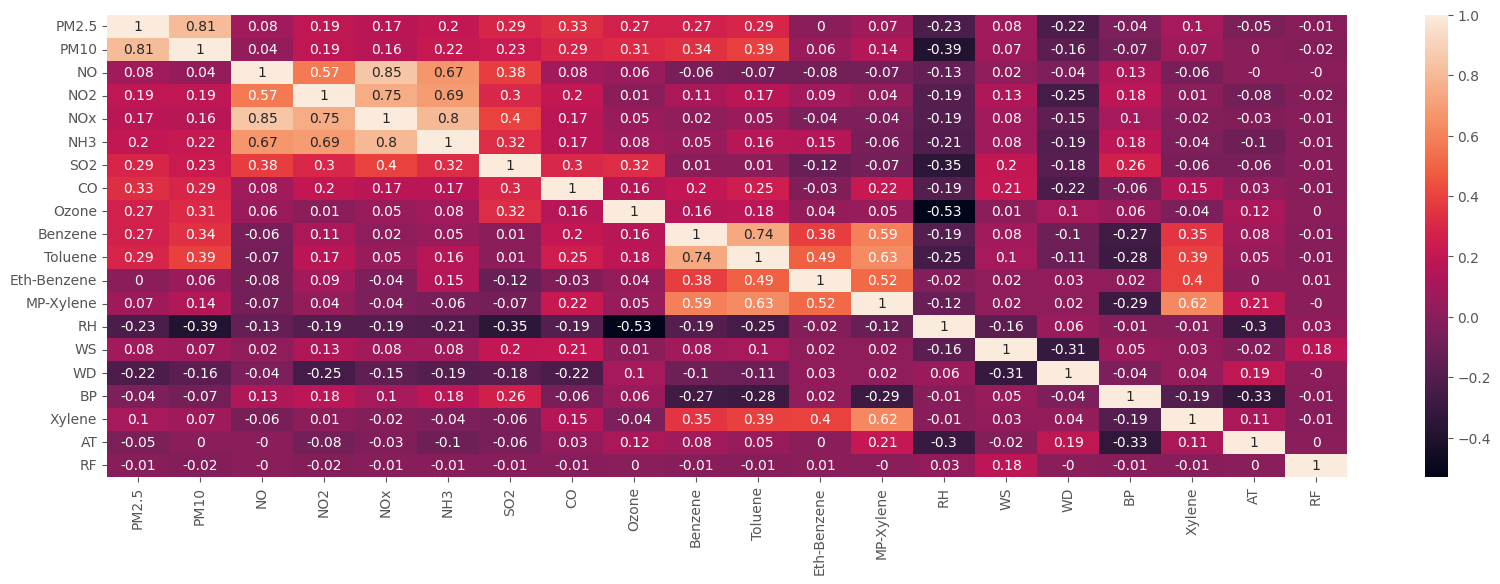

In [52]:
corr  =  data.corr()
corr = round(corr,2)
sns.heatmap(corr,annot =True)
plt.show()

<ul> <li>
PM2.5 and PM10 has high correlation(0.81) with each other</li>
<li> Nitrogen compunds ->NOx, NO, NH3 have decent correlation among each other</li>
<li> Organic Compunds like Benzene, Toulene, Eth-Benzene, MP-Xylene also correlate with each other </li>

#### Now lets check seasonality

In [53]:
### Convert the data into month format
data_month_22 = data.set_index('Date').resample('M').mean().reset_index()
### Taking data of 2022 year only 
data_month_22 = data_month_22.loc[data_month_22["Date"].between(data_month_22.iloc[12,0],data_month_22.iloc[23,0] )]
data_month_22.head()

Date      PM2.5        PM10        NO        NO2        NOx  \
12 2022-01-31  71.007766  193.834783  6.251748  43.020272  20.135010   
13 2022-02-28  56.609719  147.463185  8.292211  45.476564  22.529060   
14 2022-03-31  56.305844  147.398234  6.399712  26.581100  16.098066   
15 2022-04-30  56.609289  124.944345  4.460557  23.653803  13.043065   
16 2022-05-31  43.681152  141.726700  4.632343  25.149425  14.040614   

          NH3       SO2        CO      Ozone  ...    Toluene  Eth-Benzene  \
12  35.417286  6.169706  0.751949  59.584960  ...  18.792918    18.579700   
13  48.482038  3.989861  0.976532  65.009555  ...  17.941414    18.340244   
14  16.153291  3.443322  0.748104  57.369843  ...   9.702651     6.943060   
15  17.995102  2.821940  0.608050  30.562677  ...   7.308300     6.694531   
16  14.313918  1.984270  0.877441  21.379058  ...   4.652490     5.727773   

    MP-Xylene         RH        WS          WD           BP    Xylene  \
12   2.764147  68.034677  0.657785  201.282135  1013.331668  0.259874   
13   3.940421  73.371329  0.366240  229.986928  1014.115197  0.153882   
14   3.828081  73.153846  0.345606  240.768389  1014.631135  0.992366   
15   2.618489  75.178309  0.352078  239.487429  1015.322553  0.479938   
16   1.741682  76.805935  0.392177  259.778862  1015.983840  0.206015   

           AT        RF  
12  23.001251  0.000202  
13  23.856039  0.000000  
14  25.948834  0.002151  
15  26.747202  0.000139  
16  26.817894  0.002487  

[5 rows x 21 columns]

In [54]:
data_month_22.shape

(12, 21)

Plots of Concentration vs Months of 2022


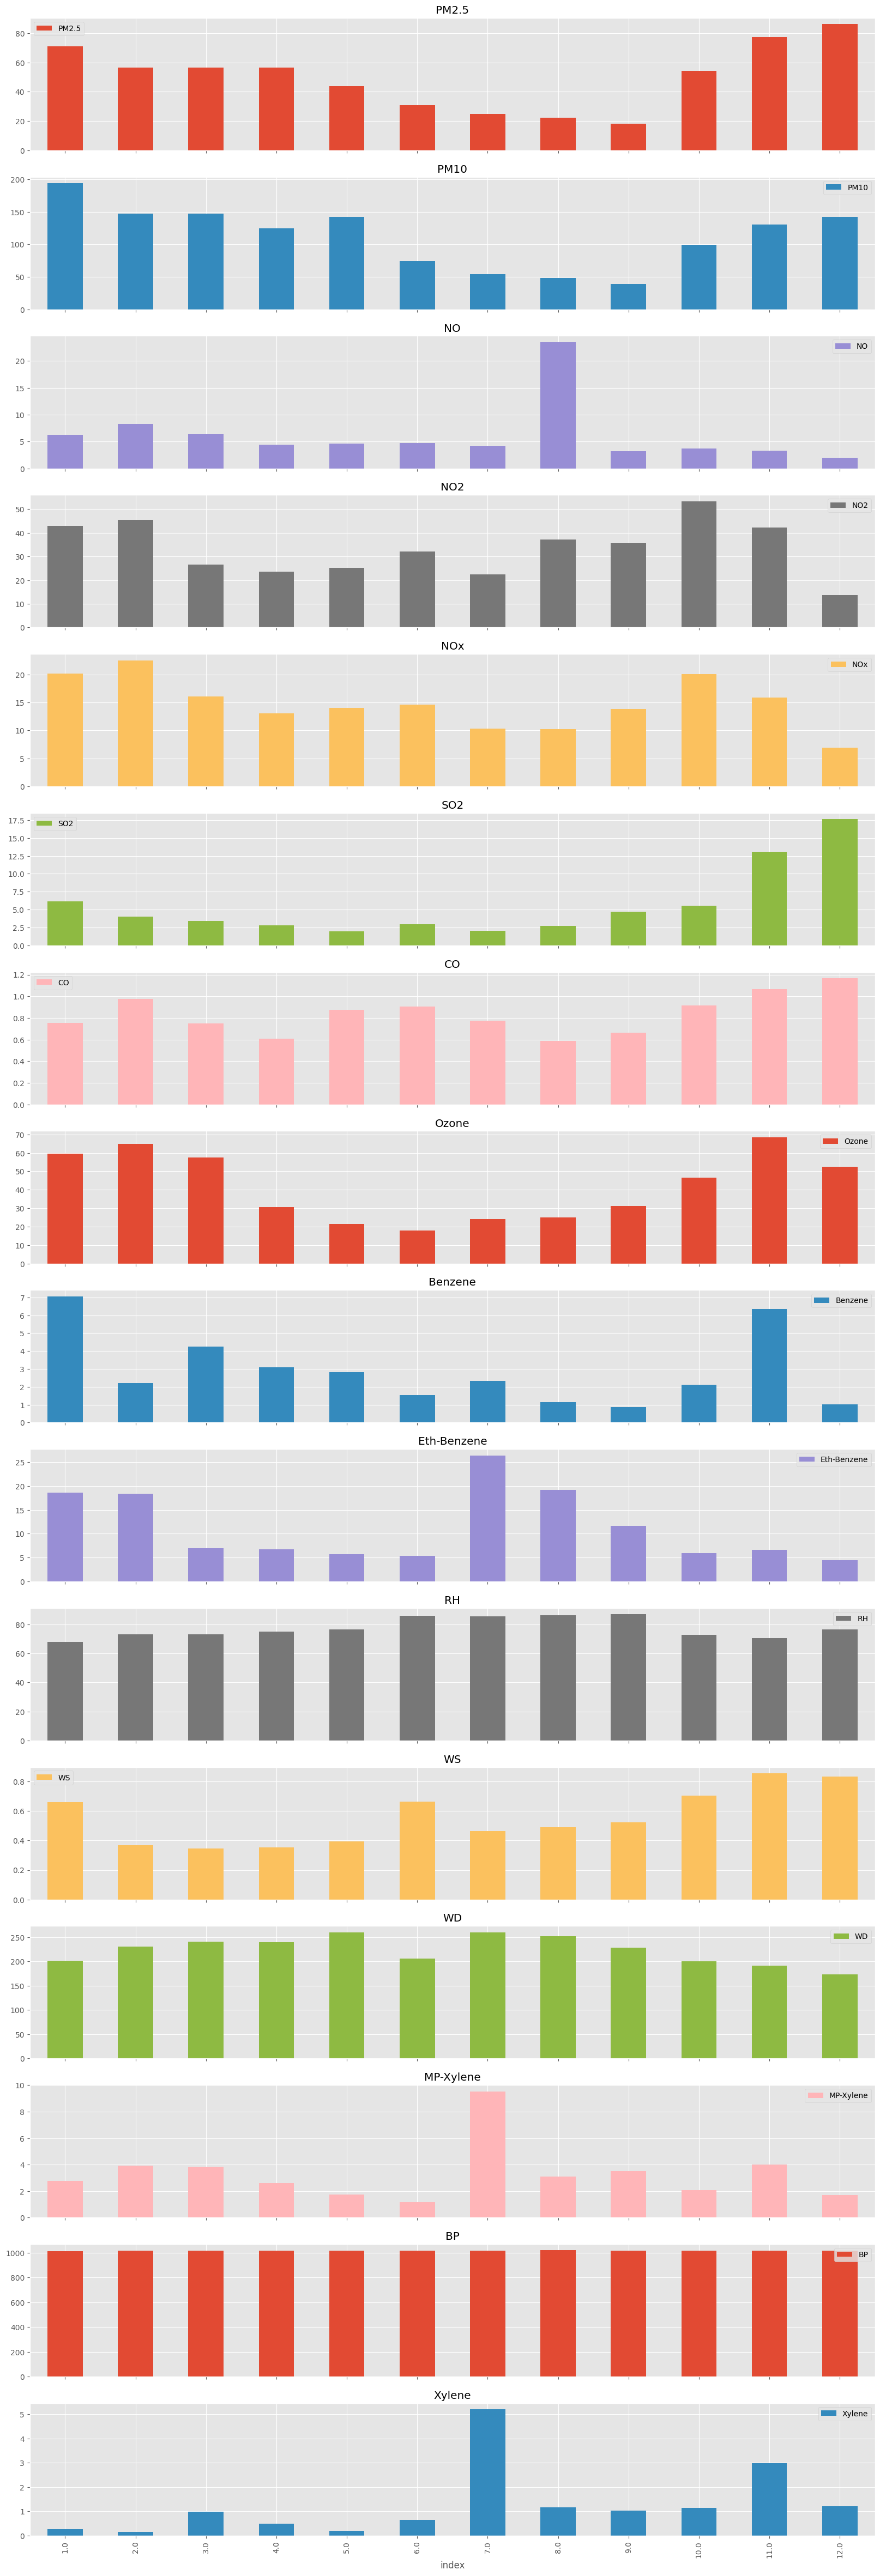

In [55]:
indexes =np.linspace(start =1 ,stop =12,num =12)
data_month_22['index'] = indexes
print('Plots of Concentration vs Months of 2022')
data_month_22.plot(x = 'index', y =list_col ,kind = 'bar',subplots =True ,figsize= (20,60))
plt.show()

In [56]:
## lets similarly  plot for 2021  year too
data_month_21= data.set_index('Date').resample('M').mean().reset_index()
data_month_21 = data_month_21.loc[data_month_21["Date"].between(data_month_21.iloc[0,0],data_month_21.iloc[11,0] )]

Concentration of Pollutant vs Months of Year 2021


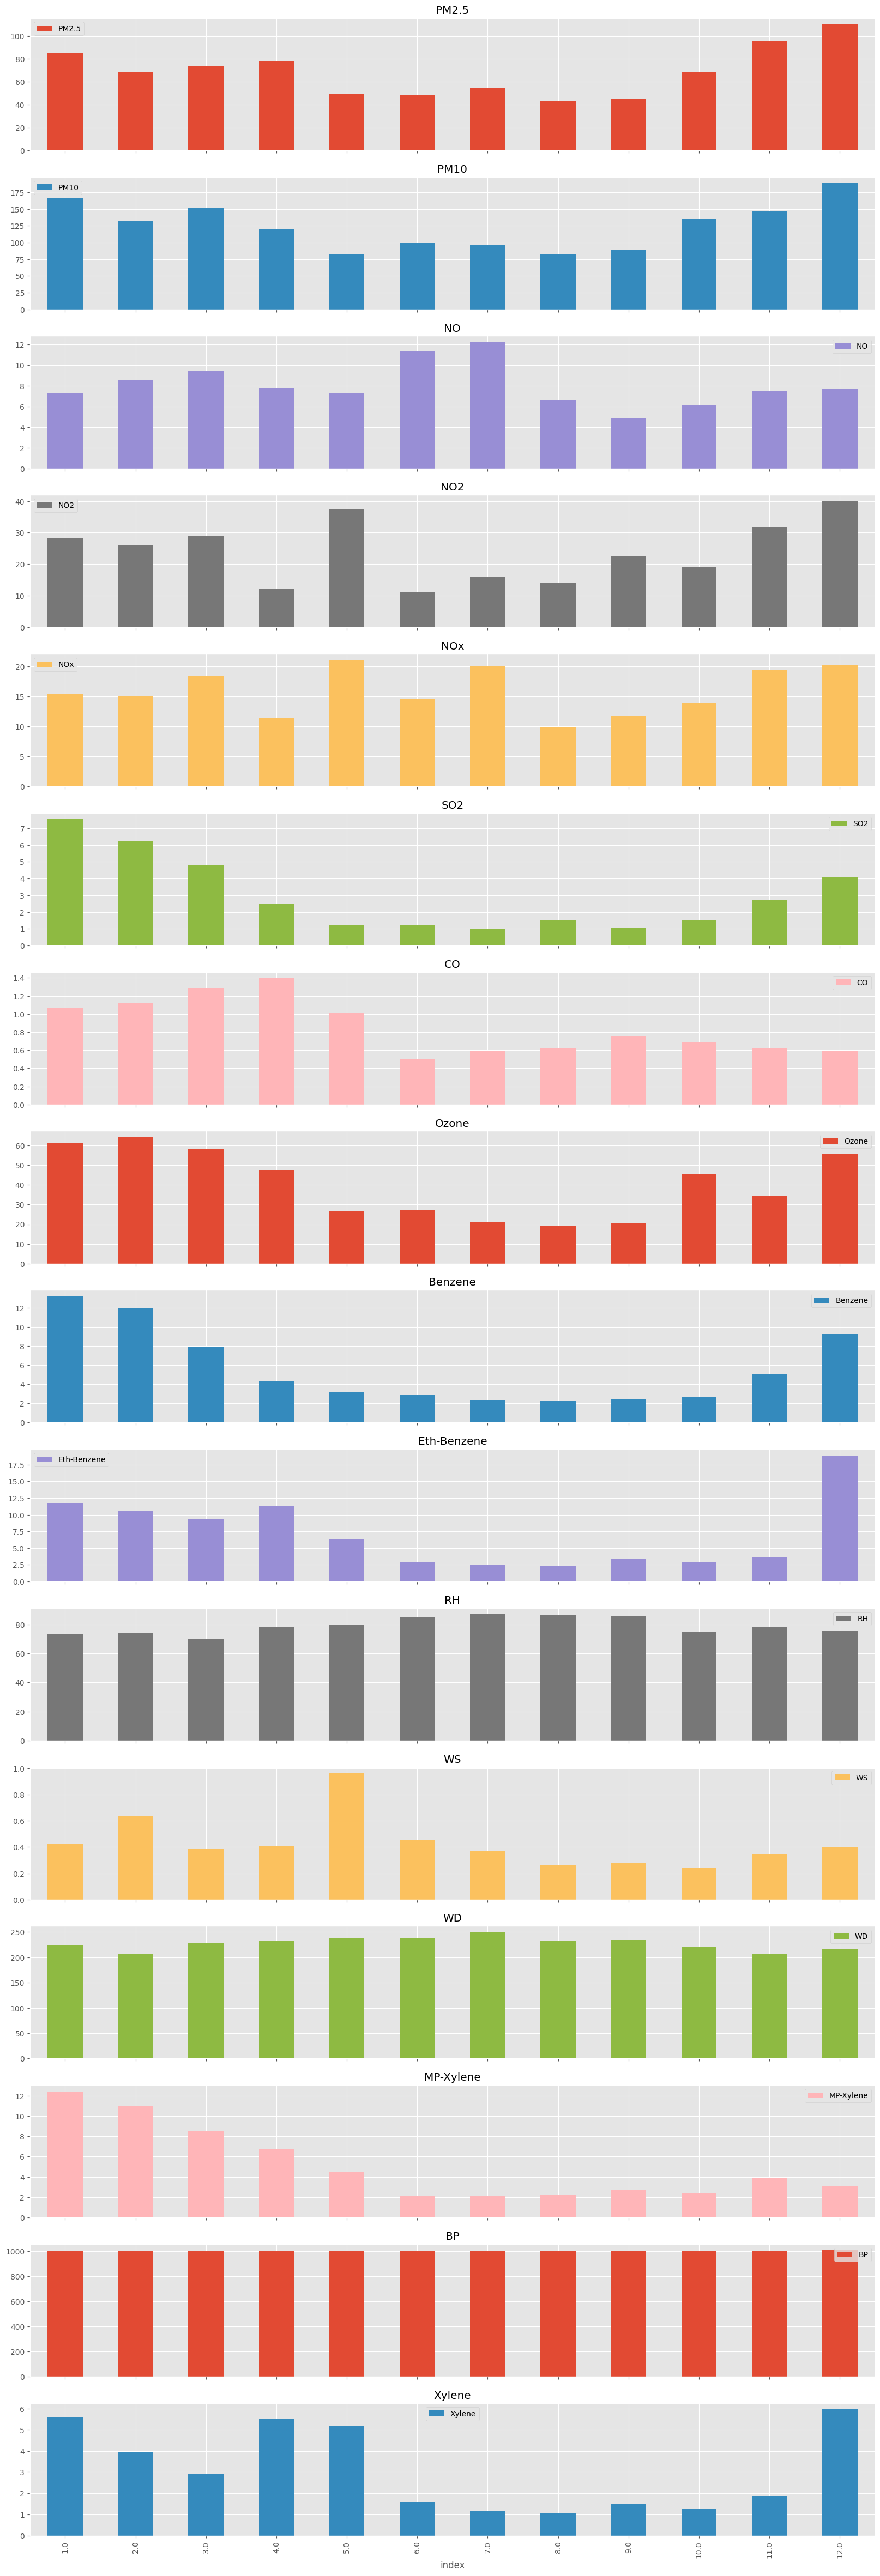

In [57]:
data_month_21['index']  = indexes
print('Concentration of Pollutant vs Months of Year 2021')
data_month_21.plot(x = 'index', y =list_col ,kind = 'bar',subplots =True ,figsize= (20,60))

plt.show()

#### Let check for the seasonality hour basis too:

In [58]:
### Convert the data into hourly basis 
data_hourly = data.set_index('Date').resample('H').mean().reset_index()
data_hourly.head()

Date      PM2.5      PM10      NO      NO2      NOx     NH3  \
0 2021-01-01 00:00:00  53.466667  114.5700  6.6600  14.7200  10.7400  6.6100   
1 2021-01-01 01:00:00  52.740000  118.8225  5.3250  16.6900   9.9075  7.3725   
2 2021-01-01 02:00:00  48.137500  105.6450  6.2975  12.5925   9.8050  7.1225   
3 2021-01-01 03:00:00  50.967500  109.3125  6.8125  12.2775  10.2275  7.2325   
4 2021-01-01 04:00:00  54.107500  114.9775  6.1250   8.8875   8.5975  8.7475   

        SO2      CO      Ozone  ...    Toluene  Eth-Benzene  MP-Xylene  \
0  1.693333  1.4800  34.666667  ...  38.066667    16.856667  17.333333   
1  2.257500  1.4225  30.500000  ...  39.442500    16.875000  17.580000   
2  3.072500  1.3800  23.500000  ...  41.372500    16.870000  18.012500   
3  1.632500  1.4475  19.750000  ...  43.520000    16.930000  18.240000   
4  1.377500  1.4750  14.250000  ...  46.517500    17.067500  18.575000   

          RH  WS        WD  BP   Xylene         AT   RF  
0  87.803333 NaN  342.4900 NaN  12.1800  24.126667  0.0  
1  91.117500 NaN  308.8775 NaN  12.1975  23.840000  0.0  
2  95.492500 NaN  328.5825 NaN  12.2575  23.635000  0.0  
3  97.892500 NaN  321.0025 NaN  12.3450  23.357500  0.0  
4  99.135000 NaN  331.6700 NaN  12.3800  23.220000  0.0  

[5 rows x 21 columns]

#### Lets check how the concentration of PM2.5 change on any random day i.e. check on hourly basis

In [59]:
def make_hourly_plot(start,end,date):
  
  hourly_index = np.linspace(1,24,24)
  y= data_hourly['PM2.5'].loc[data_hourly["Date"].between(start,end)]
  plt.title('Concentration plot (PM2.5) vs hours on {}'.format(date))
  plt.bar(hourly_index,y,)
  plt.show()


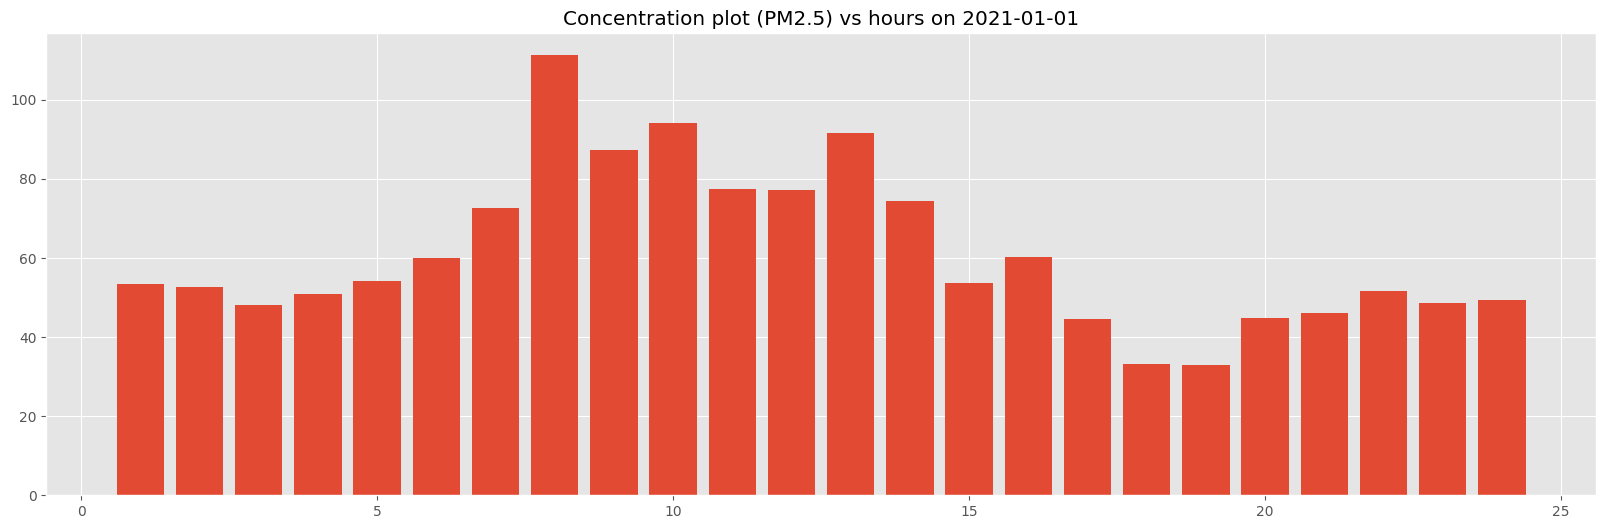

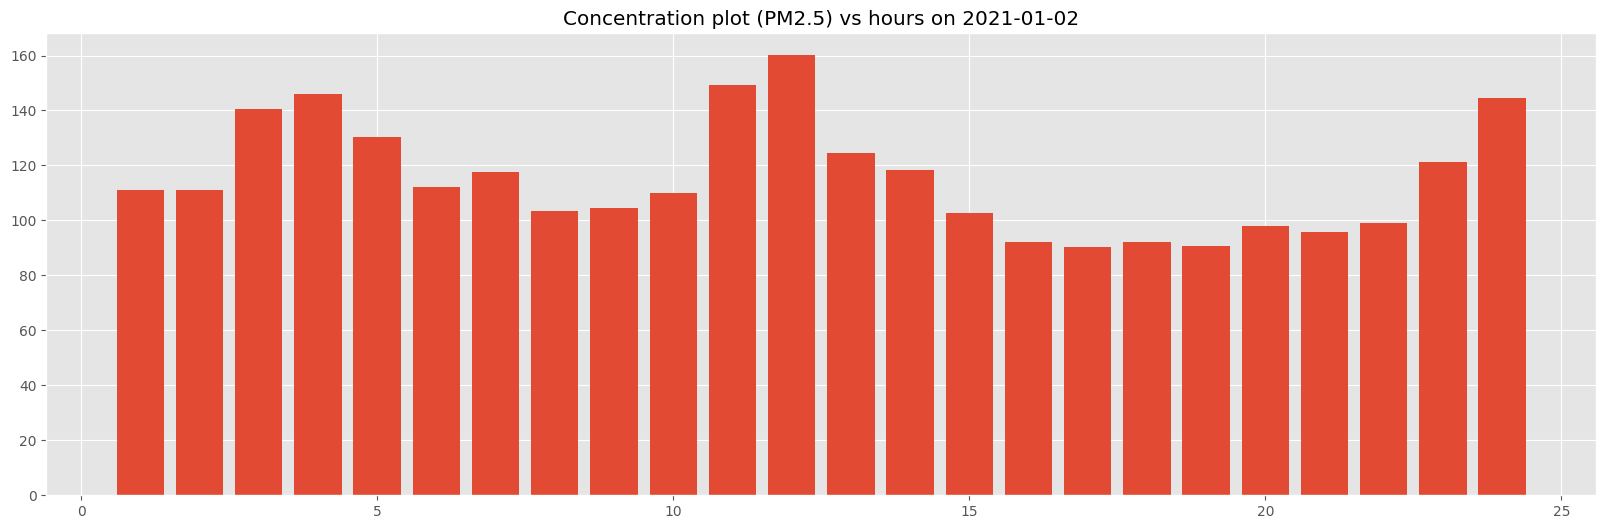

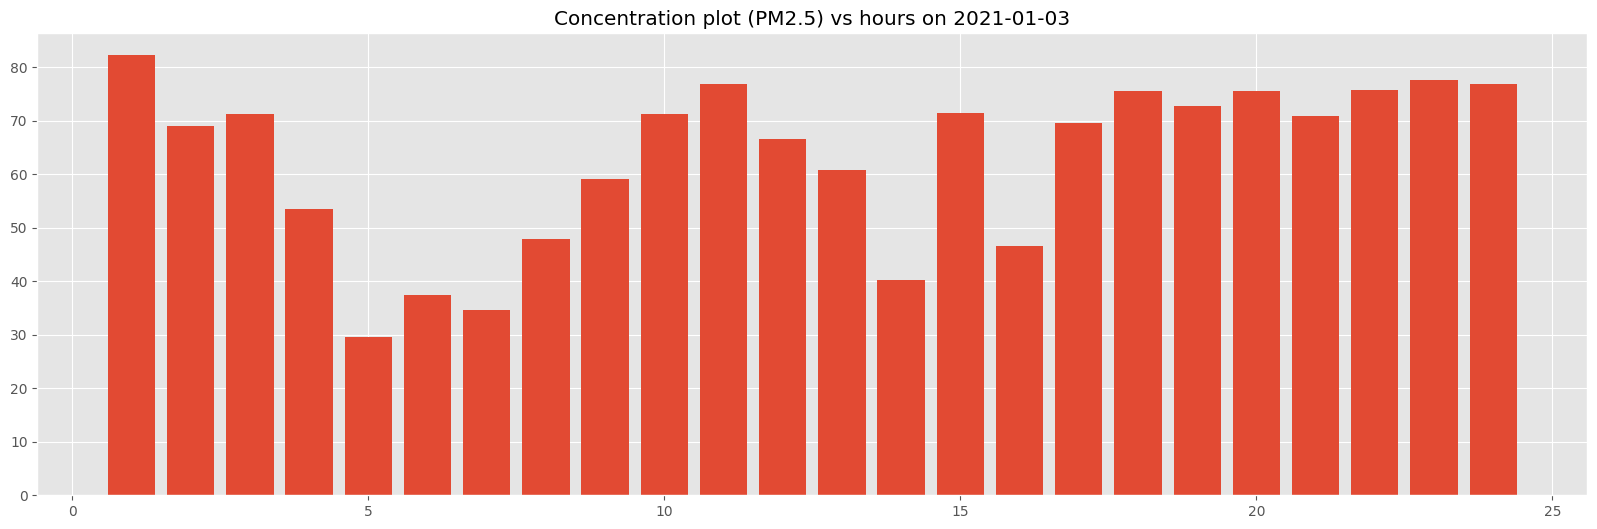

In [60]:
make_hourly_plot('2021-01-01 00:00:00','2021-01-01 23:00:00', '2021-01-01')
make_hourly_plot('2021-01-02 00:00:00','2021-01-02 23:00:00', '2021-01-02')
make_hourly_plot('2021-01-03 00:00:00','2021-01-03 23:00:00', '2021-01-03')


##### No such trend or seasonality has been observed in hourly basis

### Develop a general function for any station 

In [73]:
def visualize_all_plots(station,method):

  
  # list= ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'SO2', 'CO', 'Ozone']
  list = []
  # let visualize 1st 8 columns only: 
  for i,column in enumerate(data_dict[station].columns):
    if(column =='Date'):
      continue
    list.append(column)
    if(i==8):
      break



## Makining box plot of orignal data:
  data_orignal =data_dict[station]
  data_orignal.boxplot(list)
  plt.title('box plot without imputation')
  plt.show()

  
  ## Making box plot of imputed data
  
  data = data_dict[station]
  for column in data.columns:
    if(column == 'Date'):
      continue
    data[column] = data[column].interpolate(method = method)
  data.boxplot(list)
  plt.title('box plot with imputation')
  plt.show()


  ## Making Correlation matrix
  
  corr = data.corr()
  corr = round(corr,2)
  sns.heatmap(corr,annot =True)
  plt.show()

  ### Plotting  distribution plots:

  fig, axes = plt.subplots(nrows=2, ncols=4 ,figsize=(16,10))
  data[list].plot(subplots=True, ax=axes)
  plt.show()


  ### Plotting Concentration vs month of 2022
  data_month_22 = data.set_index('Date').resample('M').mean().reset_index()
  indexes =np.linspace(start =1 ,stop =12,num =12)
  print('\n')
  print('Plots of Concentration vs Months of 2022')
  print('\n')
  data_month_22 = data_month_22.loc[data_month_22["Date"].between(data_month_22.iloc[12,0],data_month_22.iloc[23,0] )]
  data_month_22['index'] = indexes
  data_month_22.plot(x = 'index', y =list ,kind = 'bar',subplots =True ,figsize= (20,60))
  plt.show()

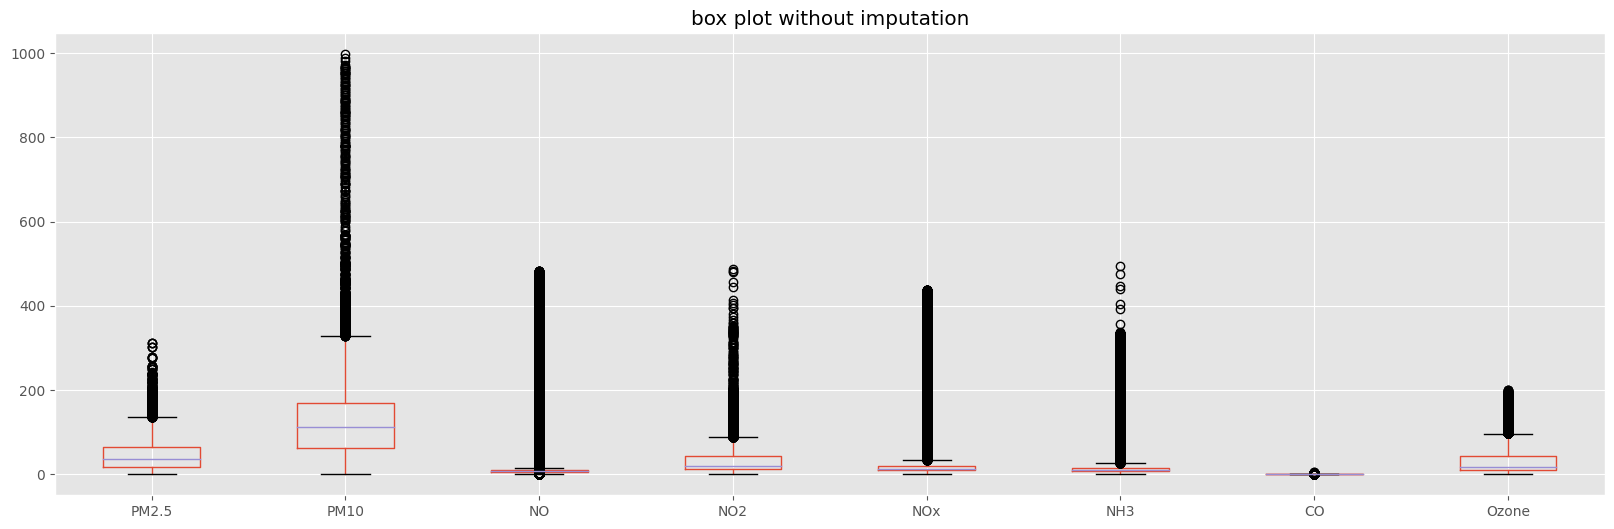

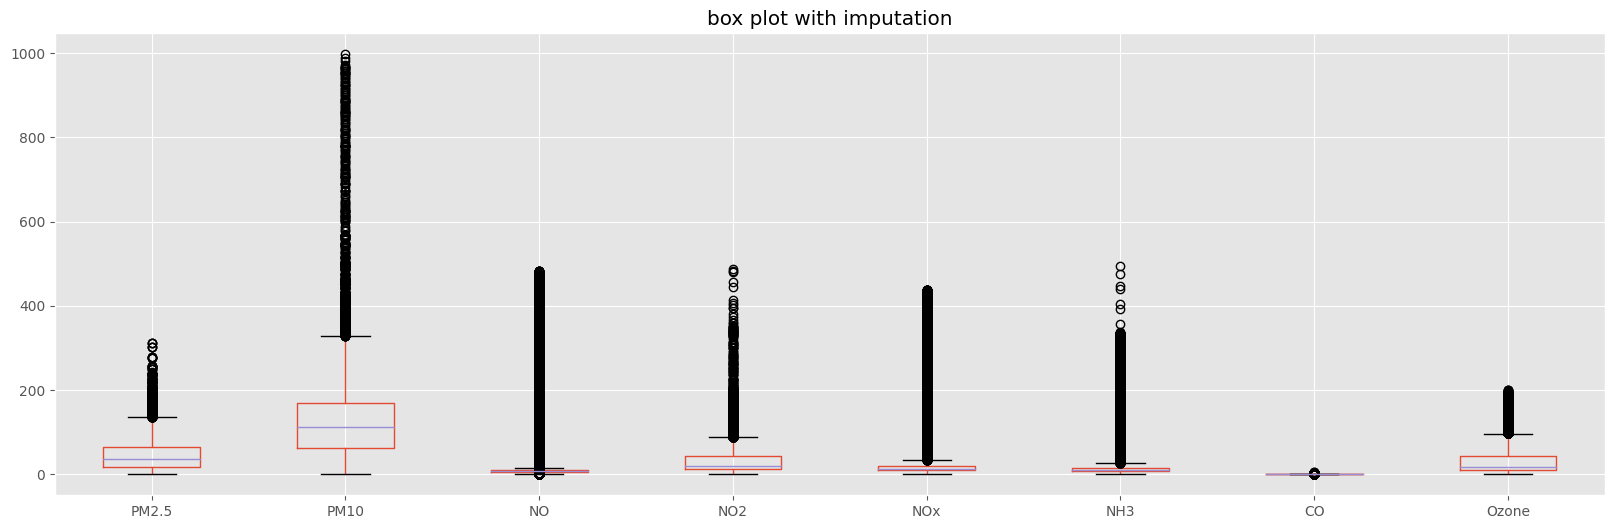

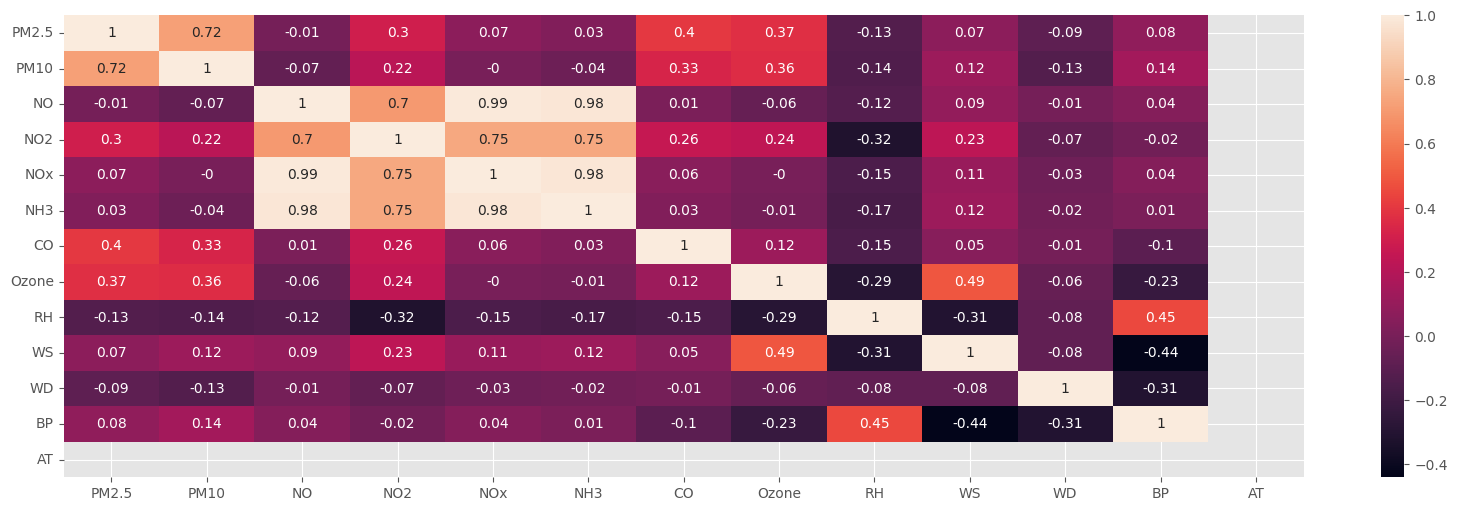

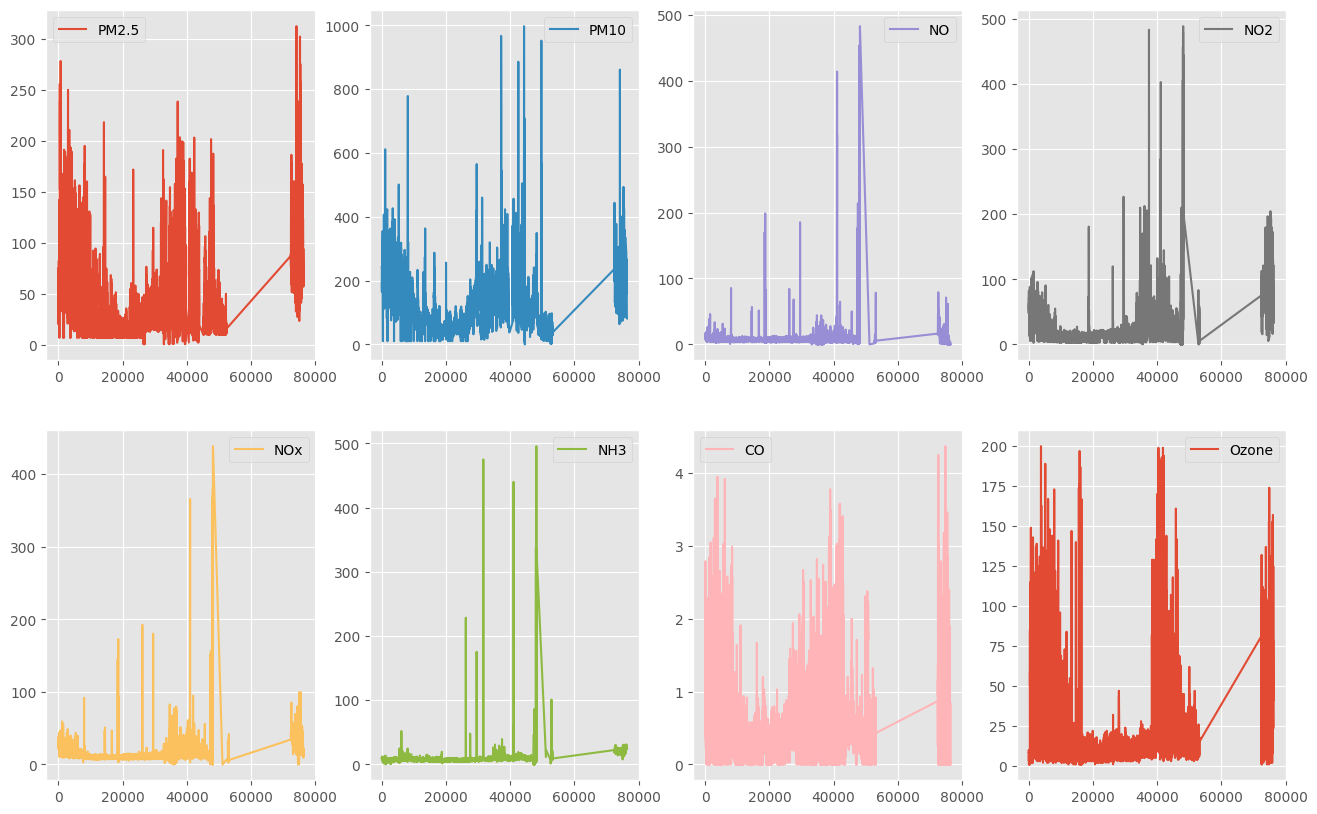



Plots of Concentration vs Months of 2022




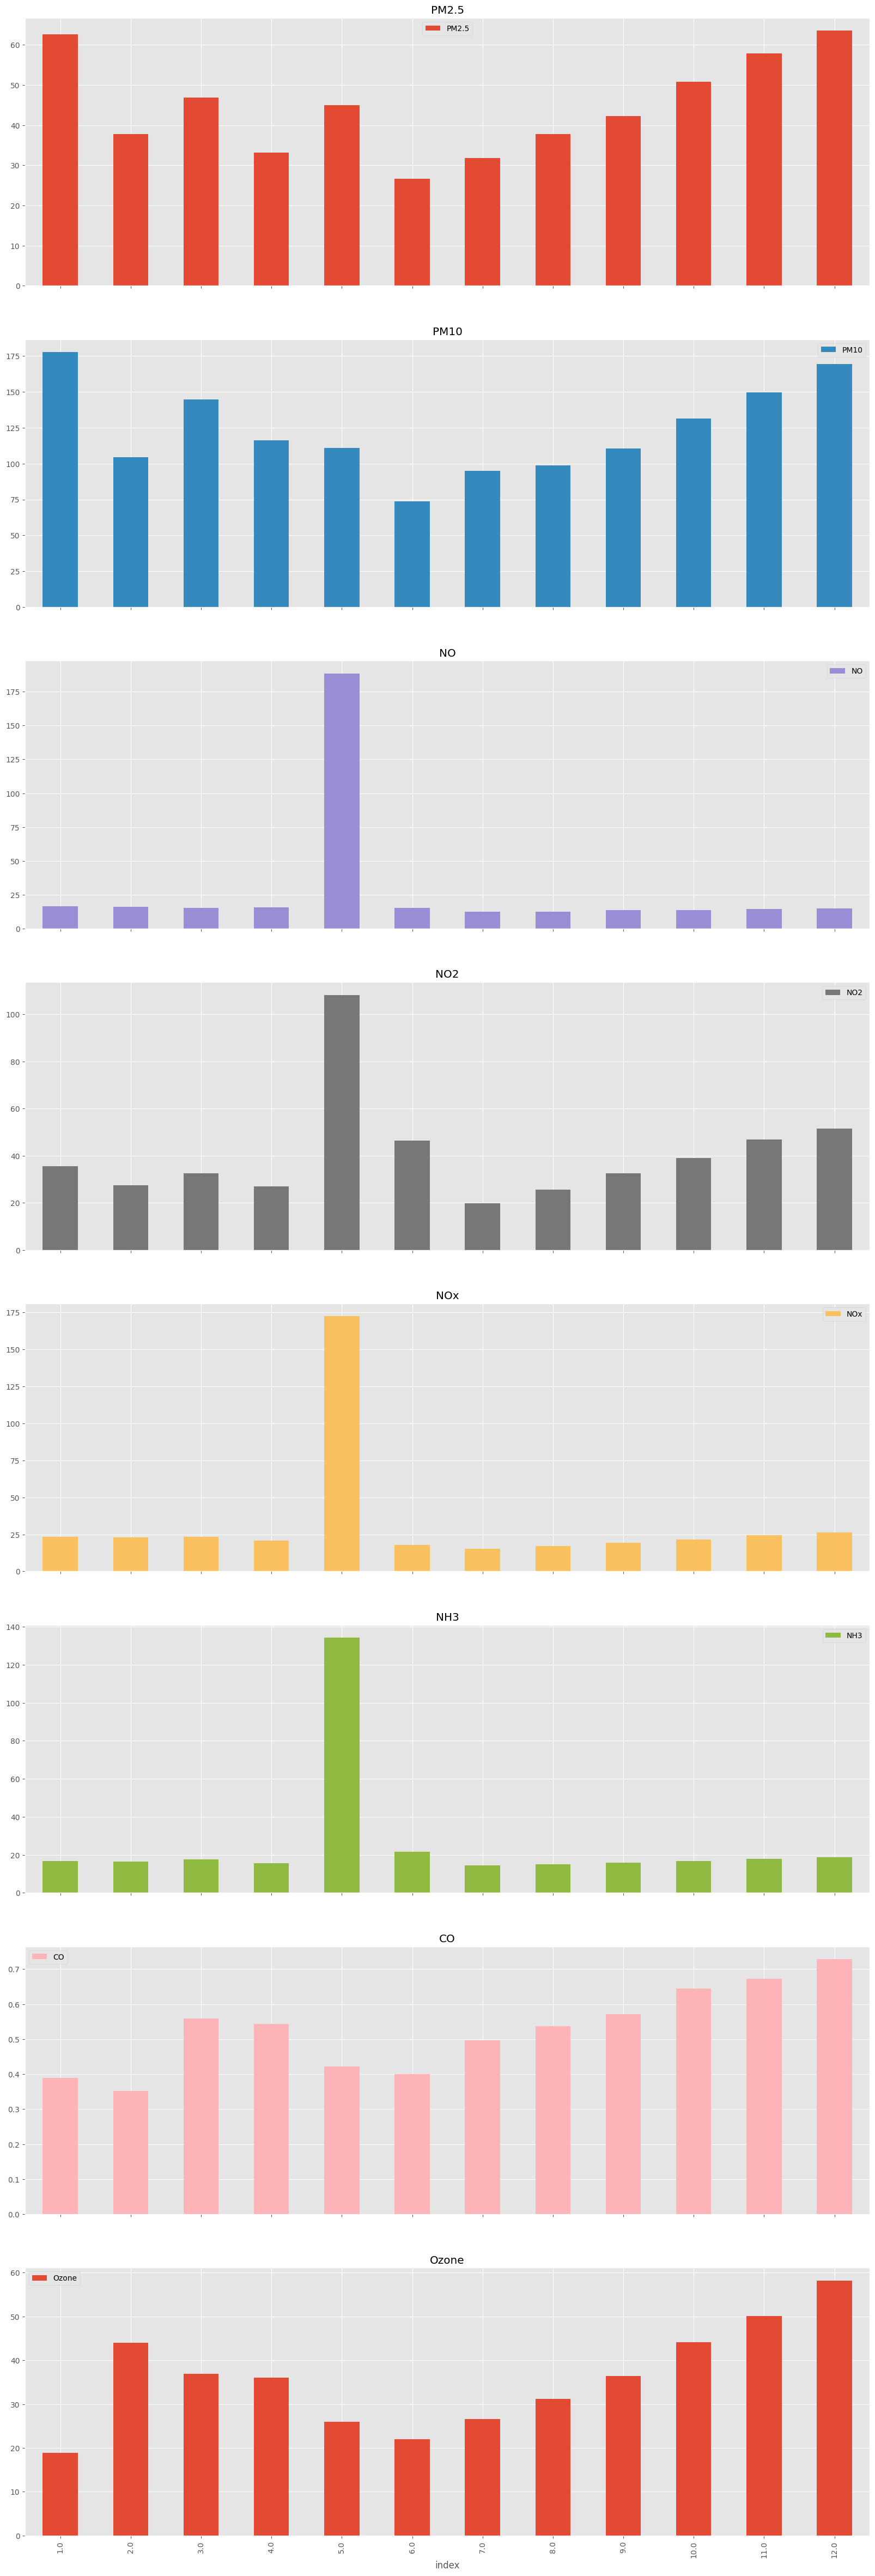

In [74]:
## We can make a dictionary which will take station as key and method(which give least mse) as value
visualize_all_plots('BorivaliEastMumbaiIITM','linear') 